In [1]:
# Requirement
!pip install geopandas

In [2]:
# Requirement
!pip install statsmodels==0.12.2

In [3]:
pip install pymc3

Note: you may need to restart the kernel to use updated packages.


In [4]:
! pip install --upgrade seaborn
! pip install --upgrade matplotlib

Requirement already up-to-date: seaborn in /opt/anaconda3/lib/python3.7/site-packages (0.11.1)
Requirement already up-to-date: matplotlib in /opt/anaconda3/lib/python3.7/site-packages (3.4.2)


In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import pymc3 as pm
from pymc3 import glm
import statsmodels.api as sm
import arviz

from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# 1) Data Overview & Processing

We obtained our air quality (ozone and pm2.5) and chronic obstructive pulmonary disease (COPD) data from the official website of the Centers for Disease Control and Prevention (CDC). 

The Ozone and PM 2.5 data are daily measures from several monitor site in each county and state. The volume of the data is 7.35 and 7.42GB. As the data is too large to process in the jupyter notebook, we used outside source to aggregate the data into states' monthly average and daily average.

The COPD dataframe contains aggregated statistics for the survey questions.

The statefips dataframe contains matching information between states' name and their fips code.

In [6]:
ozone_monthly_avg = pd.read_csv("ozone_avg.csv")
pm_monthly_avg = pd.read_csv("pm_avg.csv")
fips_states = pd.read_csv("us-state-ansi-fips.csv")
copd = pd.read_csv("copd.csv")
ozone_daily_avg = pd.read_csv("ozone_daily.csv")
pm_daily_avg = pd.read_csv("pm_daily.csv")

In [7]:
ozone_monthly_avg.head()

year  statefips  countyfips  month      ozone
0  2011          1        1001      1  33.918266
1  2011          1        1003      1  38.074951
2  2011          1        1005      1  35.903683
3  2011          1        1007      1  33.533794
4  2011          1        1009      1  34.164627

In [8]:
pm_monthly_avg.head()

year  statefips  countyfips  month         pm
0  2011          1        1001      1   9.552374
1  2011          1        1003      1   9.198687
2  2011          1        1005      1   9.436416
3  2011          1        1007      1   9.312943
4  2011          1        1009      1  10.526042

In [9]:
fips_states.head()

stname   st  stusps
0     Alabama    1      AL
1      Alaska    2      AK
2     Arizona    4      AZ
3    Arkansas    5      AR
4  California    6      CA

In [10]:
copd.head()

YearStart  YearEnd LocationAbbr LocationDesc              DataSource  \
0       2014     2014           AZ      Arizona                   BRFSS   
1       2015     2015           AR     Arkansas                   BRFSS   
2       2011     2011           CO     Colorado                   BRFSS   
3       2010     2010           DE     Delaware  CMS Part A Claims Data   
4       2017     2017           OK     Oklahoma  CMS Part A Claims Data   

                                   Topic  \
0  Chronic Obstructive Pulmonary Disease   
1  Chronic Obstructive Pulmonary Disease   
2  Chronic Obstructive Pulmonary Disease   
3  Chronic Obstructive Pulmonary Disease   
4  Chronic Obstructive Pulmonary Disease   

                                            Question  Response  \
0  Prevalence of chronic obstructive pulmonary di...       NaN   
1  Prevalence of chronic obstructive pulmonary di...       NaN   
2  Prevalence of chronic obstructive pulmonary di...       NaN   
3  Hospitalization for chronic obstructive pulmon...       NaN   
4  Hospitalization for chronic obstructive pulmon...       NaN   

     DataValueUnit            DataValueType  ...  LocationID  TopicID  \
0                %         Crude Prevalence  ...           4     COPD   
1                %         Crude Prevalence  ...           5     COPD   
2                %  Age-adjusted Prevalence  ...           8     COPD   
3  cases per 1,000        Age-adjusted Rate  ...          10     COPD   
4  cases per 1,000        Age-adjusted Rate  ...          40     COPD   

  QuestionID DataValueTypeID  StratificationCategoryID1  StratificationID1  \
0    COPD2_0         CRDPREV                    OVERALL                OVR   
1    COPD2_0         CRDPREV                    OVERALL                OVR   
2    COPD2_0      AGEADJPREV                     GENDER               GENM   
3    COPD5_3      AGEADJRATE                     GENDER               GENF   
4    COPD5_3      AGEADJRATE                       RACE                WHT   

  StratificationCategoryID2 StratificationID2  StratificationCategoryID3  \
0                       NaN               NaN                        NaN   
1                       NaN               NaN                        NaN   
2                       NaN               NaN                        NaN   
3                       NaN               NaN                        NaN   
4                       NaN               NaN                        NaN   

   StratificationID3  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  

[5 rows x 33 columns]

In [11]:
ozone_daily_avg.head()

year  statefips      date1      ozone
0  2011          1  01jan2011  32.814930
1  2011          4  01jan2011  36.942341
2  2011          5  01jan2011  30.721962
3  2011          6  01jan2011  32.829967
4  2011          8  01jan2011  37.165077

In [12]:
pm_daily_avg.head()

year  statefips      date1         pm
0  2011          1  01jan2011   4.835438
1  2011          4  01jan2011   8.379083
2  2011          5  01jan2011   5.337524
3  2011          6  01jan2011  12.855241
4  2011          8  01jan2011   4.417016

# 2) EDA for Climate & COPD Data

## 2.1) Explore the states with measurements

In [13]:
len(ozone_monthly_avg["statefips"].unique()), len(pm_monthly_avg["statefips"].unique())

(49, 49)

In [14]:
states_with_climate_measurements = ozone_monthly_avg["statefips"].unique()
states_with_climate_measurements

array([ 1,  4,  5,  6,  8,  9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56])

In [15]:
fips_states.columns = ["State", "statefips", "StateAbbr"]
fips_states

State  statefips StateAbbr
0                Alabama          1        AL
1                 Alaska          2        AK
2                Arizona          4        AZ
3               Arkansas          5        AR
4             California          6        CA
5               Colorado          8        CO
6            Connecticut          9        CT
7               Delaware         10        DE
8   District of Columbia         11        DC
9                Florida         12        FL
10               Georgia         13        GA
11                Hawaii         15        HI
12                 Idaho         16        ID
13              Illinois         17        IL
14               Indiana         18        IN
15                  Iowa         19        IA
16                Kansas         20        KS
17              Kentucky         21        KY
18             Louisiana         22        LA
19                 Maine         23        ME
20              Maryland         24        MD
21         Massachusetts         25        MA
22              Michigan         26        MI
23             Minnesota         27        MN
24           Mississippi         28        MS
25              Missouri         29        MO
26               Montana         30        MT
27              Nebraska         31        NE
28                Nevada         32        NV
29         New Hampshire         33        NH
30            New Jersey         34        NJ
31            New Mexico         35        NM
32              New York         36        NY
33        North Carolina         37        NC
34          North Dakota         38        ND
35                  Ohio         39        OH
36              Oklahoma         40        OK
37                Oregon         41        OR
38          Pennsylvania         42        PA
39          Rhode Island         44        RI
40        South Carolina         45        SC
41          South Dakota         46        SD
42             Tennessee         47        TN
43                 Texas         48        TX
44                  Utah         49        UT
45               Vermont         50        VT
46              Virginia         51        VA
47            Washington         53        WA
48         West Virginia         54        WV
49             Wisconsin         55        WI
50               Wyoming         56        WY

In [16]:
states_name_with_climate_measurement = fips_states.loc[fips_states["statefips"].isin(states_with_climate_measurements)]
states_name_with_climate_measurement = states_name_with_climate_measurement["StateAbbr"]
states_name_with_climate_measurement = list(states_name_with_climate_measurement)
states_name_with_climate_measurement = [state[-2::] for state in states_name_with_climate_measurement]
states_name_with_climate_measurement 

['AL',
 'AZ',
 'AR',
 'CA',
 'CO',
 'CT',
 'DE',
 'DC',
 'FL',
 'GA',
 'ID',
 'IL',
 'IN',
 'IA',
 'KS',
 'KY',
 'LA',
 'ME',
 'MD',
 'MA',
 'MI',
 'MN',
 'MS',
 'MO',
 'MT',
 'NE',
 'NV',
 'NH',
 'NJ',
 'NM',
 'NY',
 'NC',
 'ND',
 'OH',
 'OK',
 'OR',
 'PA',
 'RI',
 'SC',
 'SD',
 'TN',
 'TX',
 'UT',
 'VT',
 'VA',
 'WA',
 'WV',
 'WI',
 'WY']

So we find out that Hawaii and Alaska does not have PM 2.5 and Ozone measurements. We need to exclude them in the COPD table. Saved variable containing the states name and states' fips code that we have PM 2.5 and Ozone data.

## 2.2) Explore the distribution of Ozone and PM 2.5 yearly average statistics across four years (2011-2014)

In [17]:
ozone_yearly_state_average = ozone_monthly_avg[["year", "statefips", "ozone"]].groupby(["year", "statefips"]).mean()
ozone_yearly_state_average = ozone_yearly_state_average.reset_index()
ozone_yearly_state_average

year  statefips      ozone
0    2011          1  40.925476
1    2011          4  47.554522
2    2011          5  40.560300
3    2011          6  39.876629
4    2011          8  47.543088
..    ...        ...        ...
191  2014         51  39.153673
192  2014         53  33.957444
193  2014         54  38.637714
194  2014         55  36.232746
195  2014         56  42.970285

[196 rows x 3 columns]

In [18]:
year_range = ozone_yearly_state_average["year"].unique()
year_range

array([2011, 2012, 2013, 2014])

In [19]:
## Check consistency for each state has one yearly statistics for four years
4 * 49 == 196

True

In [20]:
pm_yearly_state_average = pm_monthly_avg[["year", "statefips", "pm"]].groupby(["year", "statefips"]).mean()
pm_yearly_state_average = pm_yearly_state_average.reset_index()
pm_yearly_state_average

year  statefips         pm
0    2011          1  10.342133
1    2011          4   6.514218
2    2011          5  10.255528
3    2011          6   8.412789
4    2011          8   5.553280
..    ...        ...        ...
191  2014         51   8.751517
192  2014         53   6.878464
193  2014         54   9.255516
194  2014         55   8.265516
195  2014         56   4.279440

[196 rows x 3 columns]

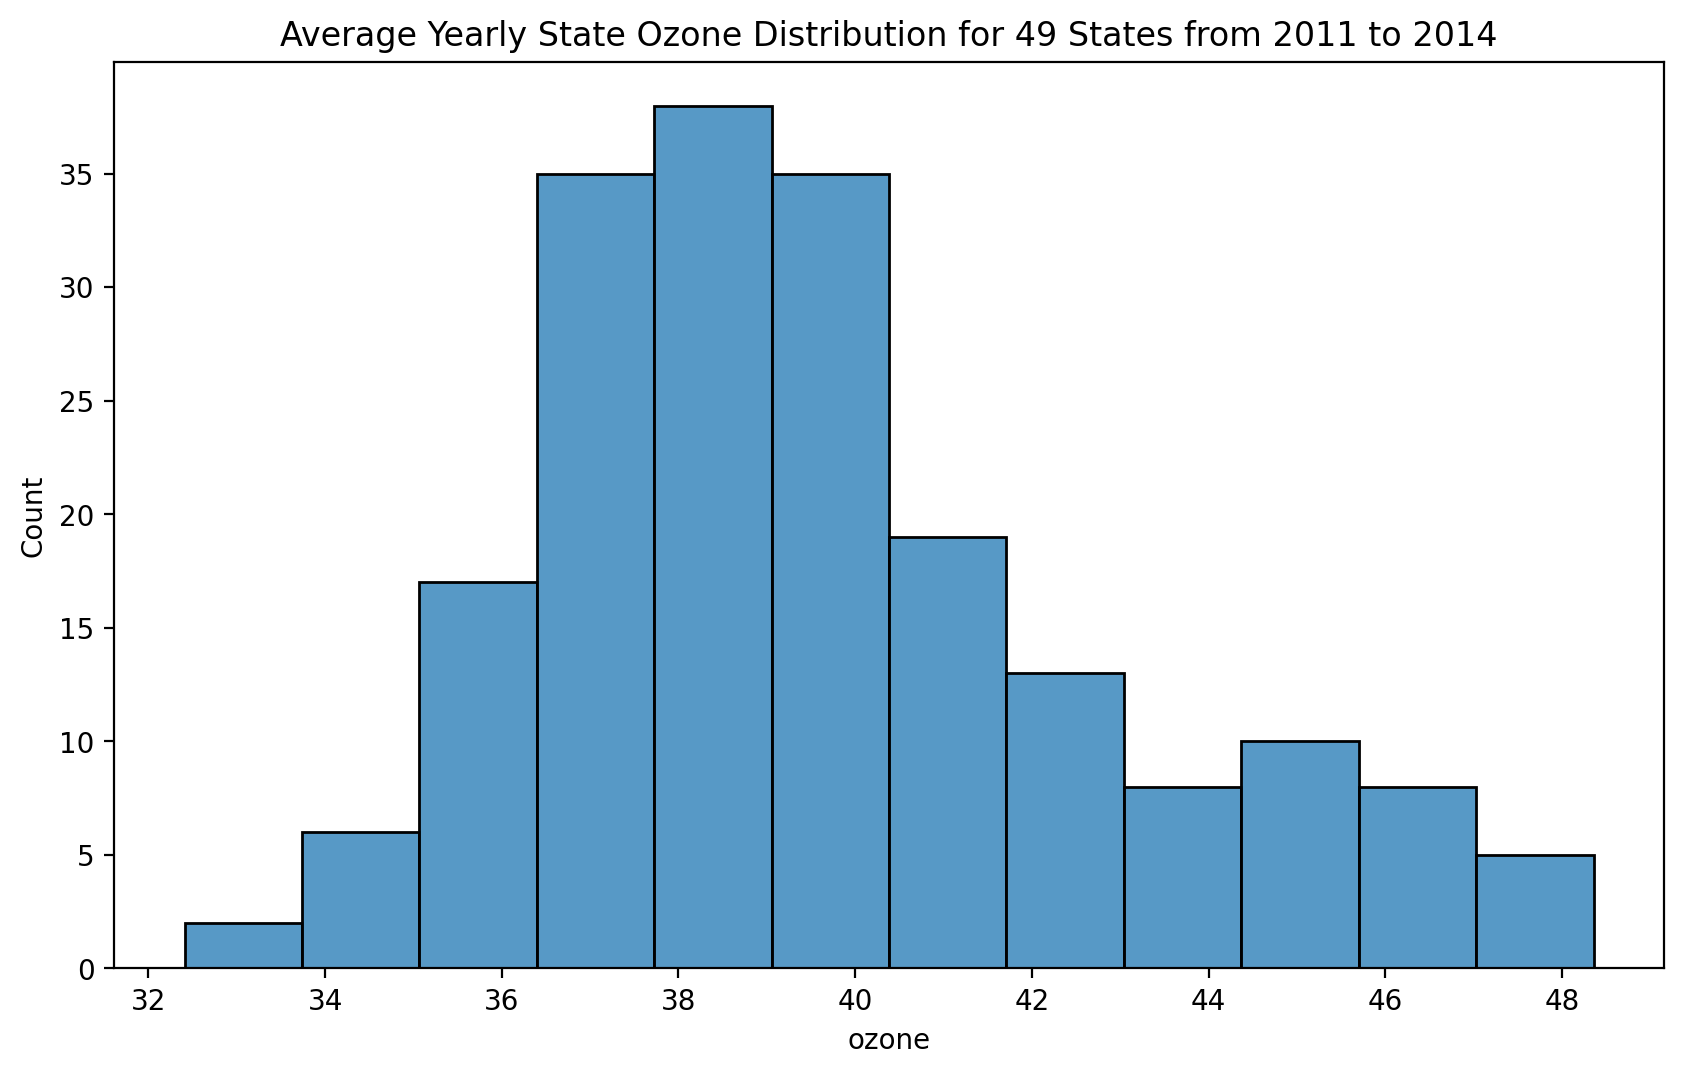

In [21]:
plt.figure(figsize=(10, 6), dpi=200)
sns.histplot(data =ozone_yearly_state_average, x = "ozone" )
plt.title("Average Yearly State Ozone Distribution for 49 States from 2011 to 2014");

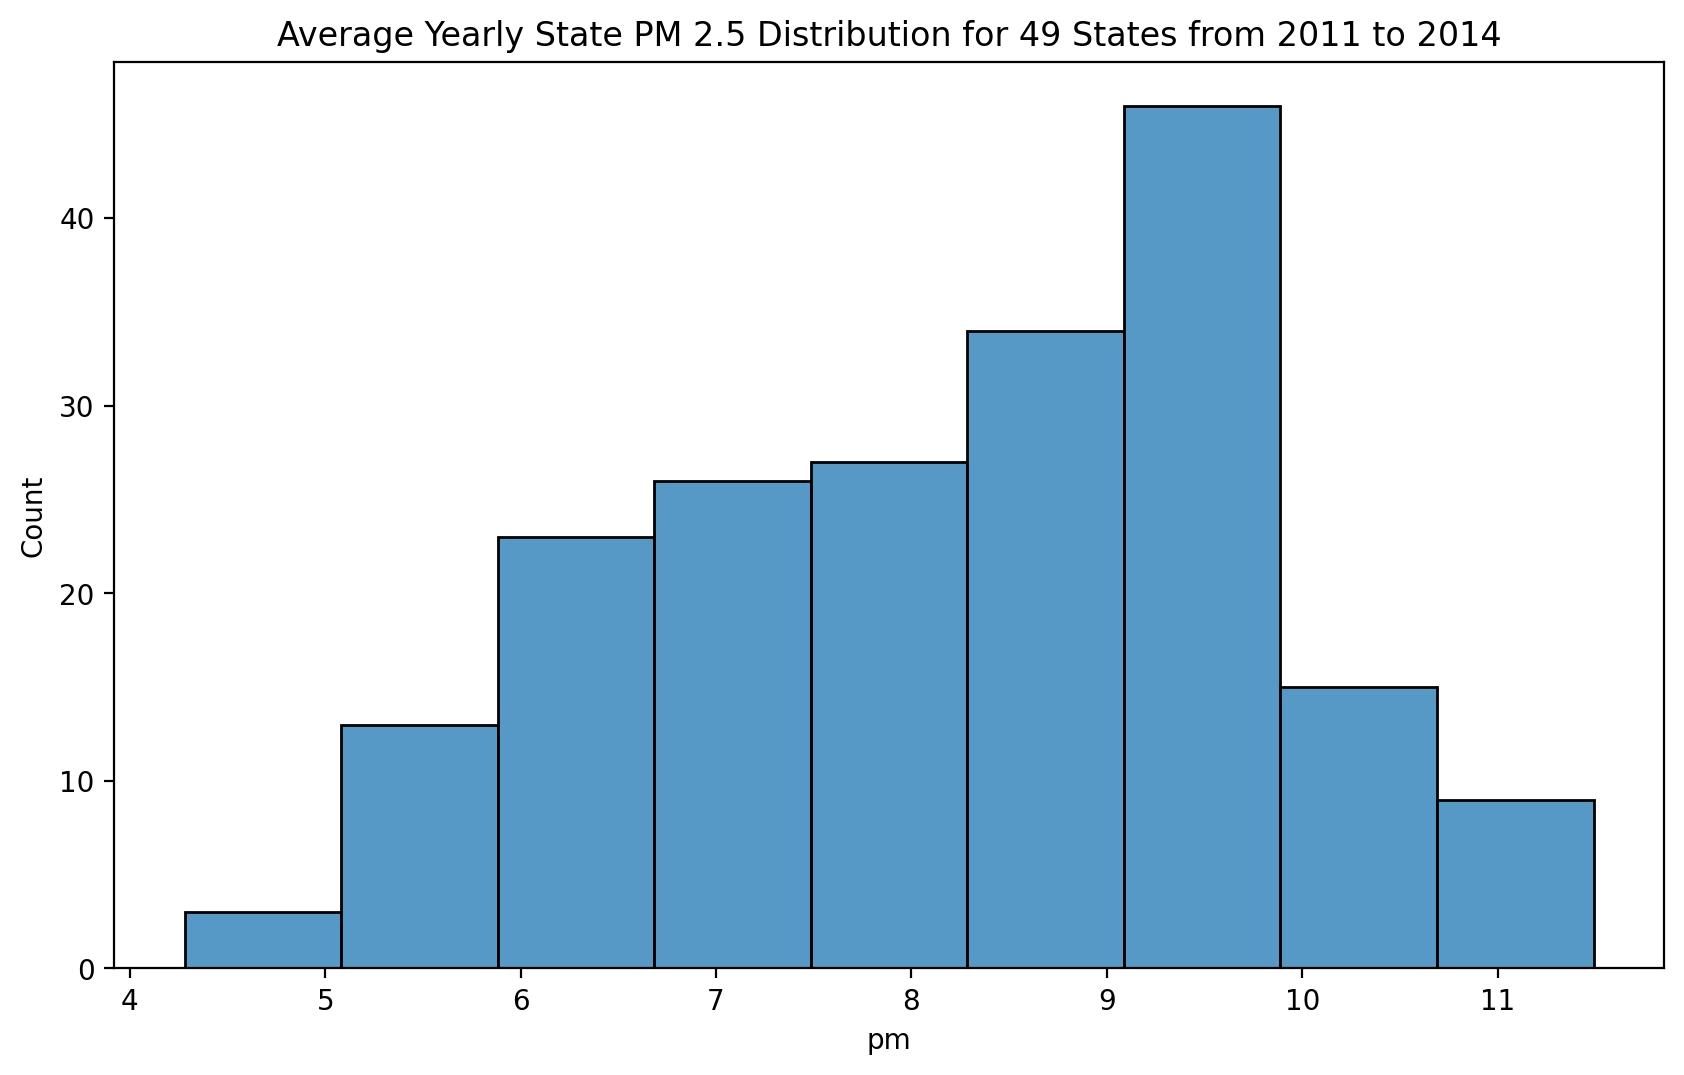

In [22]:
plt.figure(figsize=(10, 6), dpi=200)
sns.histplot(data =pm_yearly_state_average, x = "pm" )
plt.title("Average Yearly State PM 2.5 Distribution for 49 States from 2011 to 2014");

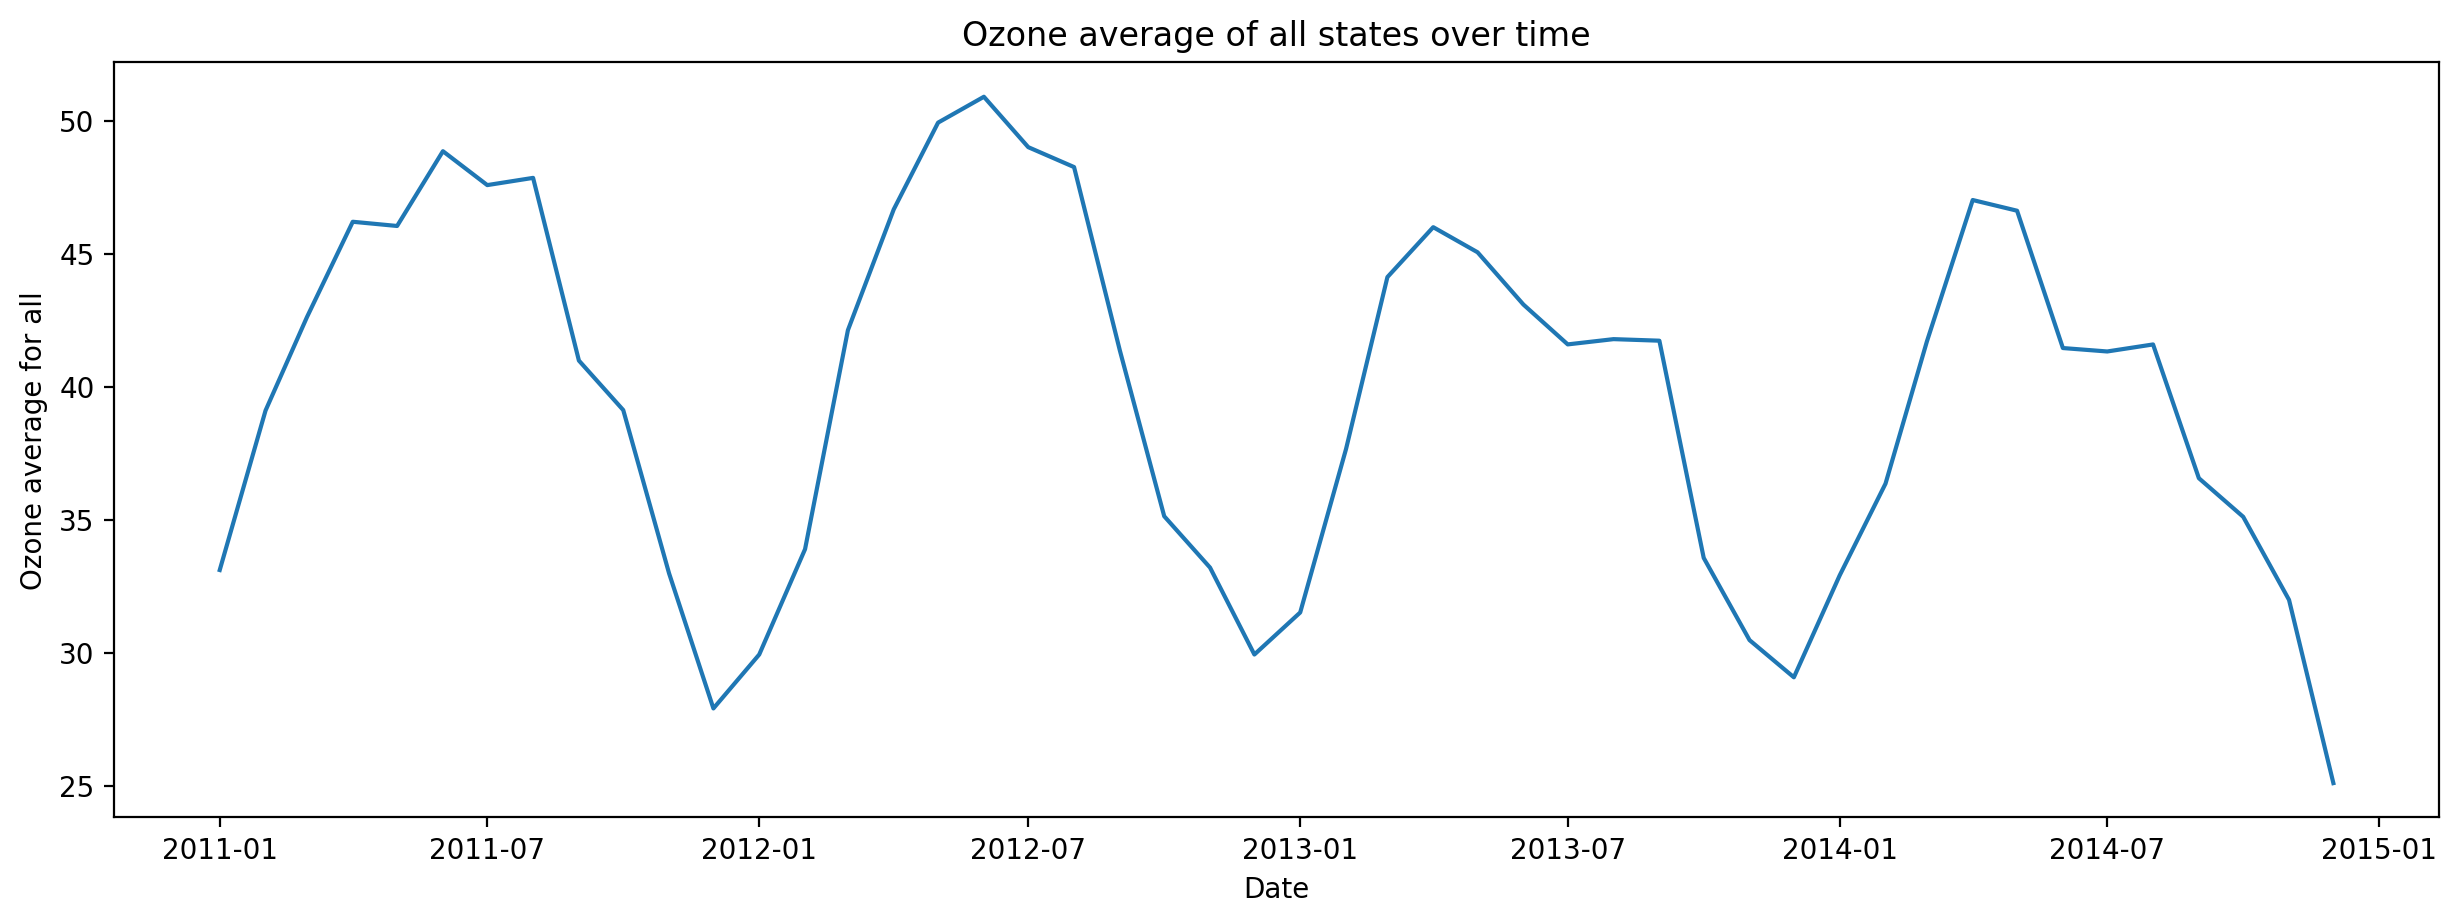

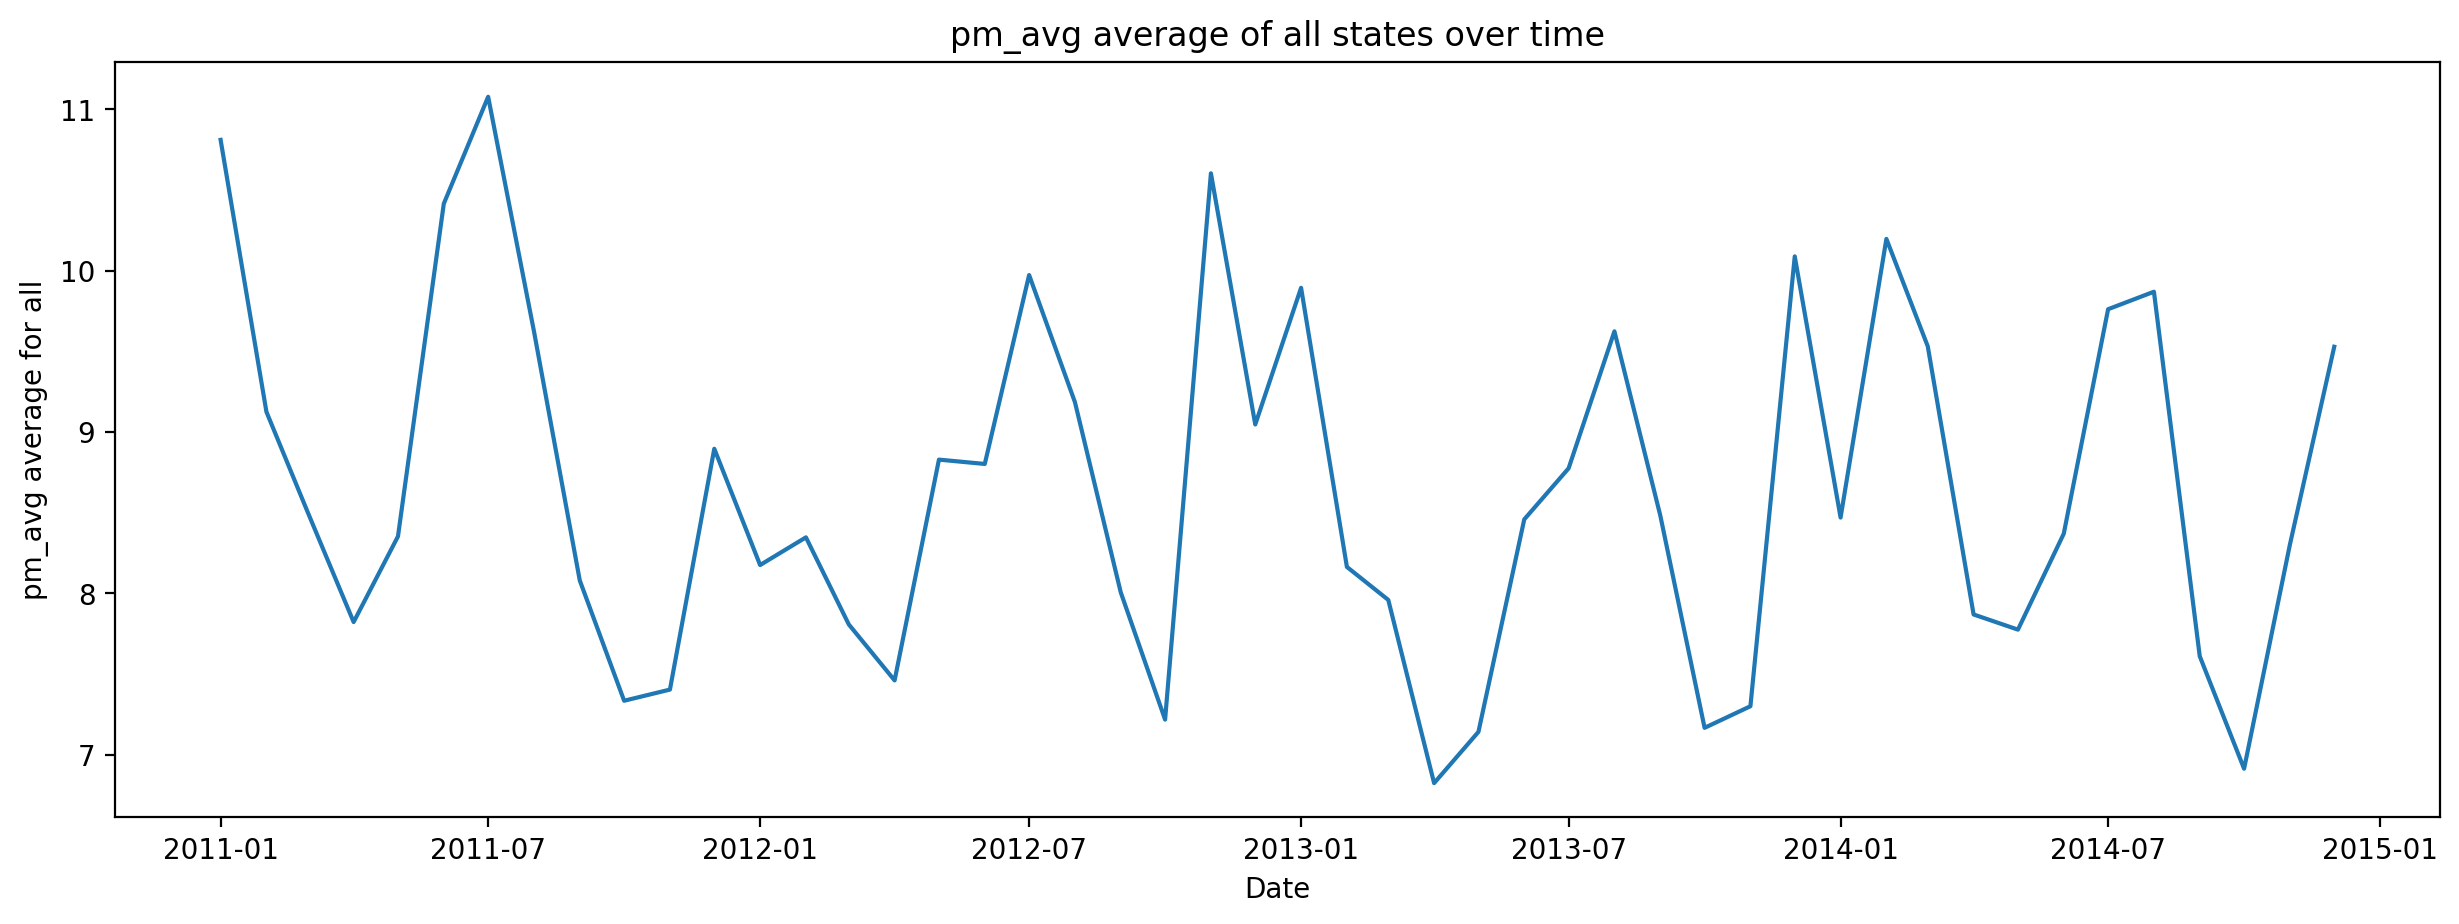

In [23]:
data_time = ozone_monthly_avg.groupby(['year','month']).mean().reset_index()
data_time['year'] = data_time['year'].astype(str)
data_time['month'] = data_time['month'].astype(str)
data_time['time'] = data_time['year'] + '/' + data_time['month']
data_time['time'] = pd.to_datetime(data_time['time'])
## plot
plt.figure(figsize = (15,5))
plt.gcf().set_dpi(200)
plt.plot(data_time['time'],data_time['ozone'])
plt.xlabel('Date')
plt.ylabel('Ozone average for all')
plt.title('Ozone average of all states over time')

data_time = pm_monthly_avg.groupby(['year','month']).mean().reset_index()
data_time['year'] = data_time['year'].astype(str)
data_time['month'] = data_time['month'].astype(str)
data_time['time'] = data_time['year'] + '/' + data_time['month']
data_time['time'] = pd.to_datetime(data_time['time'])
## plot
plt.figure(figsize = (15,5))
plt.gcf().set_dpi(200)
plt.plot(data_time['time'],data_time['pm'])
plt.xlabel('Date')
plt.ylabel('pm_avg average for all')
plt.title('pm_avg average of all states over time');

## 2.3) GEOSPATIAL GRAPH

For the initial assessmen of treatment and control group for causal inference, we visualize the yearly level of ozone and PM2.5 on a map.

In [24]:
st = geopandas.read_file('cb_2014_us_state_500k.shp')

In [25]:
#Filter the geopandas dataframe to only contain data of the 49 states
st['STATEFP'] = st['STATEFP'].apply(pd.to_numeric)
all_states = ozone_daily_avg['statefips'].unique()
st_fil = st.loc[st['STATEFP'].isin(all_states)]
st_fil = st_fil.sort_values('STATEFP')

In [26]:
#Calculate the 30th percentile of daily average data
def calculate_upper_30_average(daily_average, year_range, statefips, value):
    output = pd.DataFrame()
    for year in year_range:
        for state in statefips:
            current_df = daily_average[daily_average["year"] == year]
            current_df = current_df[current_df["statefips"] == state]
            seventy_percentile = np.percentile(current_df[value], 70)
            the_range = current_df[value][current_df[value] >= seventy_percentile]
            statistics = np.mean(the_range)
            output = output.append(pd.DataFrame([[year, state, statistics]]))
    return output

In [27]:
#Modify the dataframe to only contain data from 2011 to 2014
states_with_climate_measurements = ozone_daily_avg["statefips"].unique()
ozone_percentile_average = calculate_upper_30_average(ozone_daily_avg, [2011, 2012, 2013, 2014], states_with_climate_measurements, "ozone")
ozone_percentile_average.columns = ["year", "statefips", "ozone"]
ozone_percentile_average = ozone_percentile_average.sort_values(by = "ozone")
ozone_percentile_average = geopandas.GeoDataFrame(ozone_percentile_average)
ozone_percentile_average = ozone_percentile_average.sort_values('statefips')
print(ozone_percentile_average)

    year  statefips      ozone
0   2011          1  54.605778
0   2013          1  47.769097
0   2012          1  52.041419
0   2014          1  48.257146
0   2013          4  57.915719
..   ...        ...        ...
0   2014         55  48.279871
0   2012         56  56.652553
0   2014         56  51.129103
0   2013         56  54.008381
0   2011         56  54.175334

[196 rows x 3 columns]


In [28]:
o2011 = ozone_percentile_average.loc[ozone_percentile_average['year'] == 2011]
o2012 = ozone_percentile_average.loc[ozone_percentile_average['year'] == 2012]
o2013 = ozone_percentile_average.loc[ozone_percentile_average['year'] == 2013]
o2014 = ozone_percentile_average.loc[ozone_percentile_average['year'] == 2014]
o1l = o2011.sort_values('statefips')['ozone'].to_list()
o2l = o2012.sort_values('statefips')['ozone'].to_list()
o3l = o2013.sort_values('statefips')['ozone'].to_list()
o4l = o2014.sort_values('statefips')['ozone'].to_list()
st_new = st_fil.copy()
st_new['ozone 2011'] = o1l
st_new['ozone 2012'] = o2l
st_new['ozone 2013'] = o3l
st_new['ozone 2014'] = o4l

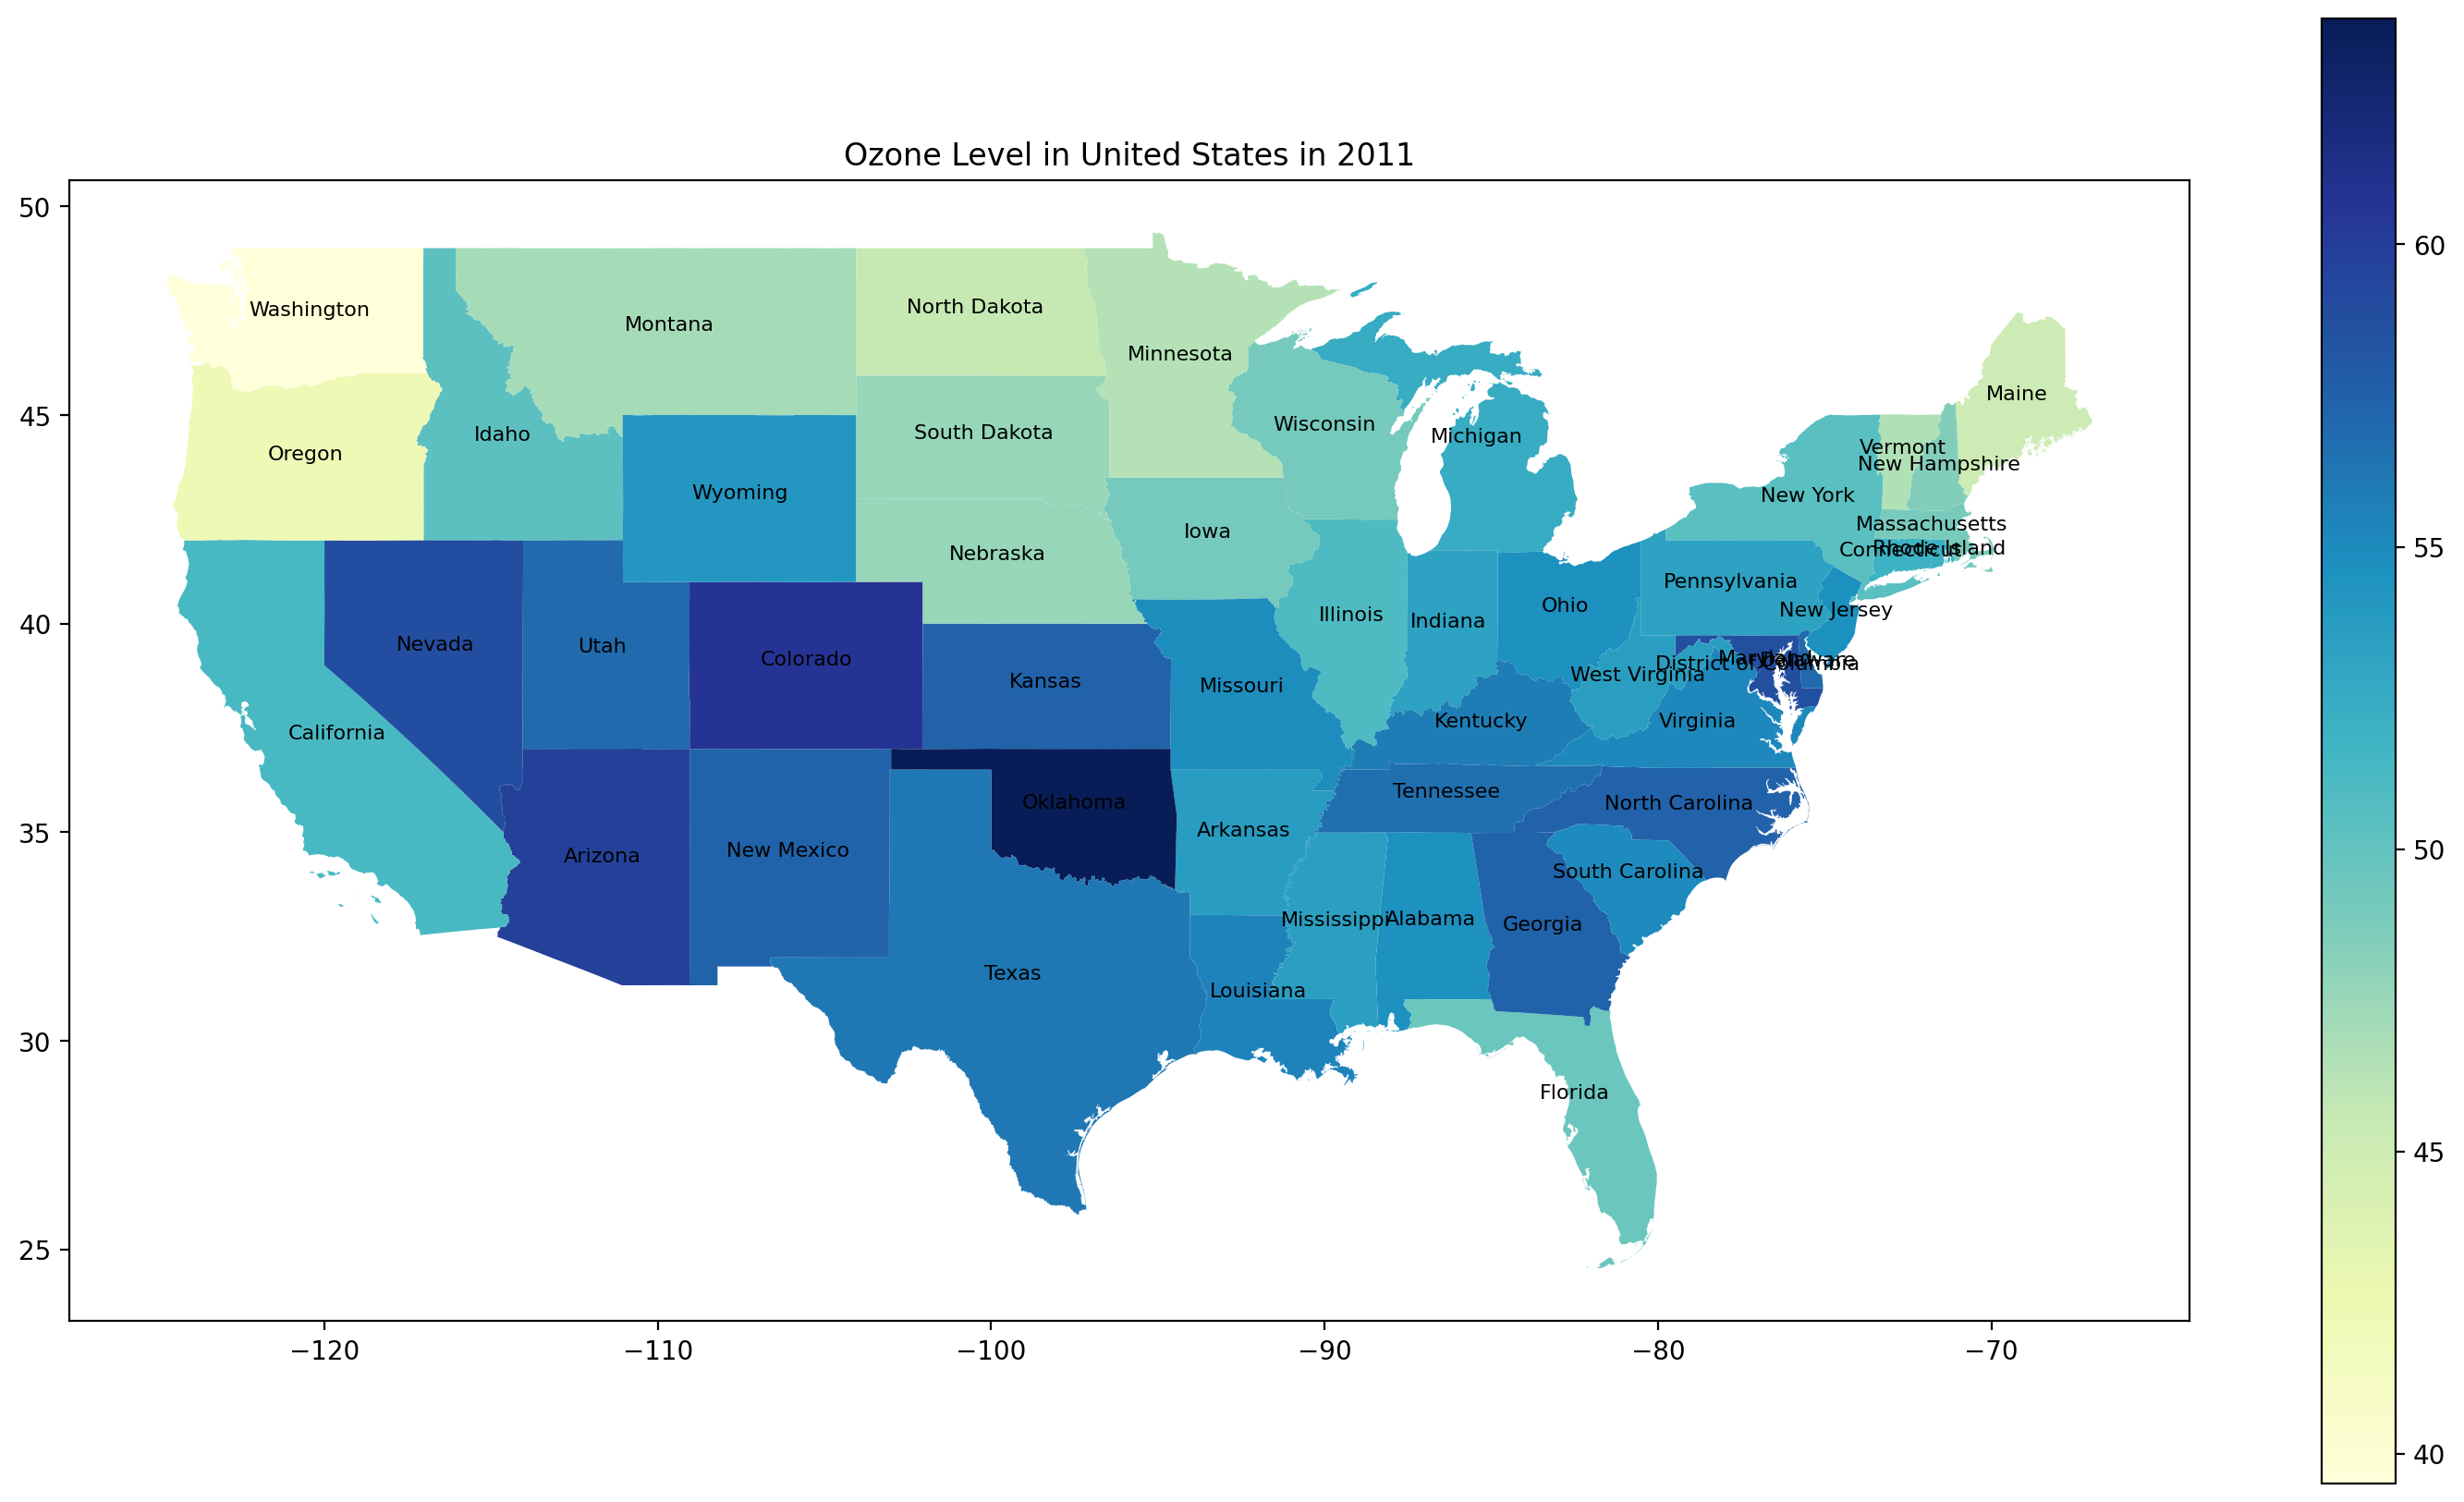

In [29]:
#Graph the 2011 ozone data on map
fig, ax = plt.subplots(1, 1)
st_new.apply(lambda x: ax.annotate(text=x.NAME, xy=x.geometry.centroid.coords[0], ha='center', fontsize=8),axis=1)
st_new.plot(column='ozone 2011', ax=ax, cmap='YlGnBu', legend=True)
plt.title('Ozone Level in United States in 2011')
fig.set_size_inches(18.5, 10.5)
plt.gcf().set_dpi(200)

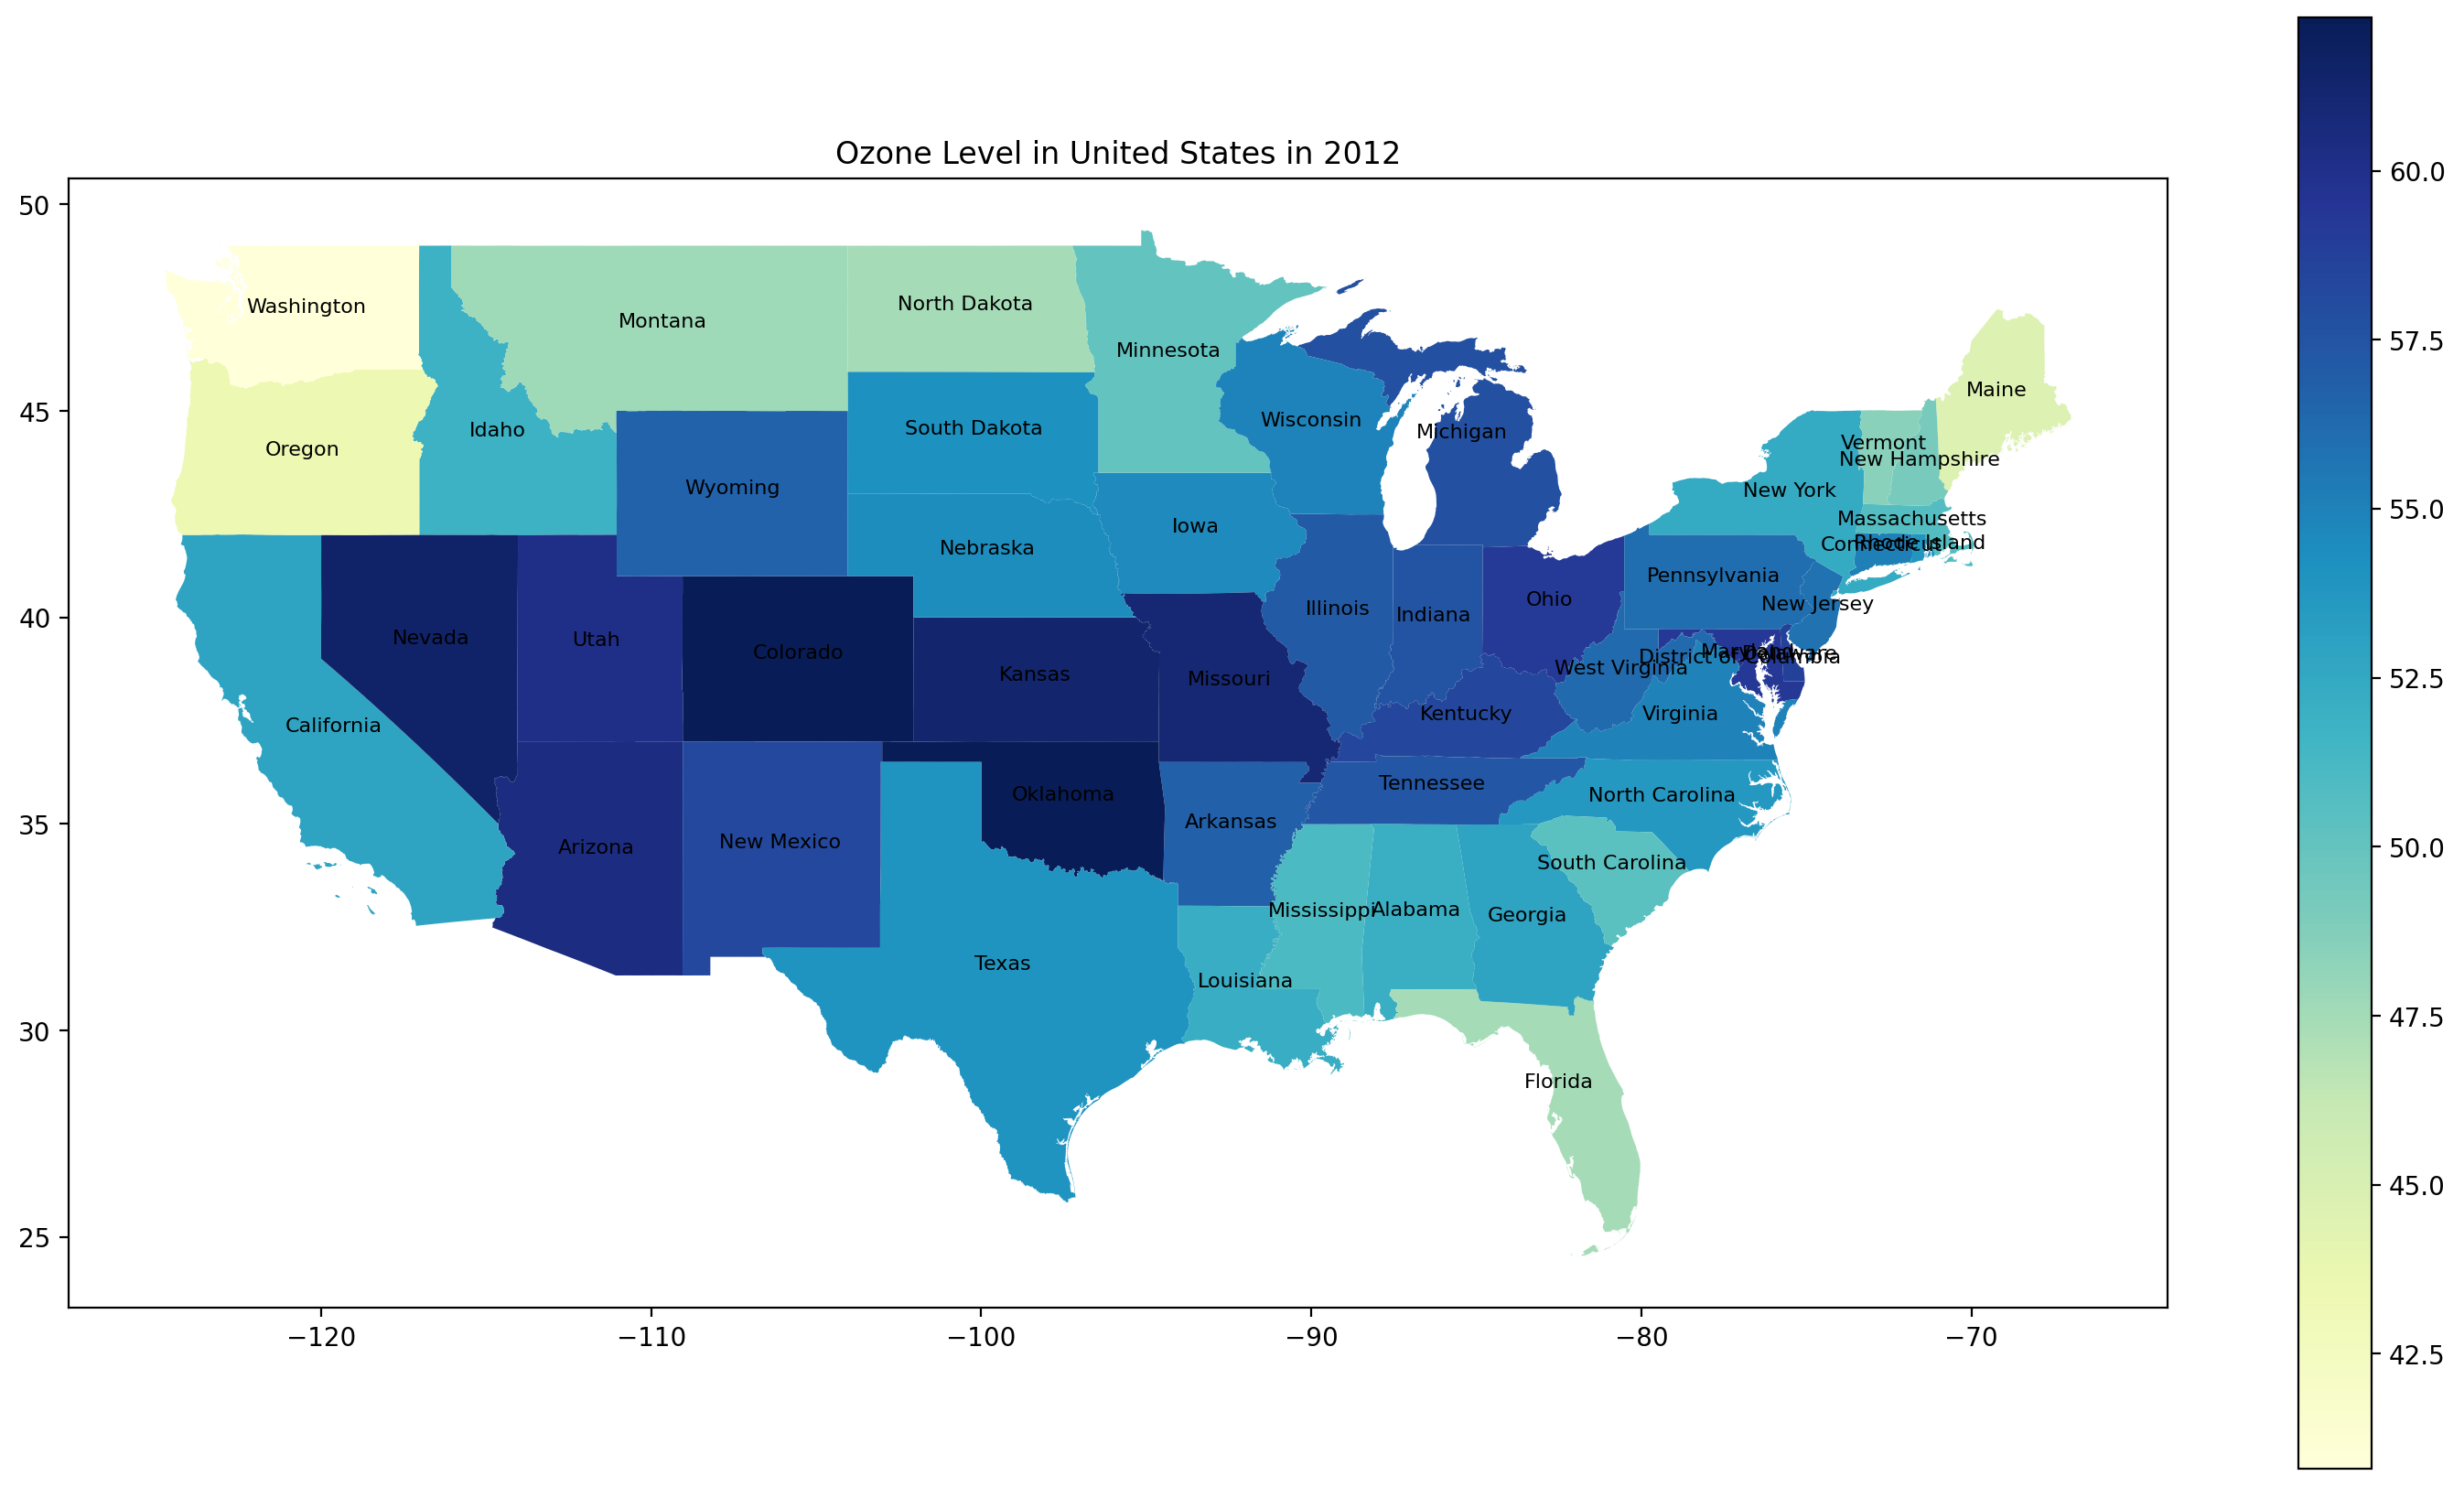

In [30]:
#Graph the 2012 ozone data on map
fig, ax = plt.subplots(1, 1)
st_new.apply(lambda x: ax.annotate(text=x.NAME, xy=x.geometry.centroid.coords[0], ha='center', fontsize=8),axis=1)
st_new.plot(column='ozone 2012', ax=ax, cmap='YlGnBu', legend=True)
plt.title('Ozone Level in United States in 2012')
fig.set_size_inches(18.5, 10.5)
plt.gcf().set_dpi(200)

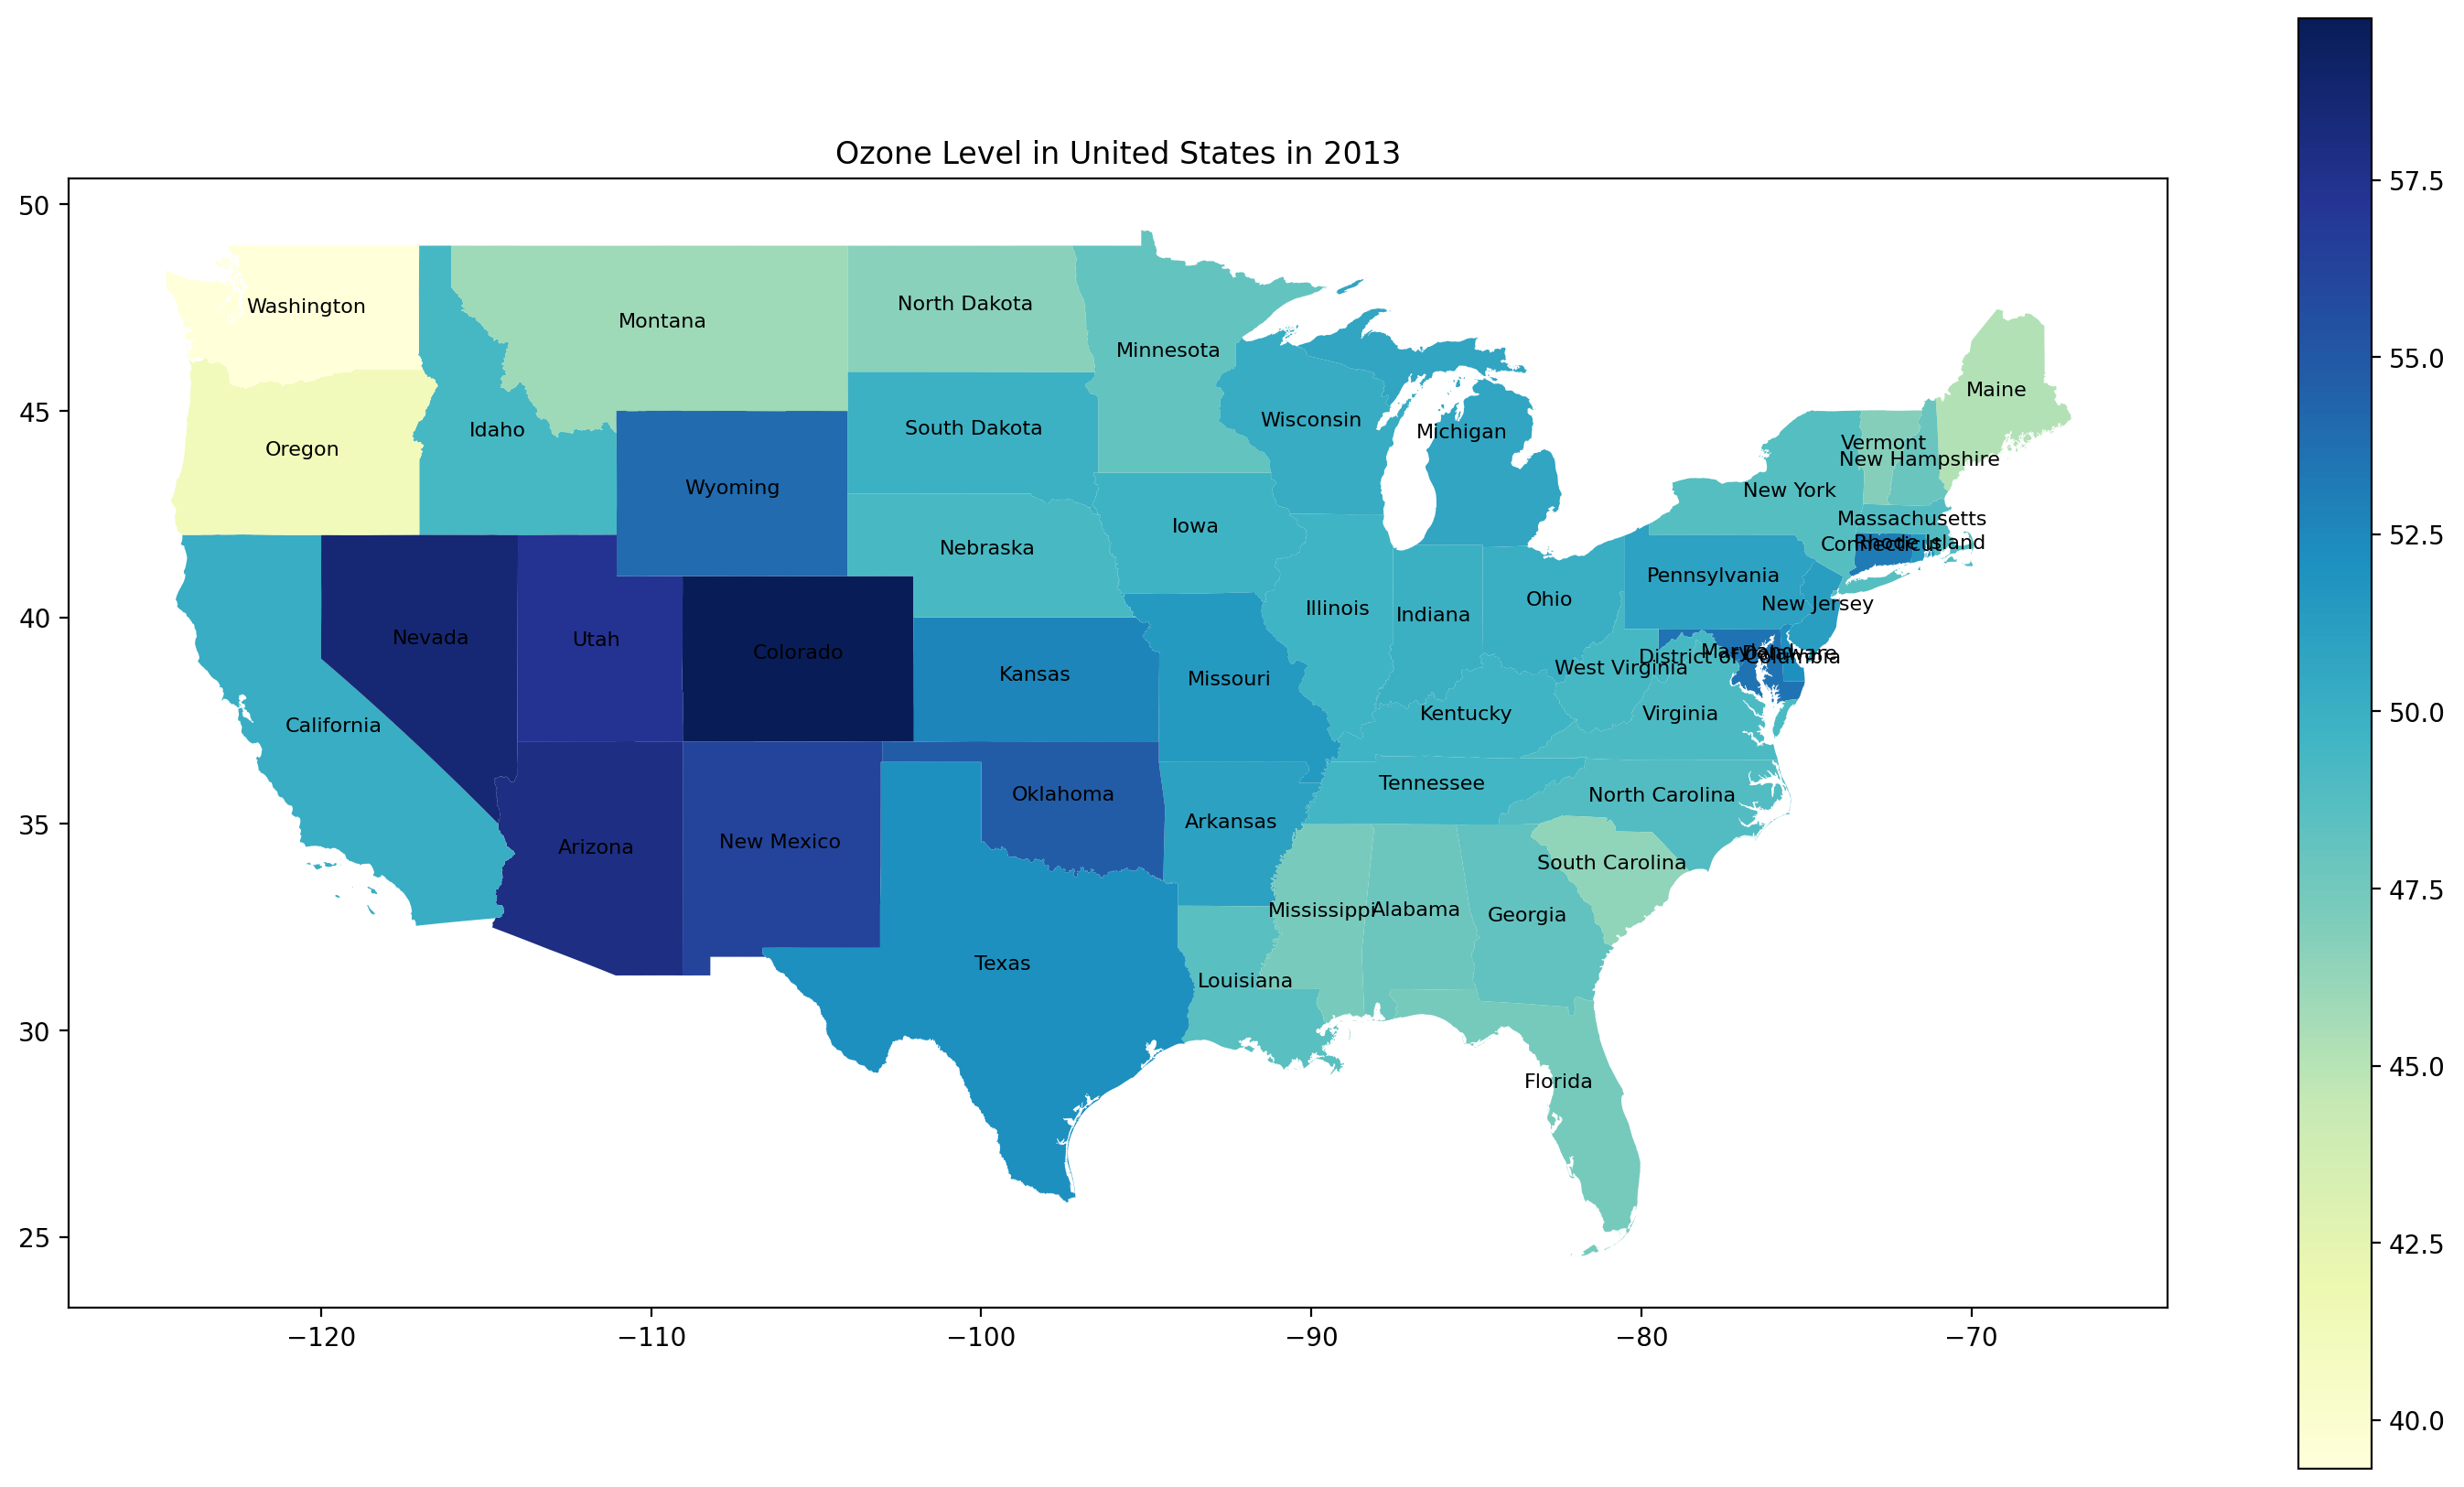

In [31]:
#Graph the 2013 ozone data on map
fig, ax = plt.subplots(1, 1)
st_new.apply(lambda x: ax.annotate(text=x.NAME, xy=x.geometry.centroid.coords[0], ha='center', fontsize=8),axis=1)
st_new.plot(column='ozone 2013', ax=ax, cmap='YlGnBu', legend=True)
plt.title('Ozone Level in United States in 2013')
fig.set_size_inches(18.5, 10.5)
plt.gcf().set_dpi(200)

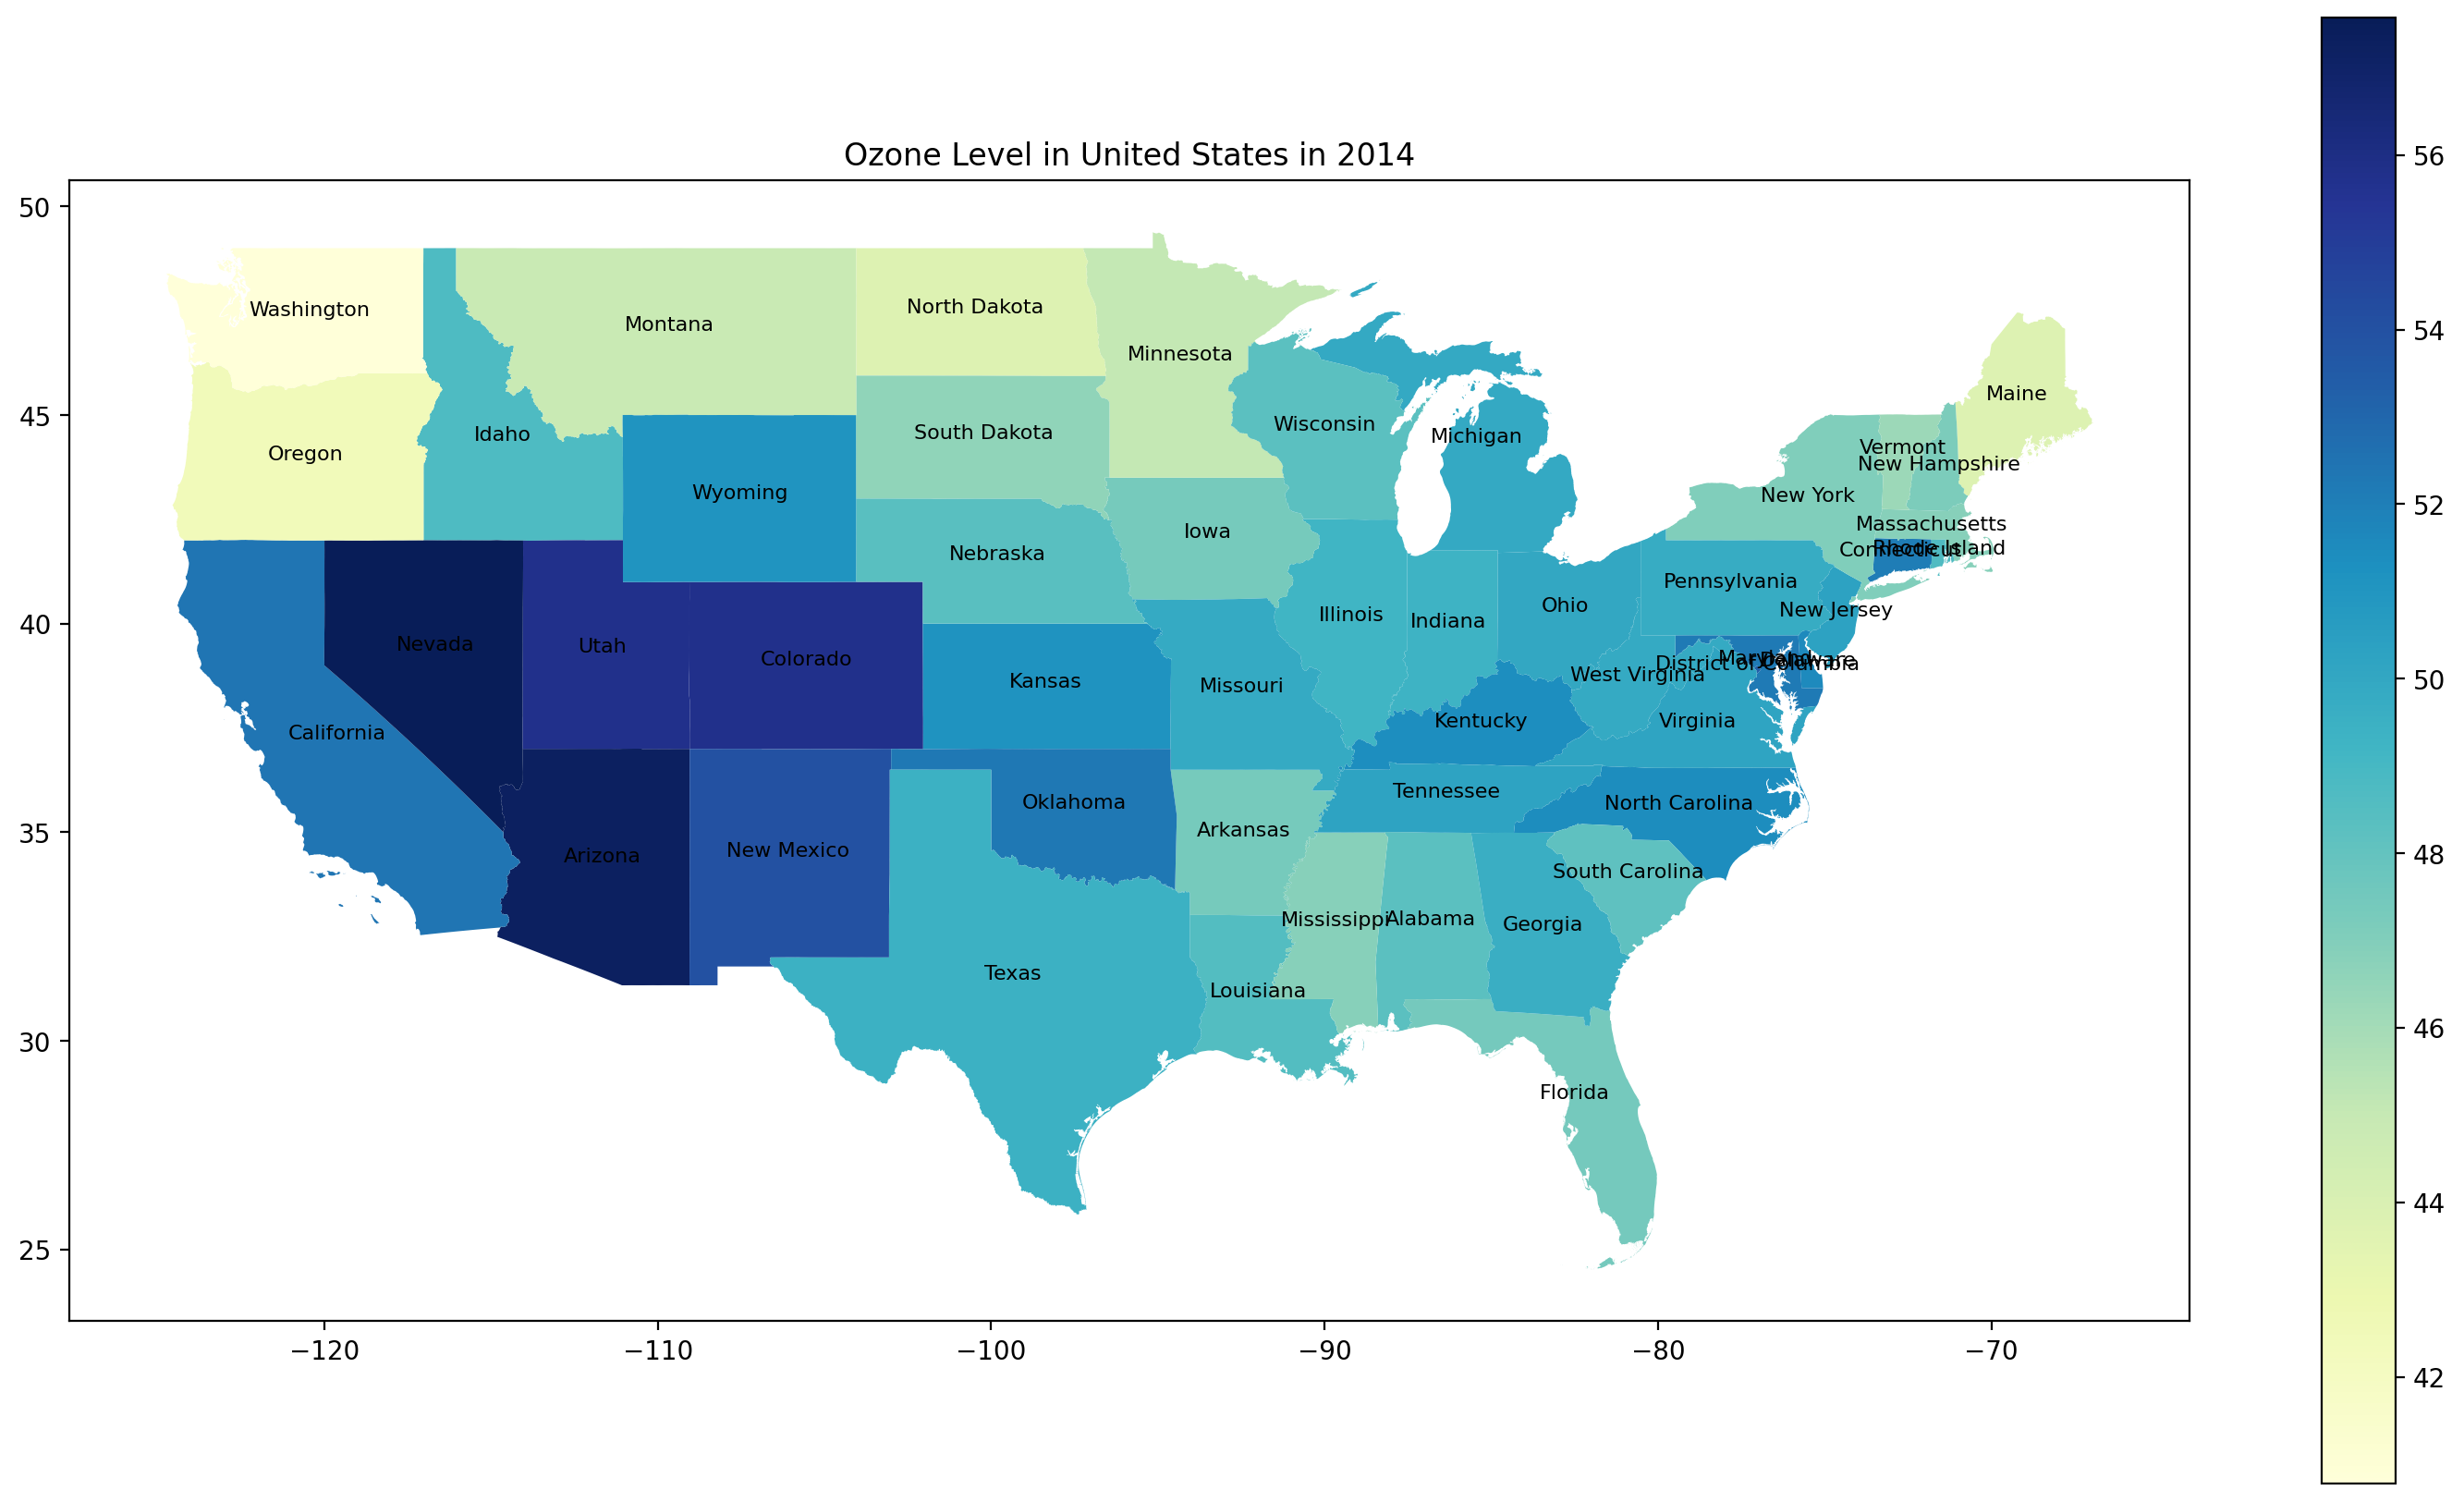

In [32]:
#Graph the 2014 ozone data on map
fig, ax = plt.subplots(1, 1)
st_new.apply(lambda x: ax.annotate(text=x.NAME, xy=x.geometry.centroid.coords[0], ha='center', fontsize=8),axis=1)
st_new.plot(column='ozone 2014', ax=ax, cmap='YlGnBu', legend=True)
plt.title('Ozone Level in United States in 2014')
fig.set_size_inches(18.5, 10.5)
plt.gcf().set_dpi(200)

In [33]:
pm_percentile_average = calculate_upper_30_average(pm_daily_avg, [2011, 2012, 2013, 2014], states_with_climate_measurements, "pm")
pm_percentile_average.columns = ["year", "statefips", "pm"]
pm_percentile_average = pm_percentile_average.sort_values(by = "pm")
pm_percentile_average = geopandas.GeoDataFrame(pm_percentile_average)
pm_percentile_average = pm_percentile_average.sort_values('statefips')

In [34]:
p2011 = pm_percentile_average.loc[pm_percentile_average['year'] == 2011]
p2012 = pm_percentile_average.loc[pm_percentile_average['year'] == 2012]
p2013 = pm_percentile_average.loc[pm_percentile_average['year'] == 2013]
p2014 = pm_percentile_average.loc[pm_percentile_average['year'] == 2014]
p1l = p2011.sort_values('statefips')['pm'].to_list()
p2l = p2012.sort_values('statefips')['pm'].to_list()
p3l = p2013.sort_values('statefips')['pm'].to_list()
p4l = p2014.sort_values('statefips')['pm'].to_list()
st_pm = st_fil.copy()
st_pm['p2011'] = p1l
st_pm['p2012'] = p2l
st_pm['p2013'] = p3l
st_pm['p2014'] = p4l

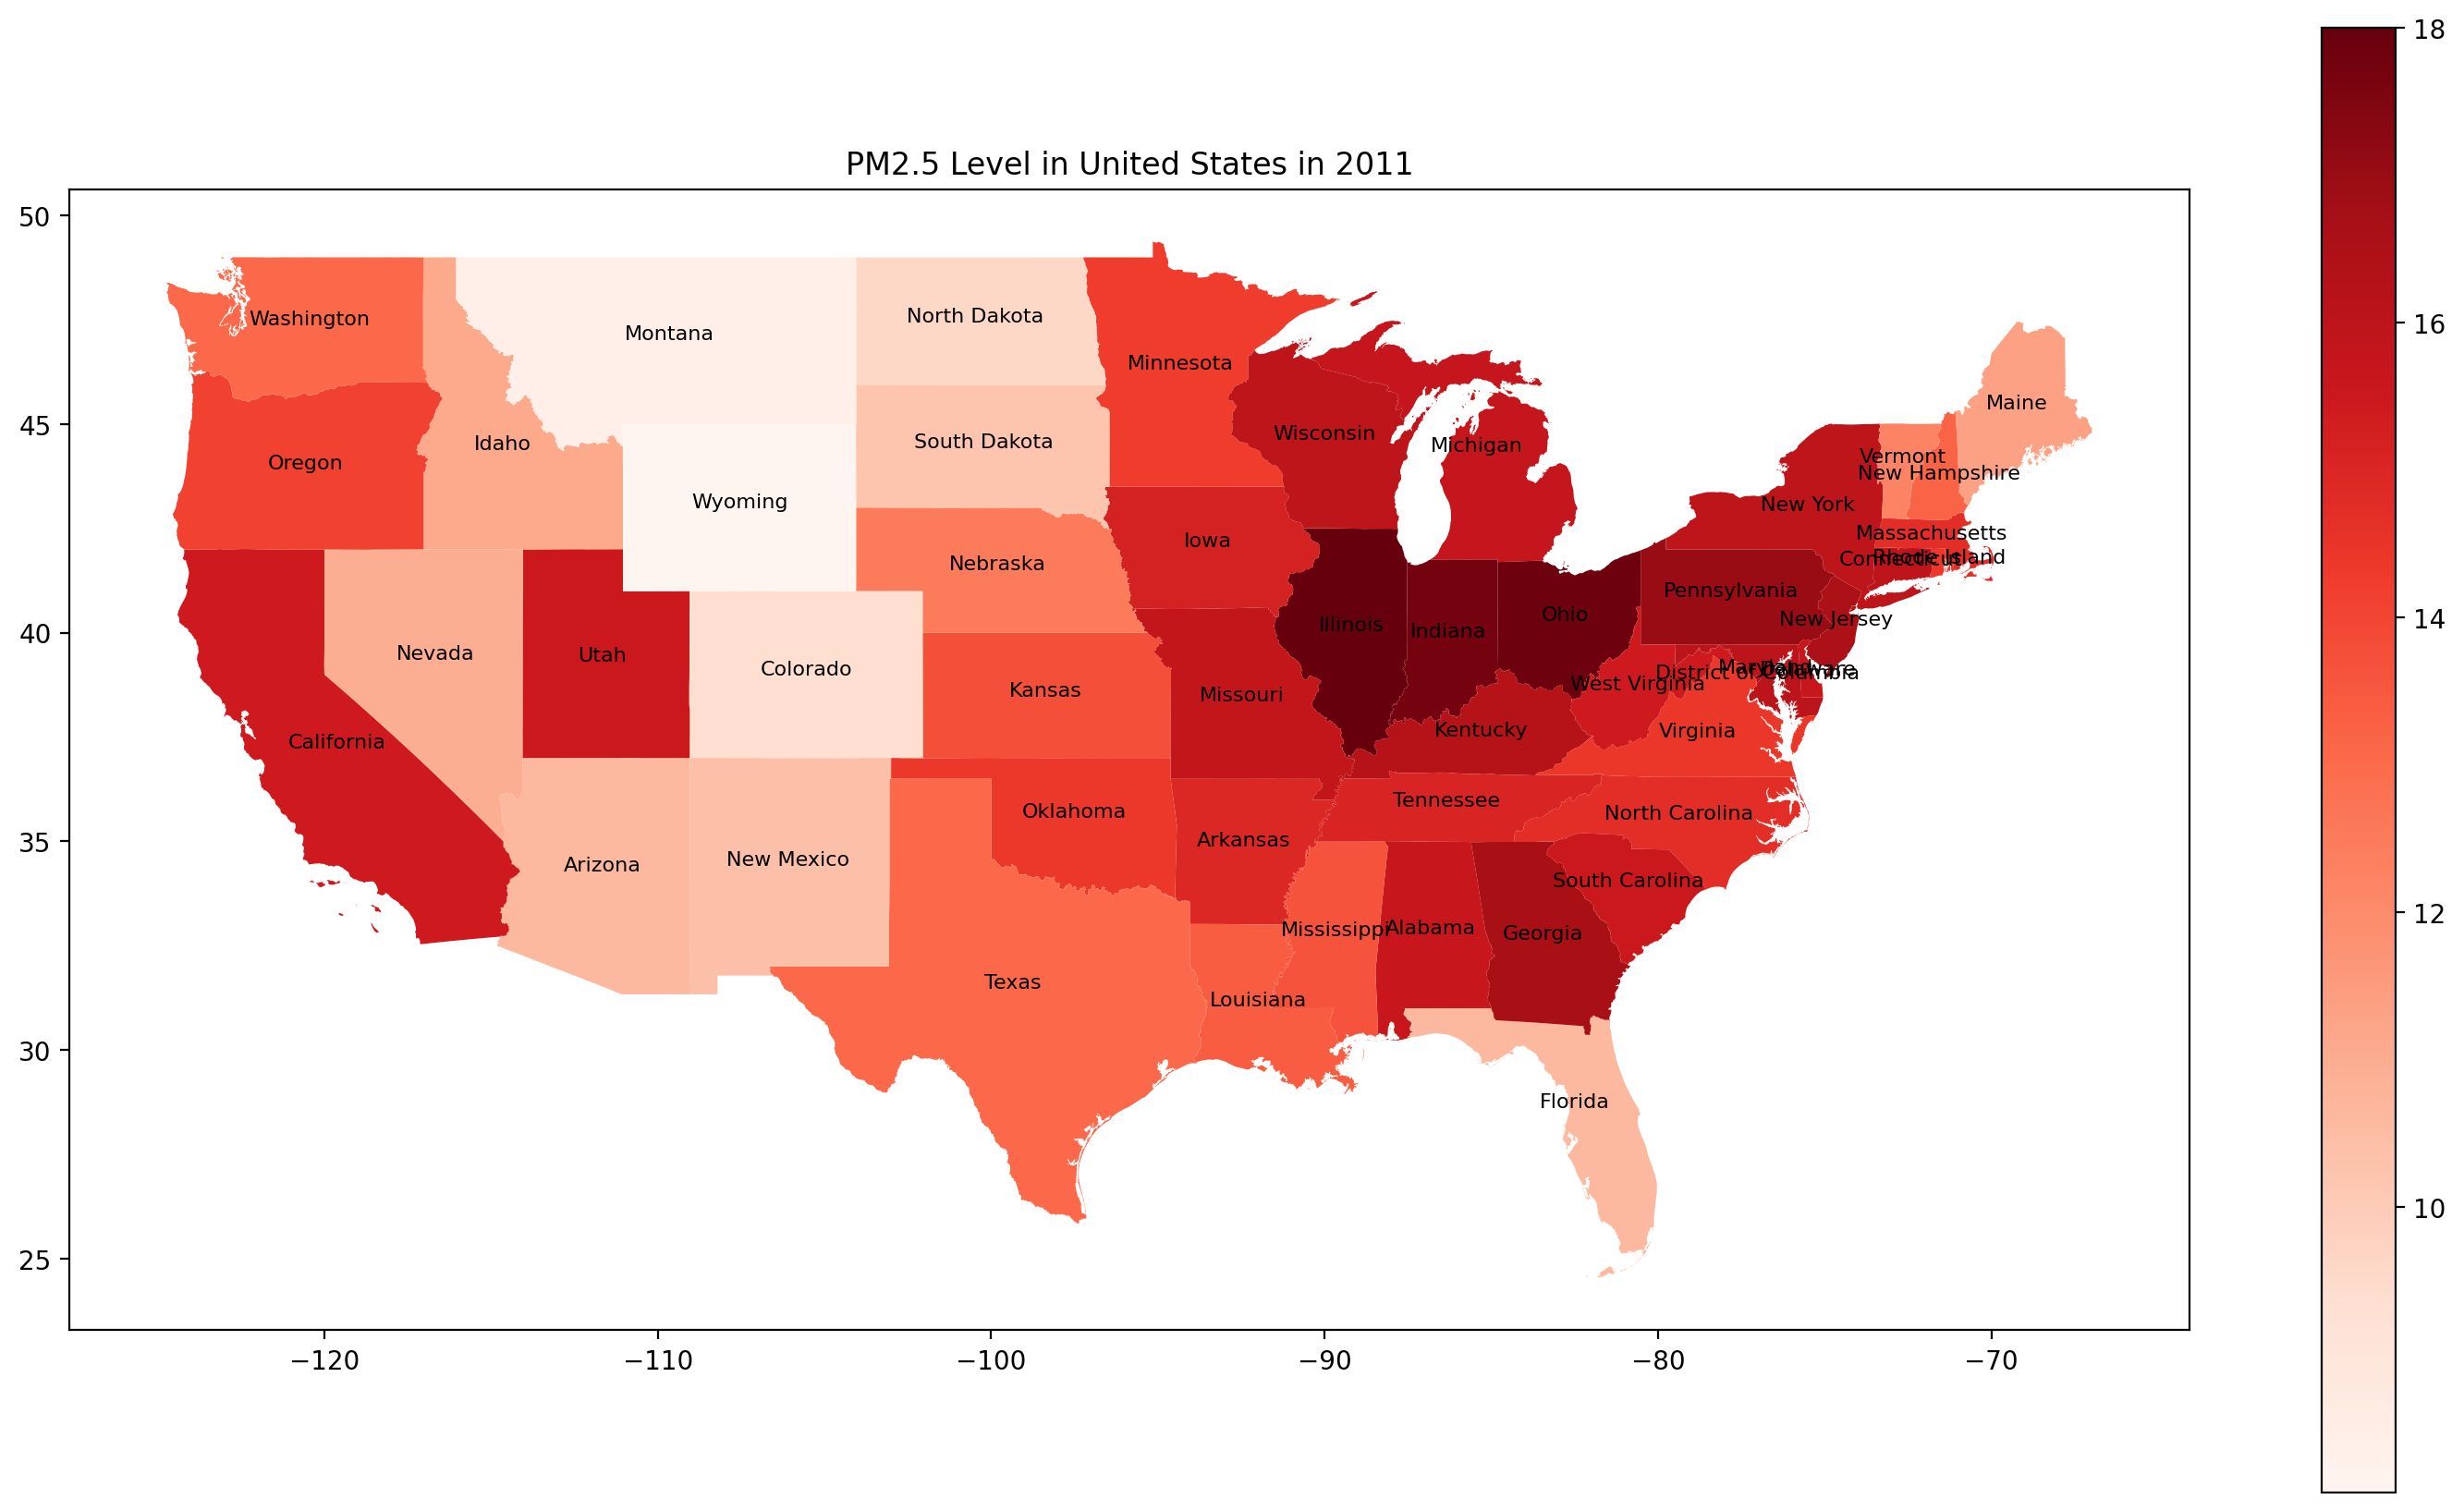

In [35]:
#Graph the 2011 pm2.5 data on map
fig, ax = plt.subplots(1, 1)
st_pm.apply(lambda x: ax.annotate(text=x.NAME, xy=x.geometry.centroid.coords[0], ha='center', fontsize=8),axis=1)
st_pm.plot(column='p2011', ax=ax, cmap='Reds', legend=True)
plt.title('PM2.5 Level in United States in 2011')
fig.set_size_inches(18.5, 10.5)
plt.gcf().set_dpi(200)

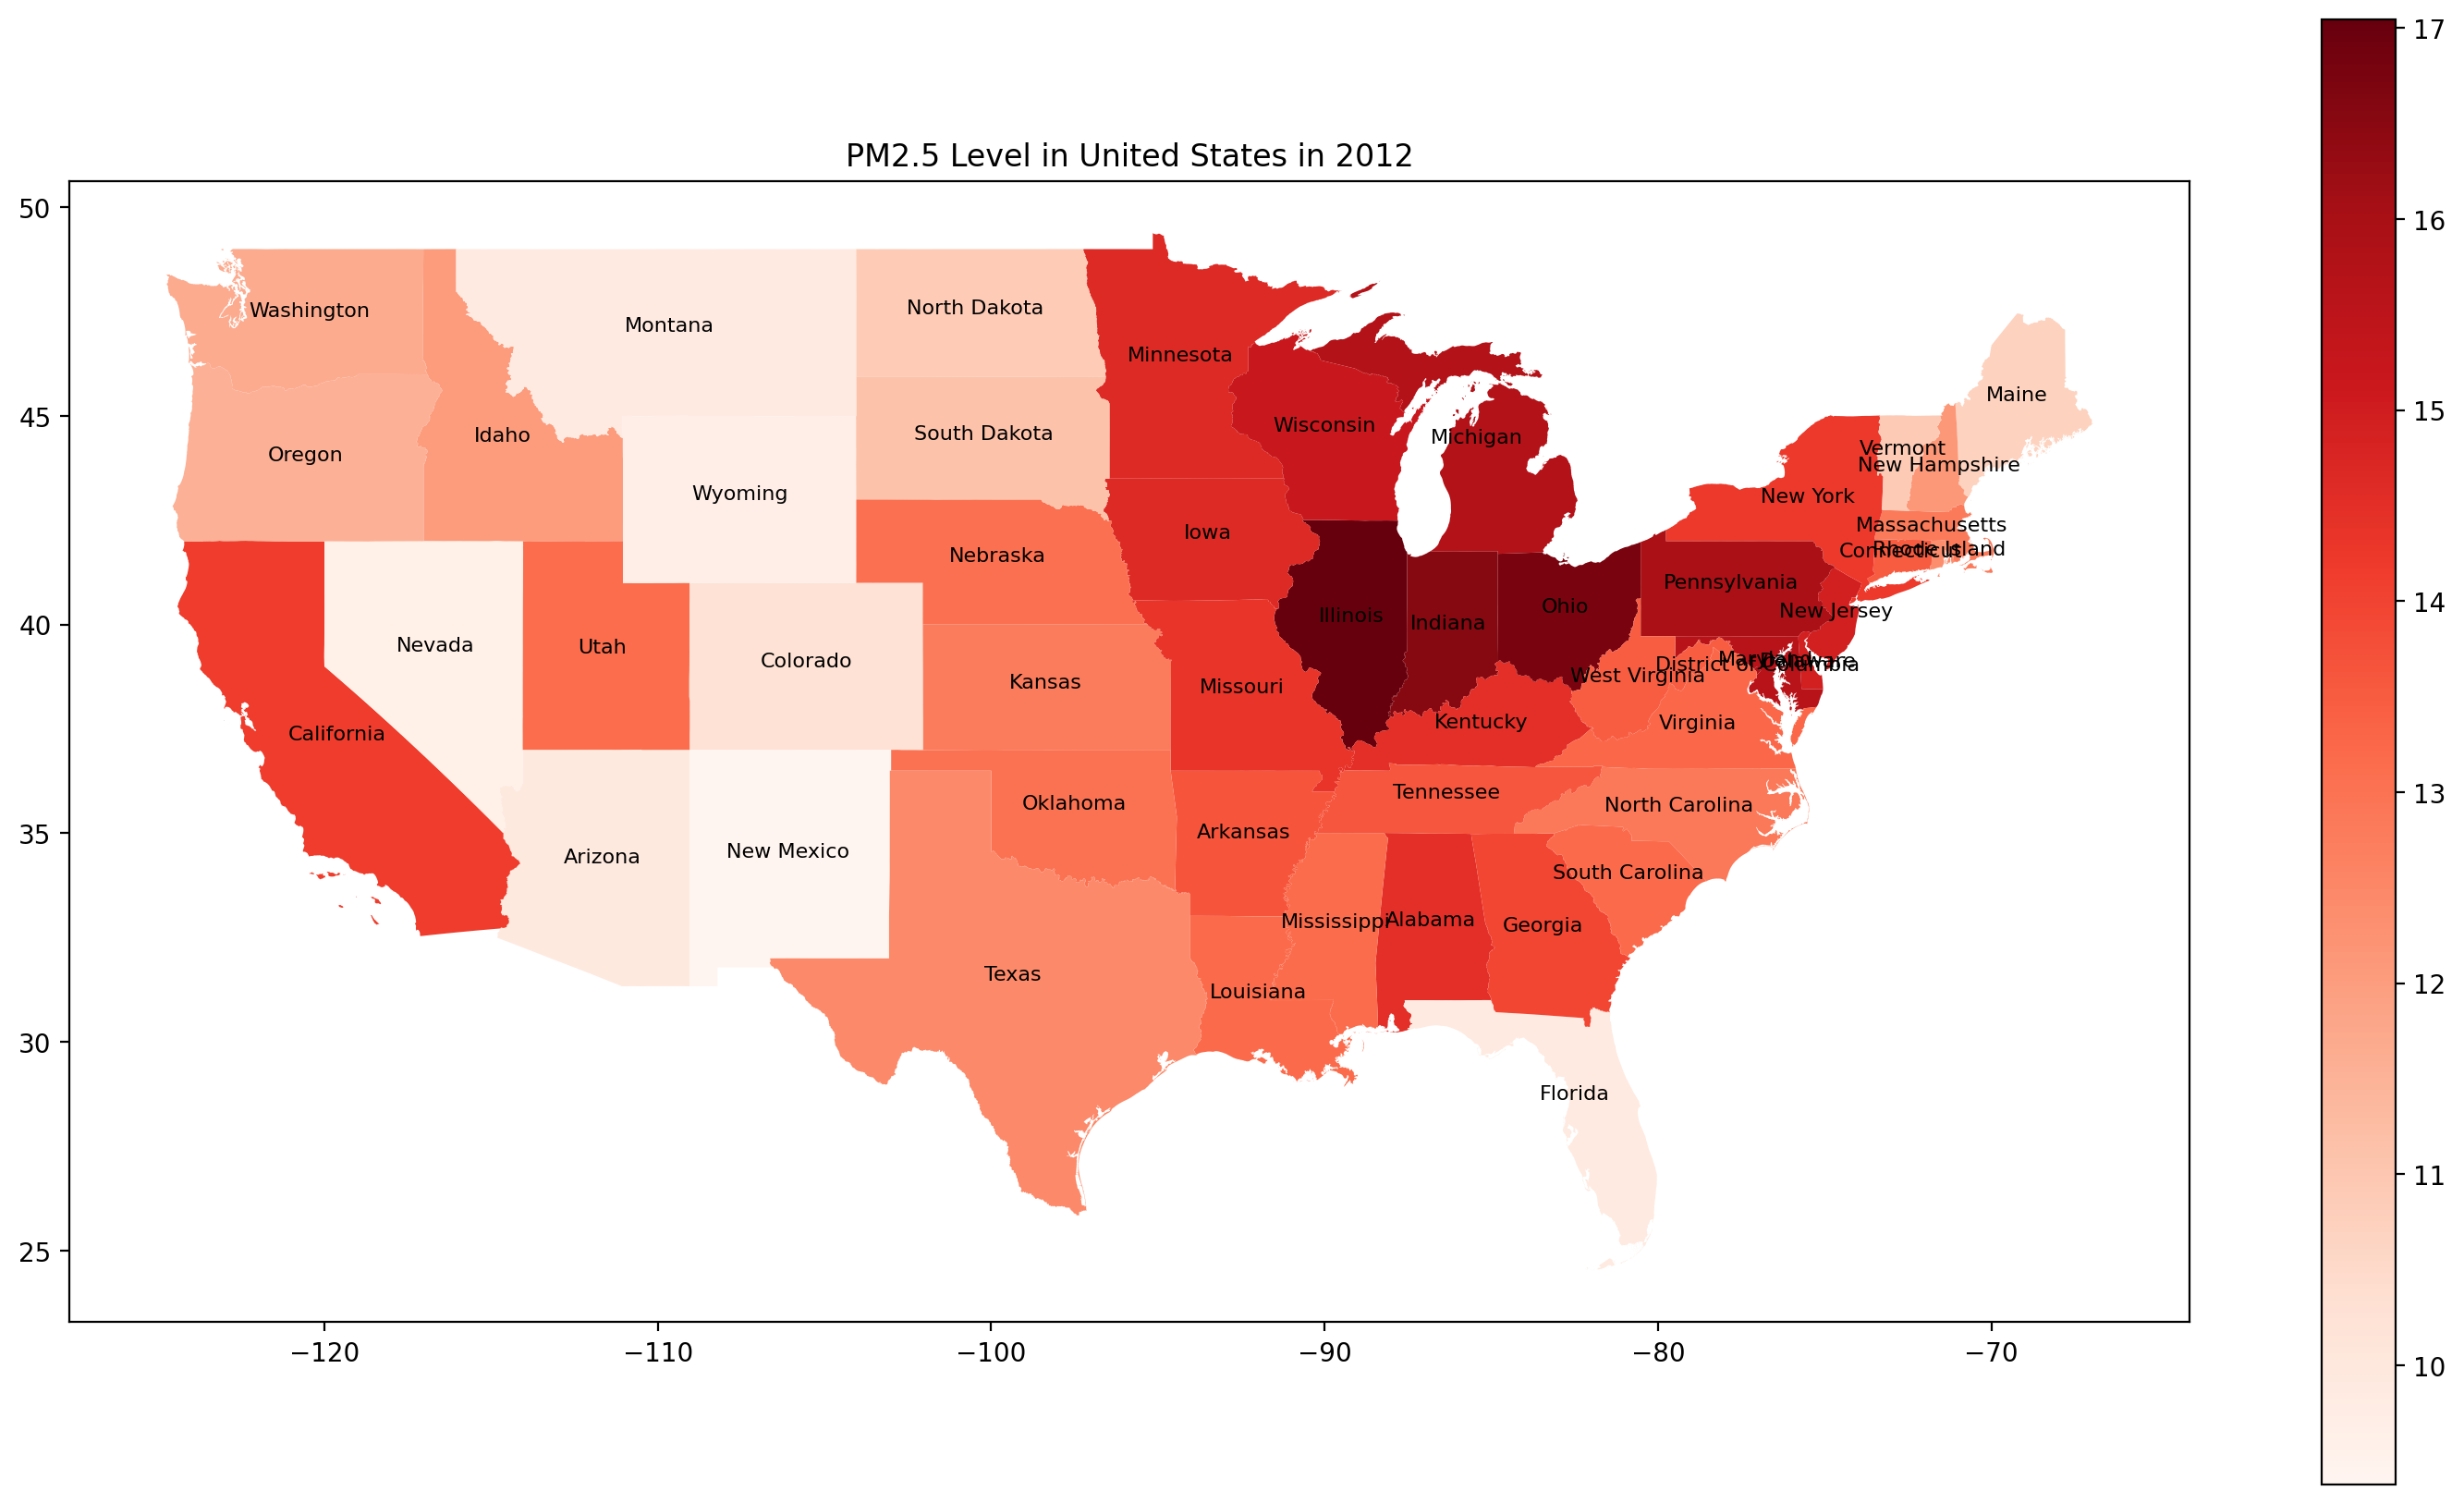

In [36]:
#Graph the 2012 pm2.5 data on map
fig, ax = plt.subplots(1, 1)
st_pm.apply(lambda x: ax.annotate(text=x.NAME, xy=x.geometry.centroid.coords[0], ha='center', fontsize=8),axis=1)
st_pm.plot(column='p2012', ax=ax, cmap='Reds', legend=True)
plt.title('PM2.5 Level in United States in 2012')
fig.set_size_inches(18.5, 10.5)
plt.gcf().set_dpi(200)

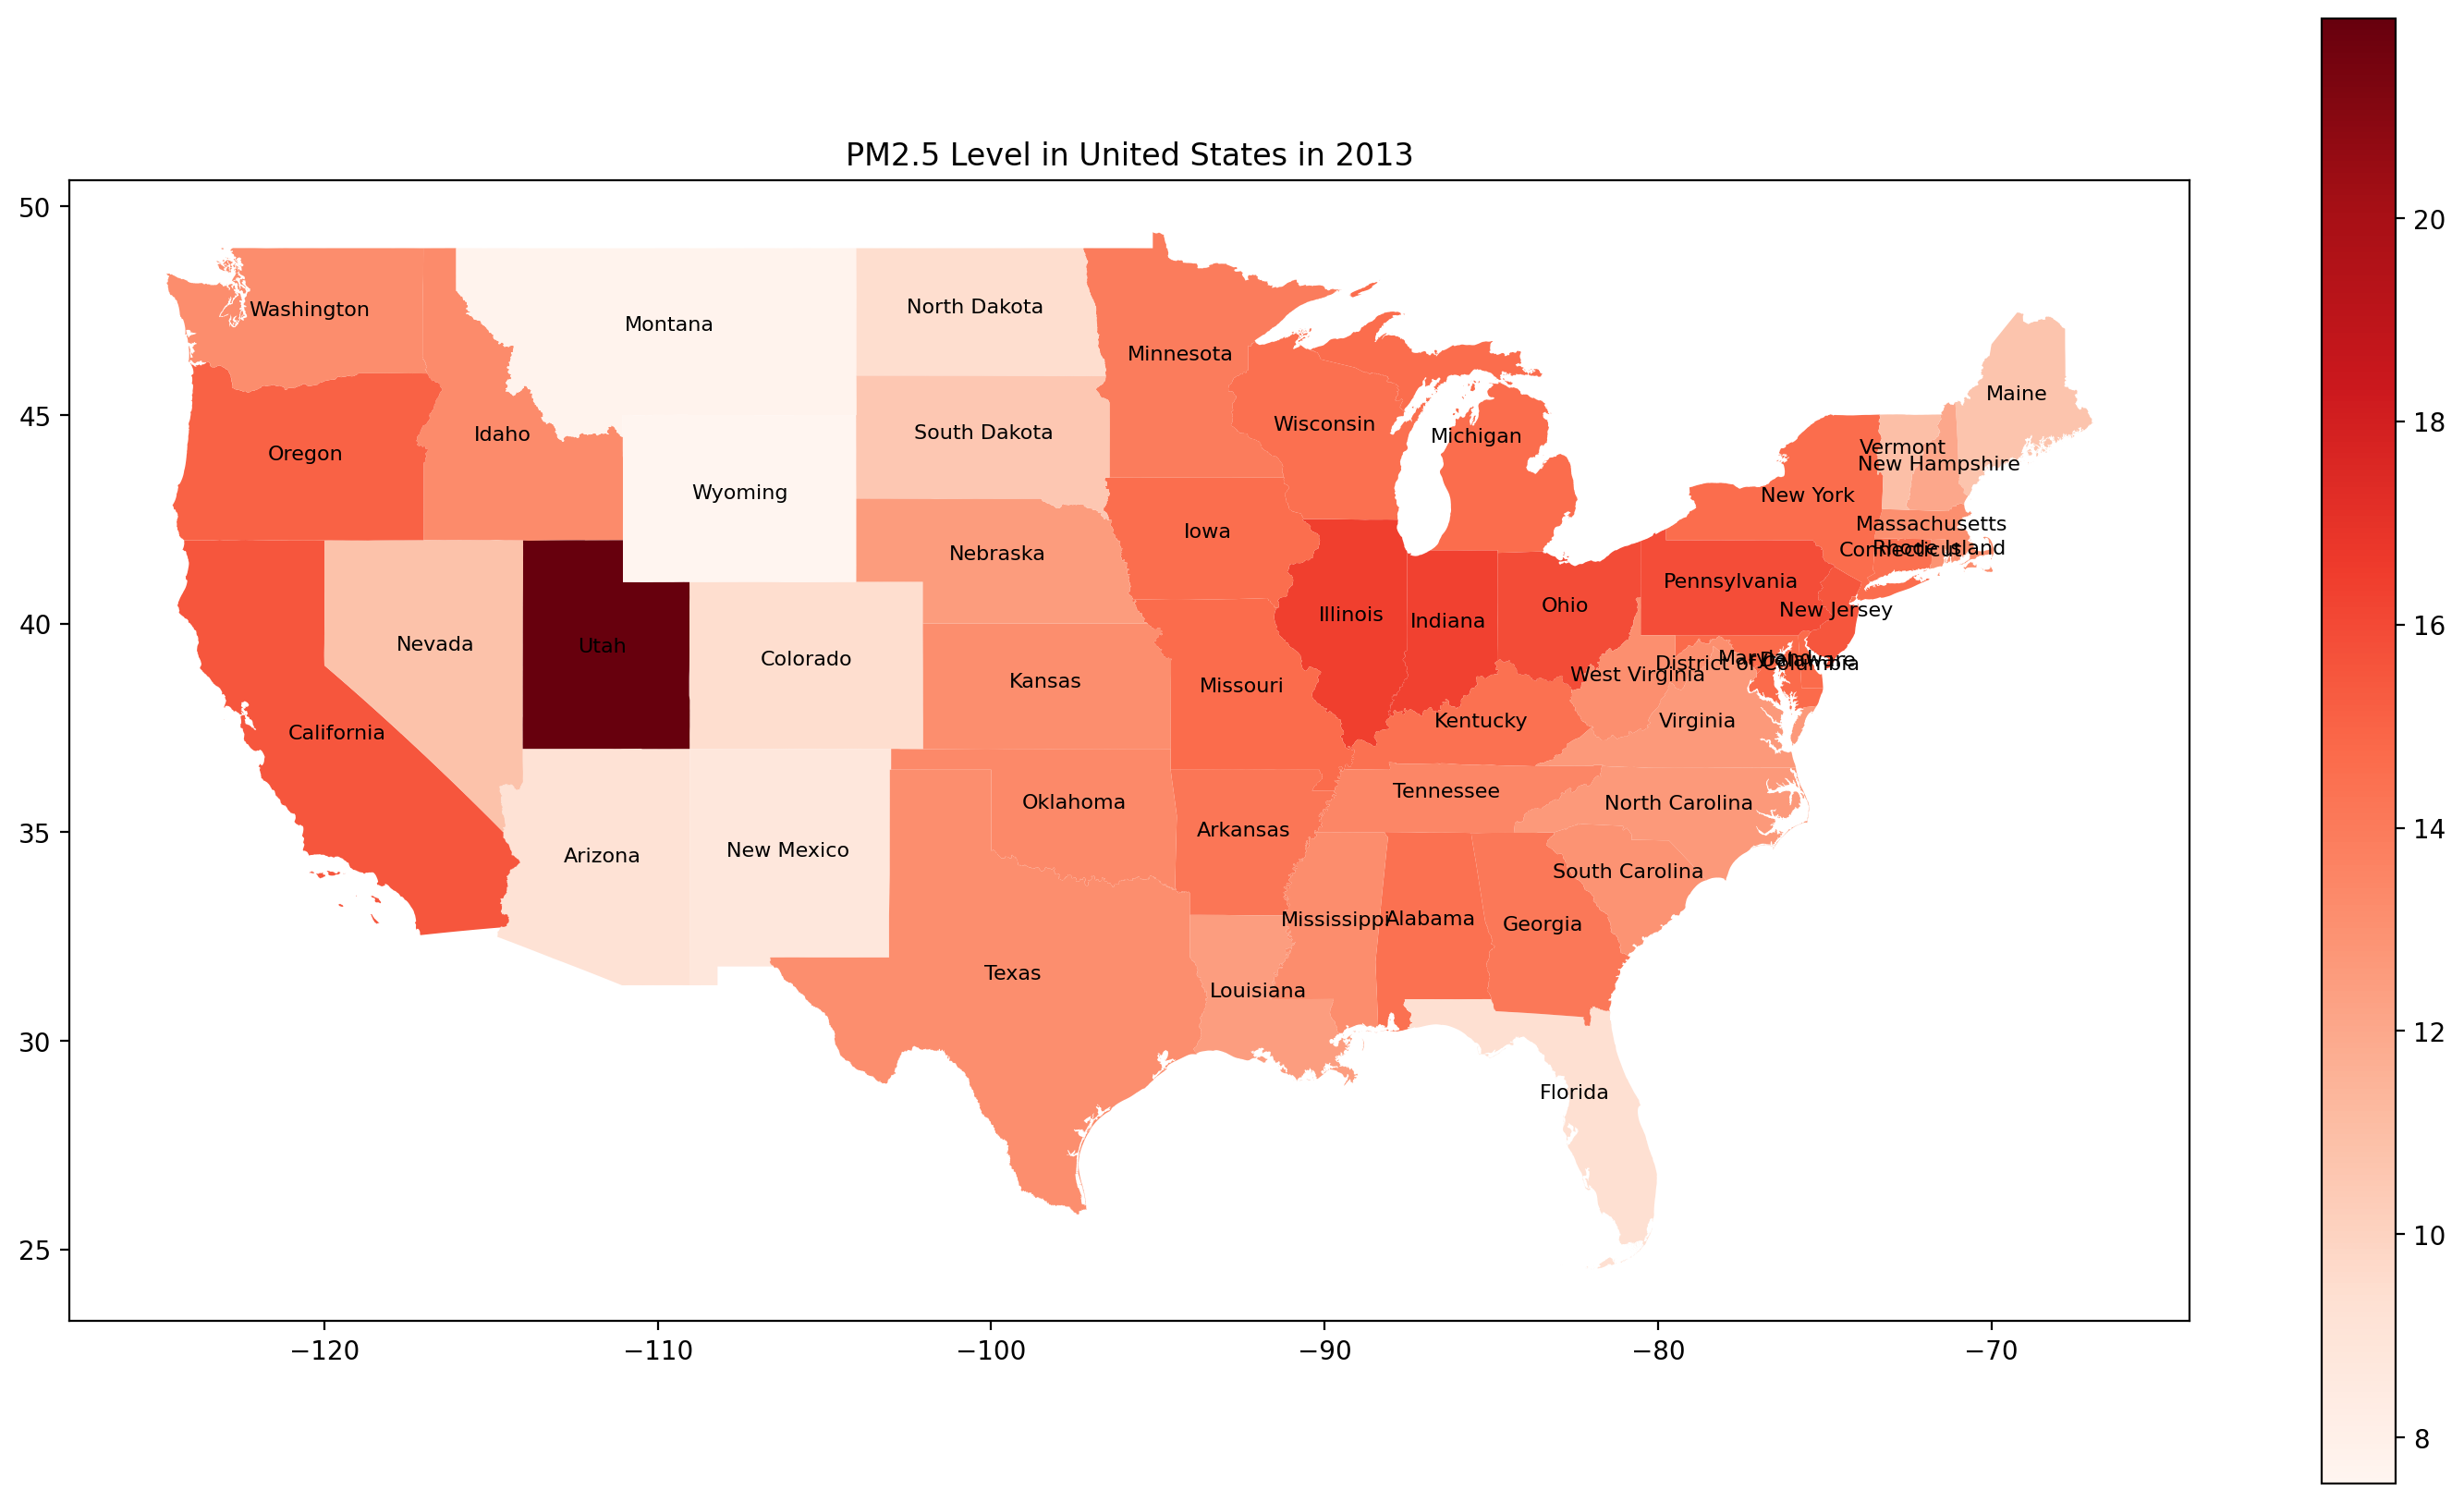

In [37]:
#Graph the 2013 pm2.5 data on map
fig, ax = plt.subplots(1, 1)
st_pm.apply(lambda x: ax.annotate(text=x.NAME, xy=x.geometry.centroid.coords[0], ha='center', fontsize=8),axis=1)
st_pm.plot(column='p2013', ax=ax, cmap='Reds', legend=True)
plt.title('PM2.5 Level in United States in 2013')
fig.set_size_inches(18.5, 10.5)
plt.gcf().set_dpi(200)

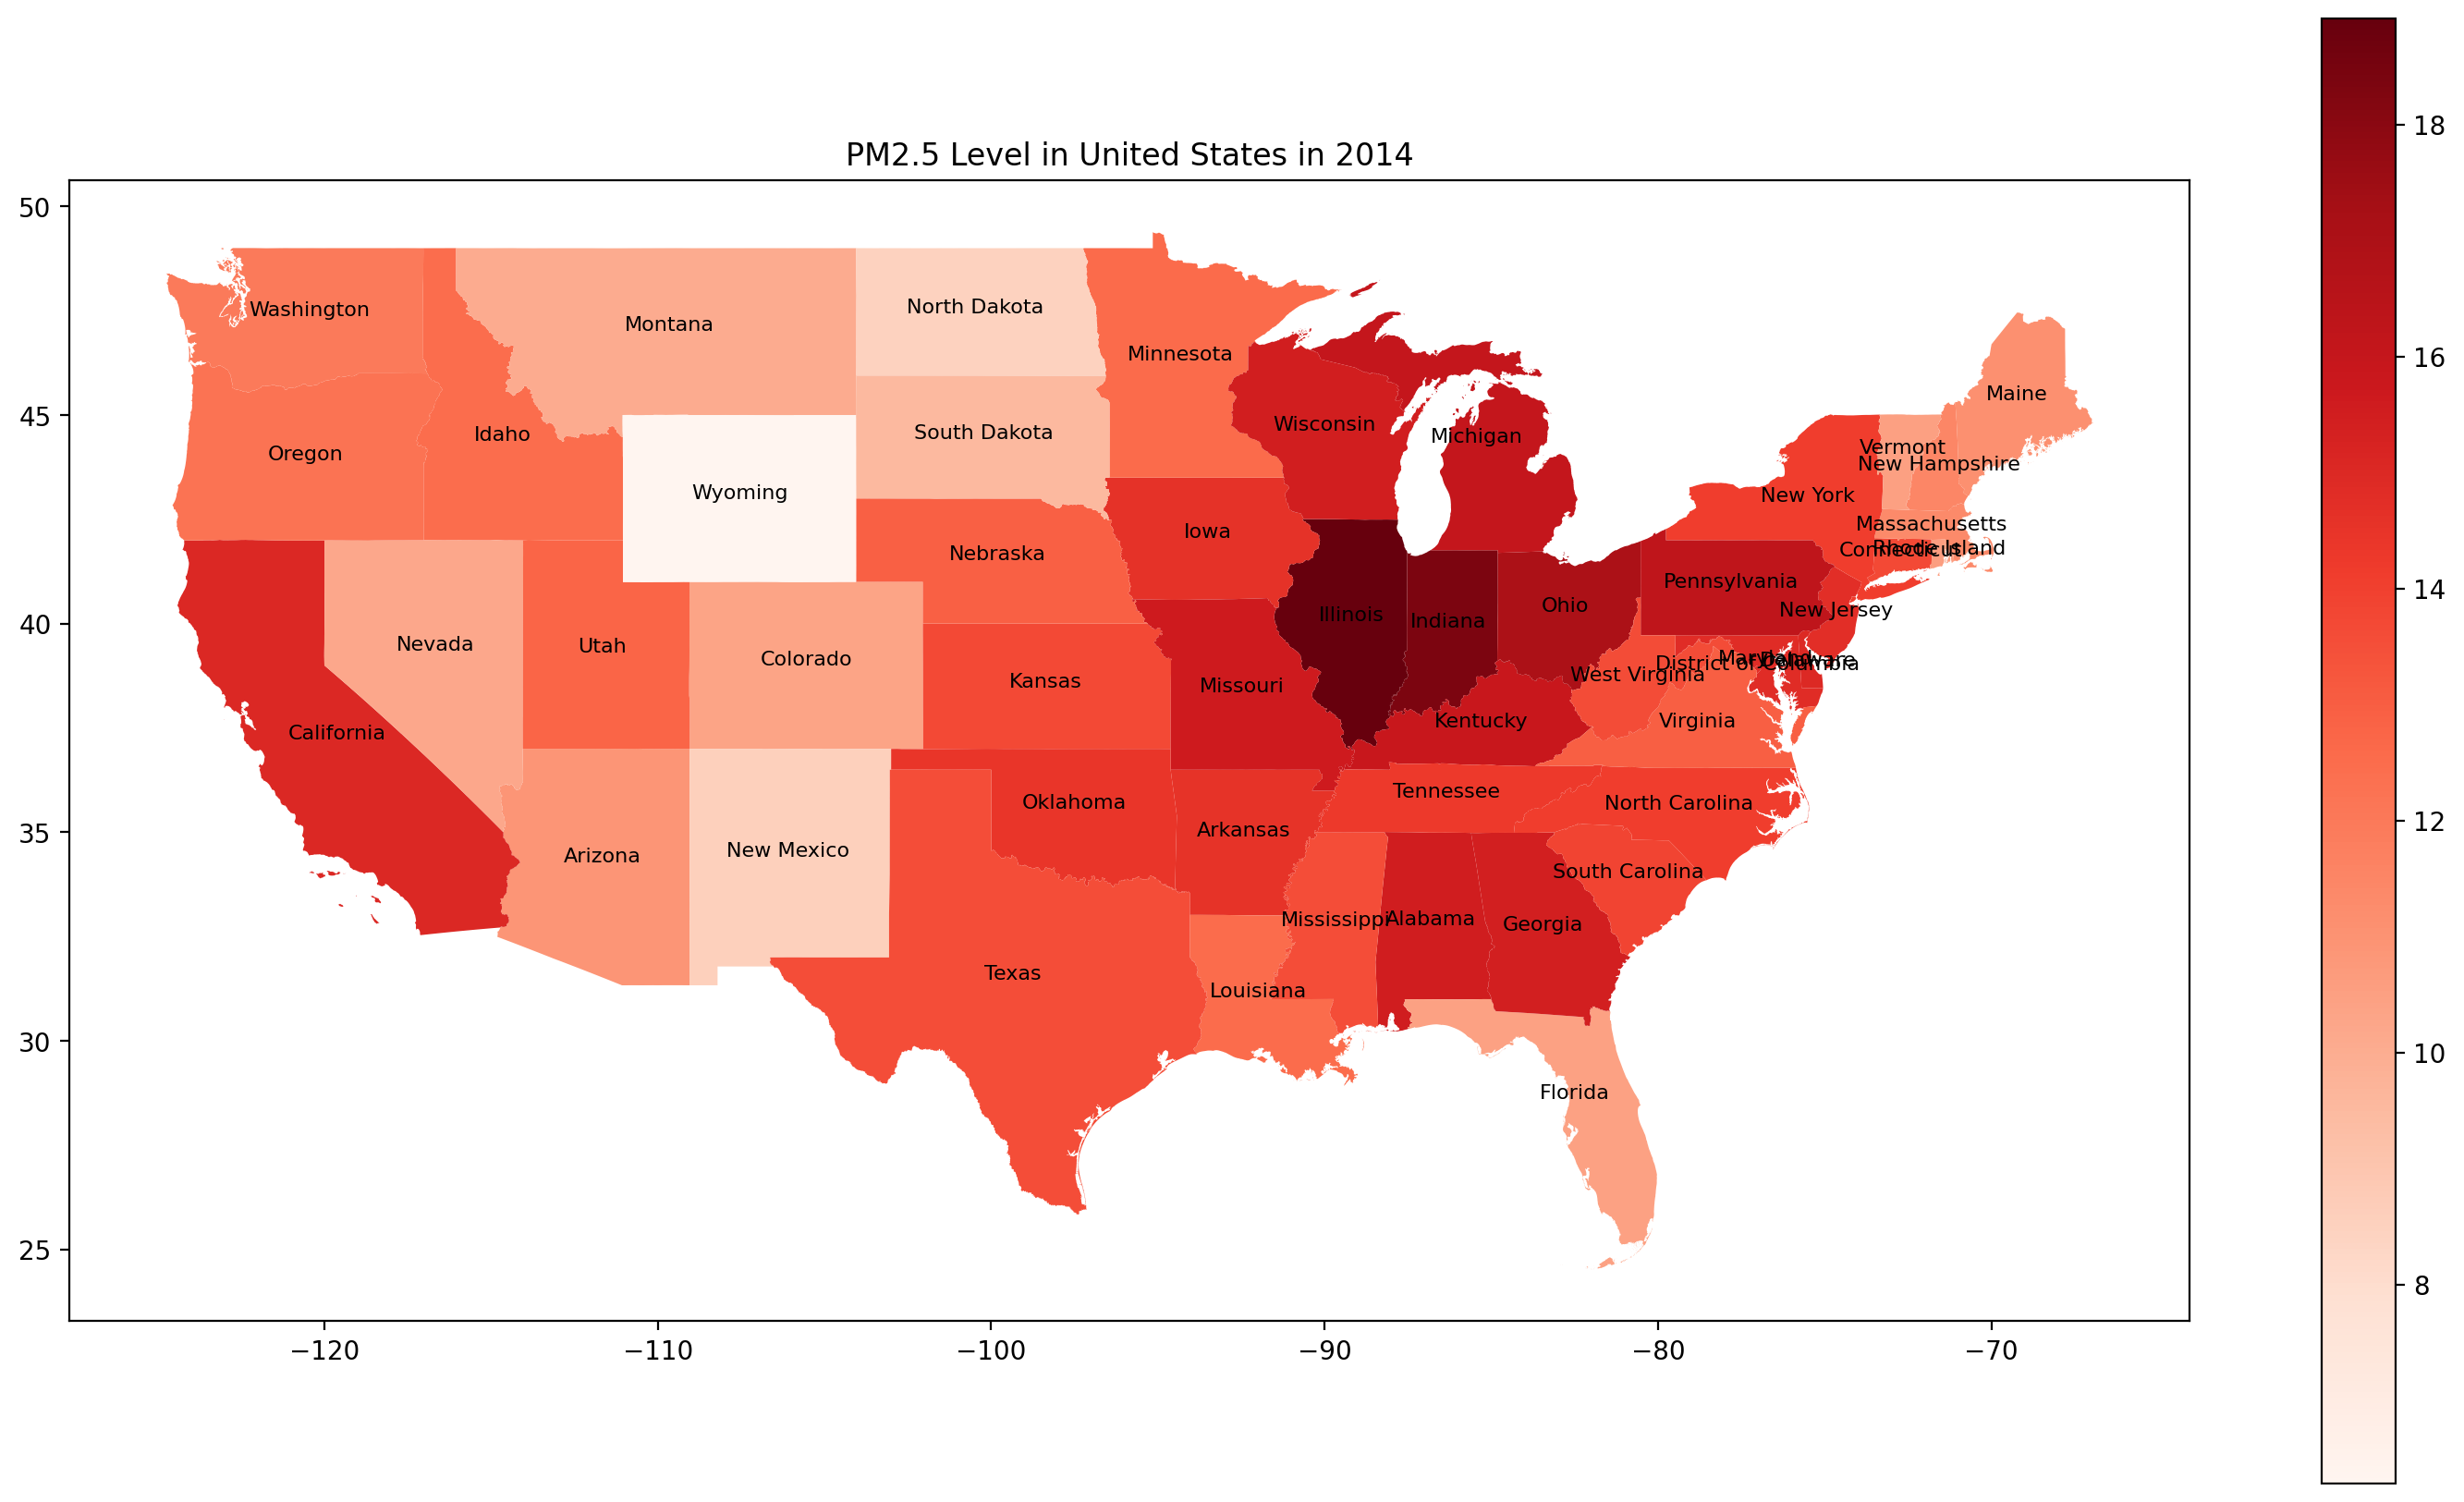

In [38]:
#Graph the 2014 pm2.5 data on map
fig, ax = plt.subplots(1, 1)
st_pm.apply(lambda x: ax.annotate(text=x.NAME, xy=x.geometry.centroid.coords[0], ha='center', fontsize=8),axis=1)
st_pm.plot(column='p2014', ax=ax, cmap='Reds', legend=True)
plt.title('PM2.5 Level in United States in 2014')
fig.set_size_inches(18.5, 10.5)
plt.gcf().set_dpi(200)

## 2.4) For which question and which states we have complete data?

Since we only have PM 2.5 and Ozone measurements from 2011 and 2014 and 49 states, we would limit the diseases into these four years and 49 diseases. Notice, the COPD contains stratified answer for each states. For example, answers are stratified into Race, Gender and Overall. For generality, we focus on overall category in our study.

In [39]:
questions = copd["Question"].unique()
questions

array(['Prevalence of chronic obstructive pulmonary disease among adults >= 18',
       'Hospitalization for chronic obstructive pulmonary disease as first-listed diagnosis among Medicare-eligible persons aged >= 65 years',
       'Hospitalization for chronic obstructive pulmonary disease as any diagnosis among Medicare-eligible persons aged >= 65 years',
       'Mortality with chronic obstructive pulmonary disease as underlying cause among adults aged >= 45 years',
       'Mortality with chronic obstructive pulmonary disease as underlying or contributing cause among adults aged >= 45 years',
       'Emergency department visit rate for chronic obstructive pulmonary disease as first-listed diagnosis',
       'Emergency department visit rate for chronic obstructive pulmonary disease as any diagnosis',
       'Hospitalization for chronic obstructive pulmonary disease as first-listed diagnosis',
       'Hospitalization for chronic obstructive pulmonary disease as any diagnosis',
       'Pr

In [40]:
## Filter into 2011-2014, 49 states, overall category

copd_overall = copd[copd["StratificationCategory1"] == "Overall"]
copd_overall_limit_states = copd_overall[copd_overall["LocationAbbr"].isin(states_name_with_climate_measurement)]
copd_overall_limit_states = copd_overall_limit_states[copd_overall_limit_states["YearStart"].isin([2011, 2012, 2013, 2014])]
copd_overall_limit_states

YearStart  YearEnd LocationAbbr   LocationDesc  \
0            2014     2014           AZ        Arizona   
17           2011     2011           MI       Michigan   
20           2014     2014           MI       Michigan   
28           2011     2011           FL        Florida   
29           2011     2011           MO       Missouri   
...           ...      ...          ...            ...   
127232       2011     2011           UT           Utah   
127273       2014     2014           IA           Iowa   
127289       2012     2012           MT        Montana   
127294       2013     2013           NE       Nebraska   
127340       2014     2014           NH  New Hampshire   

                    DataSource                                  Topic  \
0                        BRFSS  Chronic Obstructive Pulmonary Disease   
17      CMS Part A Claims Data  Chronic Obstructive Pulmonary Disease   
20      CMS Part A Claims Data  Chronic Obstructive Pulmonary Disease   
28      CMS Part A Claims Data  Chronic Obstructive Pulmonary Disease   
29      CMS Part A Claims Data  Chronic Obstructive Pulmonary Disease   
...                        ...                                    ...   
127232                   BRFSS  Chronic Obstructive Pulmonary Disease   
127273                   BRFSS  Chronic Obstructive Pulmonary Disease   
127289                   BRFSS  Chronic Obstructive Pulmonary Disease   
127294                   BRFSS  Chronic Obstructive Pulmonary Disease   
127340                   BRFSS  Chronic Obstructive Pulmonary Disease   

                                                 Question  Response  \
0       Prevalence of chronic obstructive pulmonary di...       NaN   
17      Hospitalization for chronic obstructive pulmon...       NaN   
20      Hospitalization for chronic obstructive pulmon...       NaN   
28      Hospitalization for chronic obstructive pulmon...       NaN   
29      Hospitalization for chronic obstructive pulmon...       NaN   
...                                                   ...       ...   
127232  Pneumococcal vaccination among noninstitutiona...       NaN   
127273  Pneumococcal vaccination among noninstitutiona...       NaN   
127289  Pneumococcal vaccination among noninstitutiona...       NaN   
127294  Pneumococcal vaccination among noninstitutiona...       NaN   
127340  Pneumococcal vaccination among noninstitutiona...       NaN   

          DataValueUnit     DataValueType  ...  LocationID  TopicID  \
0                     %  Crude Prevalence  ...           4     COPD   
17      cases per 1,000        Crude Rate  ...          26     COPD   
20      cases per 1,000        Crude Rate  ...          26     COPD   
28                  NaN            Number  ...          12     COPD   
29      cases per 1,000        Crude Rate  ...          29     COPD   
...                 ...               ...  ...         ...      ...   
127232                %  Crude Prevalence  ...          49     COPD   
127273                %  Crude Prevalence  ...          19     COPD   
127289                %  Crude Prevalence  ...          30     COPD   
127294                %  Crude Prevalence  ...          31     COPD   
127340                %  Crude Prevalence  ...          33     COPD   

       QuestionID DataValueTypeID  StratificationCategoryID1  \
0         COPD2_0         CRDPREV                    OVERALL   
17        COPD5_3         CRDRATE                    OVERALL   
20        COPD5_3         CRDRATE                    OVERALL   
28        COPD5_3            NMBR                    OVERALL   
29        COPD5_3         CRDRATE                    OVERALL   
...           ...             ...                        ...   
127232    COPD8_0         CRDPREV                    OVERALL   
127273    COPD8_0         CRDPREV                    OVERALL   
127289    COPD8_0         CRDPREV                    OVERALL   
127294    COPD8_0         CRDPREV                    OVERALL   
127340    COPD8_0       

In [41]:
## Helper Functions 

state_dict = {}
for i in range(0,len(fips_states)):
    if (fips_states.iloc[i,2][1:] != 'AK') and (fips_states.iloc[i,2][1:] != 'HI'):
        state_dict[fips_states.iloc[i,2][1:]] = fips_states.iloc[i,1]

def state_as_number(question):
    question = question.reset_index()
    state_as_num = []
    for state in question['LocationAbbr']:
        state_number = state_dict[state]
        state_as_num.append(state_number)
    question['state#'] = pd.Series(state_as_num)
    return question

In [42]:
#filter by stratification - overall - year - each row
copd_1 = copd[copd['StratificationCategory1'] == 'Overall']

## filter: 2011 - 2014 
copd_1 = copd_1[copd_1["YearStart"].isin([2011, 2012, 2013, 2014])]

## states filter
copd_1 = copd_1[copd_1['LocationAbbr'].isin(state_dict)]

## select one question that has crude prevalence as the answer
copd_1 = copd_1[copd_1['DataValueType'] == 'Crude Prevalence']


## questions generated
all_questions = copd_1['Question'].unique()
len(all_questions)

8

In [43]:
counter = 0
question_df = []
copd_1 = copd_overall_limit_states
for question in questions:
    counter += 1
    df = copd_1[copd_1["Question"] == question]
    question_df.append(df)
    na_num = sum(df['DataValue'].isna())

    print(df['DataValueType'].unique())
    
    print('Question '+ str(counter)+':',question)
    print('Total length:', len(df))
    print('# nan:',na_num )
    print('Answer ratio:',(len(df)-na_num)/len(df))
    print('------------------------------')


['Crude Prevalence' 'Age-adjusted Prevalence']
Question 1: Prevalence of chronic obstructive pulmonary disease among adults >= 18
Total length: 392
# nan: 0
Answer ratio: 1.0
------------------------------
['Crude Rate' 'Number' 'Age-adjusted Rate']
Question 2: Hospitalization for chronic obstructive pulmonary disease as first-listed diagnosis among Medicare-eligible persons aged >= 65 years
Total length: 588
# nan: 0
Answer ratio: 1.0
------------------------------
['Crude Rate' 'Number' 'Age-adjusted Rate']
Question 3: Hospitalization for chronic obstructive pulmonary disease as any diagnosis among Medicare-eligible persons aged >= 65 years
Total length: 588
# nan: 0
Answer ratio: 1.0
------------------------------
['Age-adjusted Rate' 'Number' 'Crude Rate']
Question 4: Mortality with chronic obstructive pulmonary disease as underlying cause among adults aged >= 45 years
Total length: 588
# nan: 0
Answer ratio: 1.0
------------------------------
['Age-adjusted Rate' 'Number' 'Crude R

#### Question with non-null answers:  

1. Prevalence of chronic obstructive pulmonary disease among adults >= 18  

2. Hospitalization for chronic obstructive pulmonary disease as first-listed diagnosis among Medicare-eligible persons aged >= 65 years  

3. Hospitalization for chronic obstructive pulmonary disease as any diagnosis among Medicare-eligible persons aged >= 65 years  

4. Mortality with chronic obstructive pulmonary disease as underlying cause among adults aged >= 45 years  

5. Mortality with chronic obstructive pulmonary disease as underlying or contributing cause among adults aged >= 45 years  

6. Prevalence of chronic obstructive pulmonary disease among adults >= 45 years  

7. Prevalence of current smoking among adults >= 18 with diagnosed chronic obstructive pulmonary disease  

8. Prevalence of current smoking among adults >= 45 years with diagnosed chronic obstructive pulmonary disease  

9. Prevalence of activity limitation among adults >= 18 with diagnosed chronic obstructive pulmonary disease  

10. Prevalence of activity limitation among adults >= 45 years with diagnosed chronic obstructive pulmonary disease  

11. Influenza vaccination among noninstitutionalized adults aged >= 45 years with chronic obstructive pulmonary disease  

12. Pneumococcal vaccination among noninstitutionalized adults aged >= 45 years with chronic obstructive pulmonary disease

We decided to focus on question 1, the crude prevalence of  chronic obstructive pulmonary disease among adults >= 18

In [44]:
Q1 = copd_overall_limit_states[copd_overall_limit_states["Question"] == 'Prevalence of chronic obstructive pulmonary disease among adults >= 18']
Q1 = Q1[Q1["DataValueType"] == "Crude Prevalence"]
Q1.head()

YearStart  YearEnd LocationAbbr   LocationDesc DataSource  \
0           2014     2014           AZ        Arizona      BRFSS   
69935       2012     2012           KS         Kansas      BRFSS   
69946       2011     2011           CT    Connecticut      BRFSS   
69948       2012     2012           MO       Missouri      BRFSS   
69979       2011     2011           MA  Massachusetts      BRFSS   

                                       Topic  \
0      Chronic Obstructive Pulmonary Disease   
69935  Chronic Obstructive Pulmonary Disease   
69946  Chronic Obstructive Pulmonary Disease   
69948  Chronic Obstructive Pulmonary Disease   
69979  Chronic Obstructive Pulmonary Disease   

                                                Question  Response  \
0      Prevalence of chronic obstructive pulmonary di...       NaN   
69935  Prevalence of chronic obstructive pulmonary di...       NaN   
69946  Prevalence of chronic obstructive pulmonary di...       NaN   
69948  Prevalence of chronic obstructive pulmonary di...       NaN   
69979  Prevalence of chronic obstructive pulmonary di...       NaN   

      DataValueUnit     DataValueType  ...  LocationID  TopicID QuestionID  \
0                 %  Crude Prevalence  ...           4     COPD    COPD2_0   
69935             %  Crude Prevalence  ...          20     COPD    COPD2_0   
69946             %  Crude Prevalence  ...           9     COPD    COPD2_0   
69948             %  Crude Prevalence  ...          29     COPD    COPD2_0   
69979             %  Crude Prevalence  ...          25     COPD    COPD2_0   

      DataValueTypeID  StratificationCategoryID1  StratificationID1  \
0             CRDPREV                    OVERALL                OVR   
69935         CRDPREV                    OVERALL                OVR   
69946         CRDPREV                    OVERALL                OVR   
69948         CRDPREV                    OVERALL                OVR   
69979         CRDPREV                    OVERALL                OVR   

      StratificationCategoryID2 StratificationID2  StratificationCategoryID3  \
0                           NaN               NaN                        NaN   
69935                       NaN               NaN                        NaN   
69946                       NaN               NaN                        NaN   
69948                       NaN               NaN                        NaN   
69979                       NaN               NaN                        NaN   

       StratificationID3  
0                    NaN  
69935                NaN  
69946                NaN  
69948                NaN  
69979                NaN  

[5 rows x 33 columns]

## 2.5）The correlation of Data Value with PM 2.5 and Ozone for each question

In [45]:
## Helper Functions 

state_dict = {}
for i in range(0,len(fips_states)):
    if (fips_states.iloc[i,2][1:] != 'AK') and (fips_states.iloc[i,2][1:] != 'HI'):
        state_dict[fips_states.iloc[i,2][1:]] = fips_states.iloc[i,1]

def state_as_number(question):
    question = question.reset_index()
    state_as_num = []
    for state in question['LocationAbbr']:
        state_number = state_dict[state]
        state_as_num.append(state_number)
    question['state#'] = pd.Series(state_as_num)
    return question

In [46]:
#filter by stratification - overall - year - each row
copd_1 = copd[copd['StratificationCategory1'] == 'Overall']

## filter: 2011 - 2014 
copd_1 = copd_1[copd_1["YearStart"].isin([2011, 2012, 2013, 2014])]

## states filter
copd_1 = copd_1[copd_1['LocationAbbr'].isin(state_dict)]

## select one question that has crude prevalence as the answer
copd_1 = copd_1[copd_1['DataValueType'] == 'Crude Prevalence']


## questions generated
all_questions = copd_1['Question'].unique()
len(all_questions)

8

In [47]:
# Keep - check answer ratio for questions - q1 to q4 are optimal
counter = 0
question_df = []
for question in all_questions:
    counter += 1
    df = copd_1[copd_1["Question"] == question]
    question_df.append(df)
    na_num = sum(df['DataValue'].isna())

    print(df['DataValueType'].unique())
    
    print('Question '+ str(counter)+':',question)
    print('Total length:', len(df))
    print('# nan:',na_num )
    print('Answer ratio:',(len(df)-na_num)/len(df))
    print('------------------------------')

['Crude Prevalence']
Question 1: Prevalence of chronic obstructive pulmonary disease among adults >= 18
Total length: 196
# nan: 0
Answer ratio: 1.0
------------------------------
['Crude Prevalence']
Question 2: Prevalence of chronic obstructive pulmonary disease among adults >= 45 years
Total length: 196
# nan: 0
Answer ratio: 1.0
------------------------------
['Crude Prevalence']
Question 3: Prevalence of current smoking among adults >= 18 with diagnosed chronic obstructive pulmonary disease
Total length: 196
# nan: 0
Answer ratio: 1.0
------------------------------
['Crude Prevalence']
Question 4: Prevalence of current smoking among adults >= 45 years with diagnosed chronic obstructive pulmonary disease
Total length: 196
# nan: 0
Answer ratio: 1.0
------------------------------
['Crude Prevalence']
Question 5: Prevalence of activity limitation among adults >= 18 with diagnosed chronic obstructive pulmonary disease
Total length: 196
# nan: 0
Answer ratio: 1.0
----------------------

In [48]:
# take the county daily avg to state yearly average, merge ozone and pm2.5 table
ozone_state_avg = ozone_daily_avg[["year", "statefips", "ozone"]].groupby(["year", "statefips"])['ozone'].mean()
ozone_state_avg = ozone_state_avg.reset_index()
pm_state_avg = pm_daily_avg[["year", "statefips", "pm"]].groupby(["year", "statefips"])['pm'].mean()
pm_state_avg = pm_state_avg.reset_index()
ozone_state_avg['pm'] = pm_state_avg['pm']
ozone_pm_state_avg = ozone_state_avg
ozone_pm_state_avg

year  statefips      ozone         pm
0    2011          1  41.188464  10.696324
1    2011          4  46.884941   7.929366
2    2011          5  40.861139  10.597298
3    2011          6  39.968547  10.431304
4    2011          8  47.024679   6.438695
..    ...        ...        ...        ...
191  2014         51  38.805590   8.926610
192  2014         53  31.823644   7.215198
193  2014         54  38.690895   9.486481
194  2014         55  36.338155   9.442967
195  2014         56  43.678766   4.231558

[196 rows x 4 columns]

In [49]:
q_df = []
for question in question_df:
    q_df.append(state_as_number(question)) 
merged_list = []
for df in q_df:
    aa = pd.merge(df, ozone_pm_state_avg,  how='left', left_on=['YearStart','state#'], right_on = ['year','statefips'])
    bb = aa[['year','pm','ozone','state#','DataValue','LowConfidenceLimit','HighConfidenceLimit','LocationAbbr','DataValueType']]
    merged_list.append(aa)
merged_list[0].head(5)

index  YearStart  YearEnd LocationAbbr   LocationDesc DataSource  \
0      0       2014     2014           AZ        Arizona      BRFSS   
1  69935       2012     2012           KS         Kansas      BRFSS   
2  69946       2011     2011           CT    Connecticut      BRFSS   
3  69948       2012     2012           MO       Missouri      BRFSS   
4  69979       2011     2011           MA  Massachusetts      BRFSS   

                                   Topic  \
0  Chronic Obstructive Pulmonary Disease   
1  Chronic Obstructive Pulmonary Disease   
2  Chronic Obstructive Pulmonary Disease   
3  Chronic Obstructive Pulmonary Disease   
4  Chronic Obstructive Pulmonary Disease   

                                            Question  Response DataValueUnit  \
0  Prevalence of chronic obstructive pulmonary di...       NaN             %   
1  Prevalence of chronic obstructive pulmonary di...       NaN             %   
2  Prevalence of chronic obstructive pulmonary di...       NaN             %   
3  Prevalence of chronic obstructive pulmonary di...       NaN             %   
4  Prevalence of chronic obstructive pulmonary di...       NaN             %   

   ... StratificationID1  StratificationCategoryID2  StratificationID2  \
0  ...               OVR                        NaN                NaN   
1  ...               OVR                        NaN                NaN   
2  ...               OVR                        NaN                NaN   
3  ...               OVR                        NaN                NaN   
4  ...               OVR                        NaN                NaN   

  StratificationCategoryID3 StratificationID3  state#  year statefips  \
0                       NaN               NaN       4  2014         4   
1                       NaN               NaN      20  2012        20   
2                       NaN               NaN       9  2011         9   
3                       NaN               NaN      29  2012        29   
4                       NaN               NaN      25  2011        25   

       ozone         pm  
0  45.711301   7.573242  
1  43.652848   9.173640  
2  37.697040   9.284398  
3  42.449299  10.201071  
4  36.681466   9.146103  

[5 rows x 39 columns]

In [50]:
def question_country_wise(question_num):


    fig, (ax1,ax2) = plt.subplots(1,2)
    plt.gcf().set_dpi(200)
    print('plotted results of all 49 states together')
    print('question: ',questions[question_num-1])

    fig.suptitle('Horizontally stacked subplots'+' q'+str(question_num))
    fig.set_figheight(4)
    fig.set_figwidth(10)



    data = merged_list[question_num-1]


    ax1.scatter(data['ozone'],data['DataValue'])
    ax1.set(xlabel = 'Ozone' , ylabel= 'DataValue')
    corr = np.corrcoef(data['ozone'],data['DataValue'])[0][1]
    ax1.set_title('DataValue vs Ozone'+ str(corr))

    ax2.scatter(data['pm'],data['DataValue'])
    ax2.set(xlabel = 'PM' , ylabel= 'DataValue')
    corr = np.corrcoef(data['pm'],data['DataValue'])[0][1]

    ax2.set_title('DataValue vs PM'+ str(corr))

plotted results of all 49 states together
question:  Prevalence of chronic obstructive pulmonary disease among adults >= 18
plotted results of all 49 states together
question:  Hospitalization for chronic obstructive pulmonary disease as first-listed diagnosis among Medicare-eligible persons aged >= 65 years
plotted results of all 49 states together
question:  Hospitalization for chronic obstructive pulmonary disease as any diagnosis among Medicare-eligible persons aged >= 65 years
plotted results of all 49 states together
question:  Mortality with chronic obstructive pulmonary disease as underlying cause among adults aged >= 45 years
plotted results of all 49 states together
question:  Mortality with chronic obstructive pulmonary disease as underlying or contributing cause among adults aged >= 45 years
plotted results of all 49 states together
question:  Emergency department visit rate for chronic obstructive pulmonary disease as first-listed diagnosis
plotted results of all 49 states

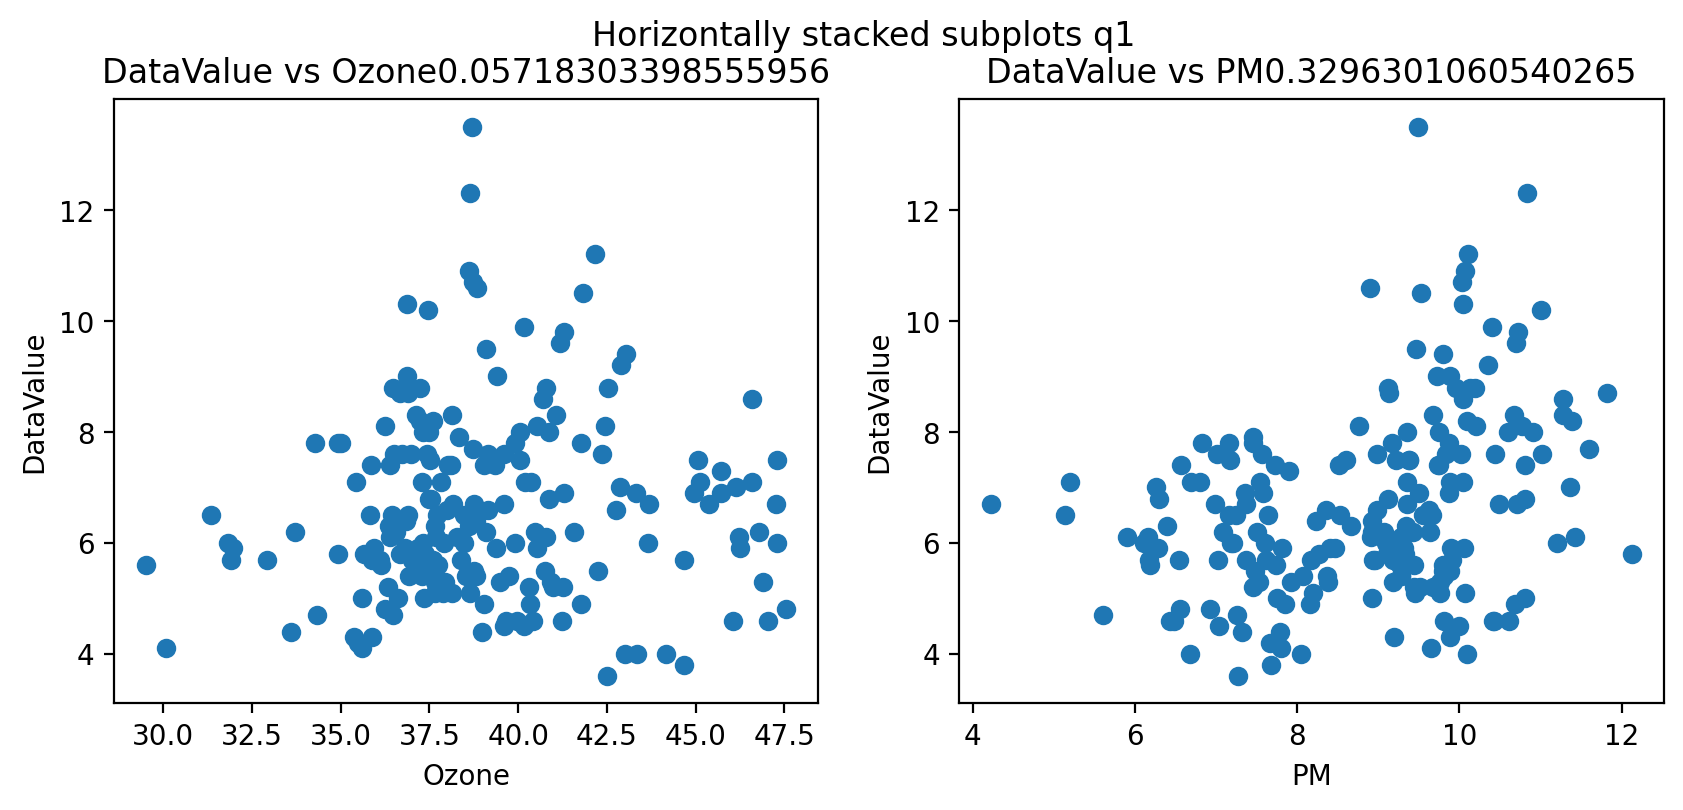

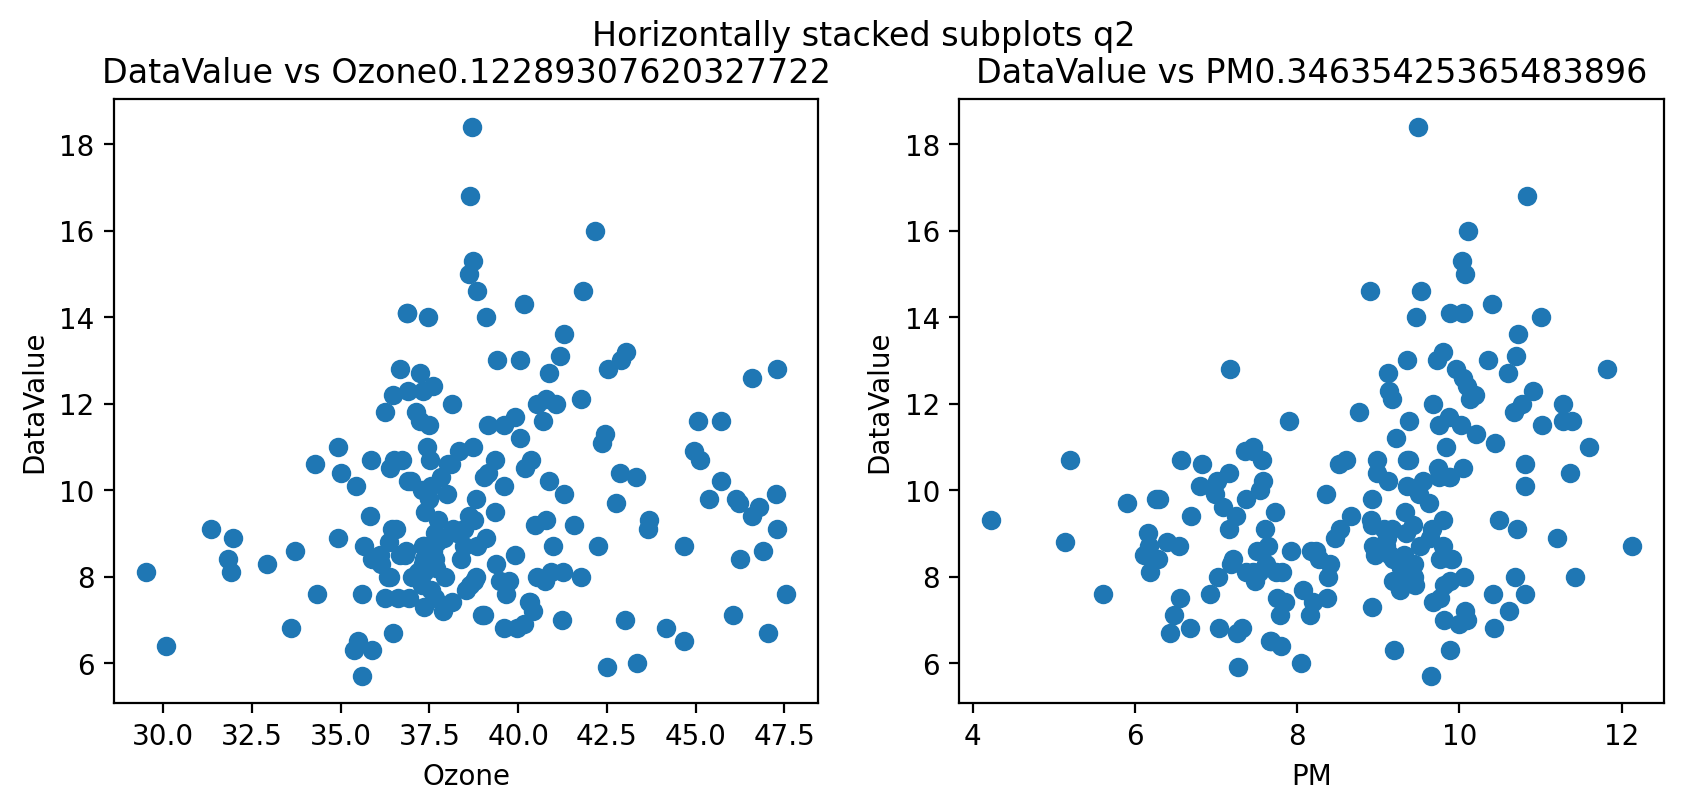

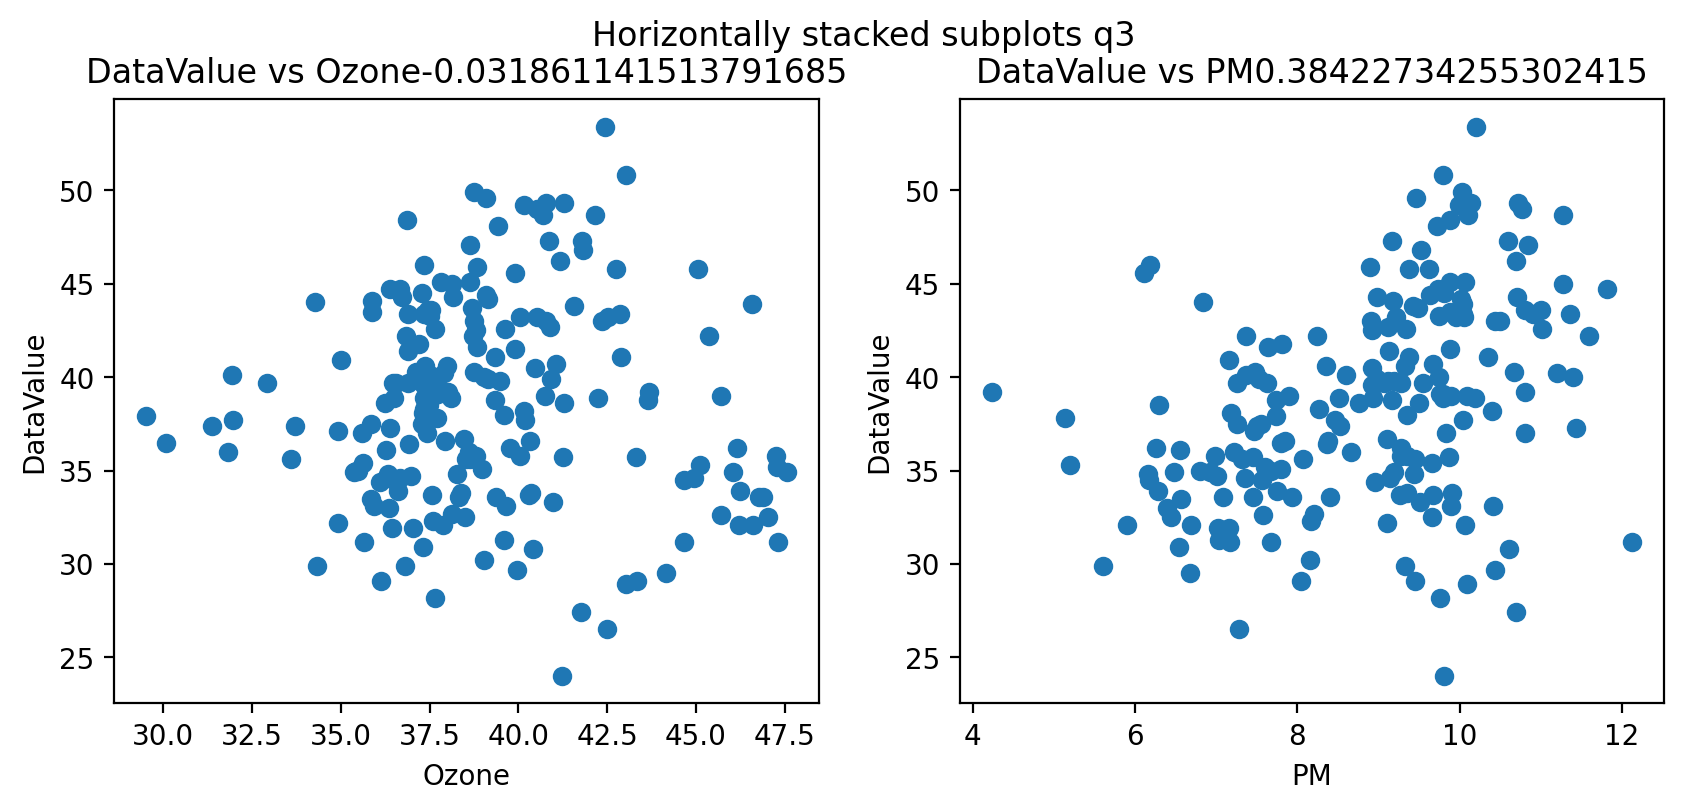

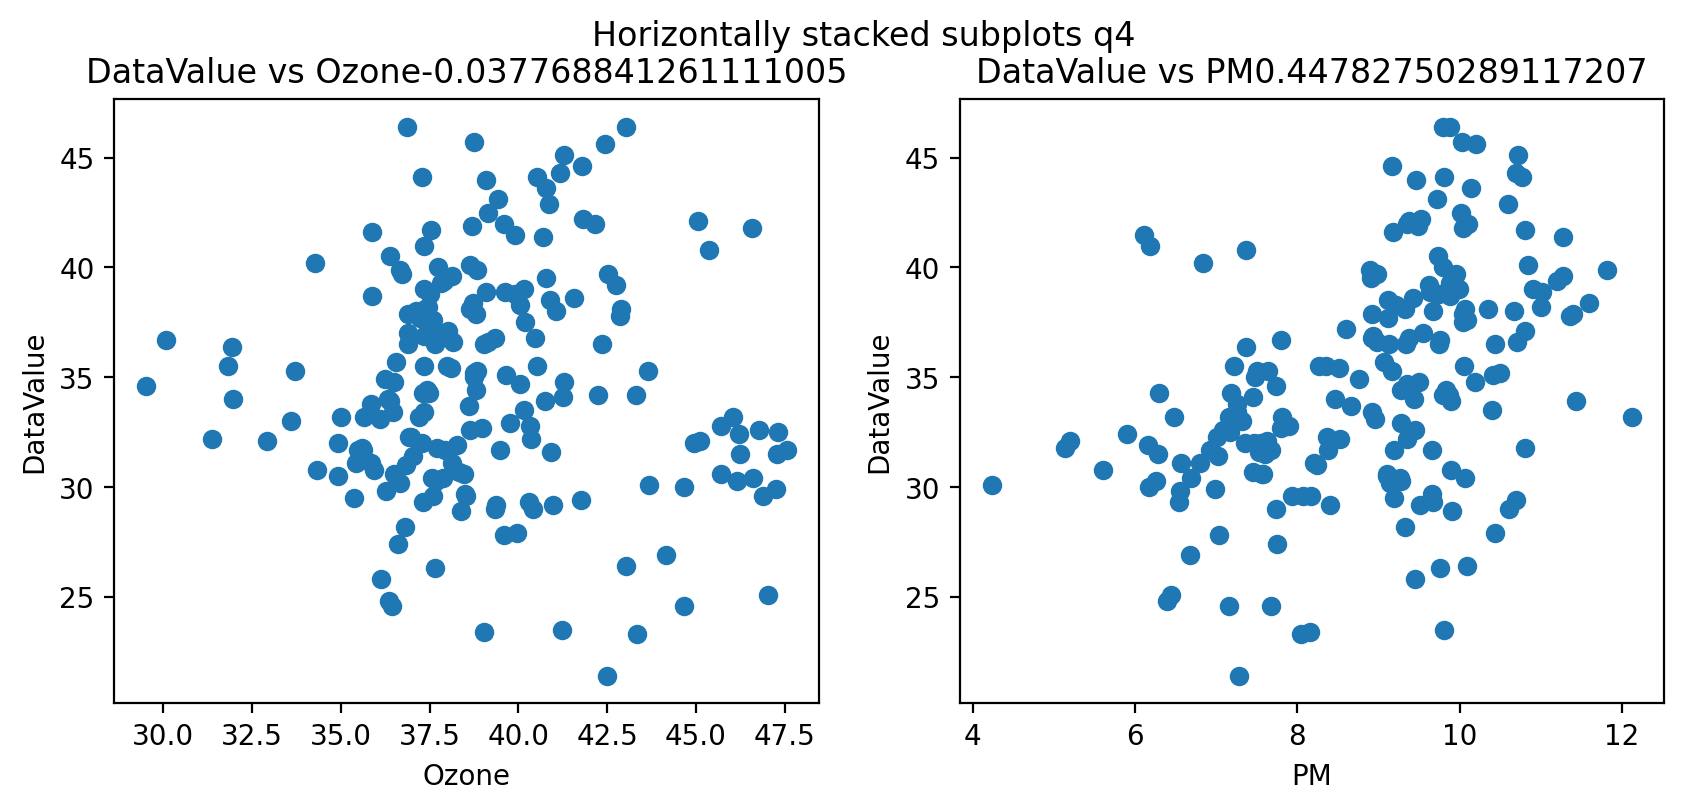

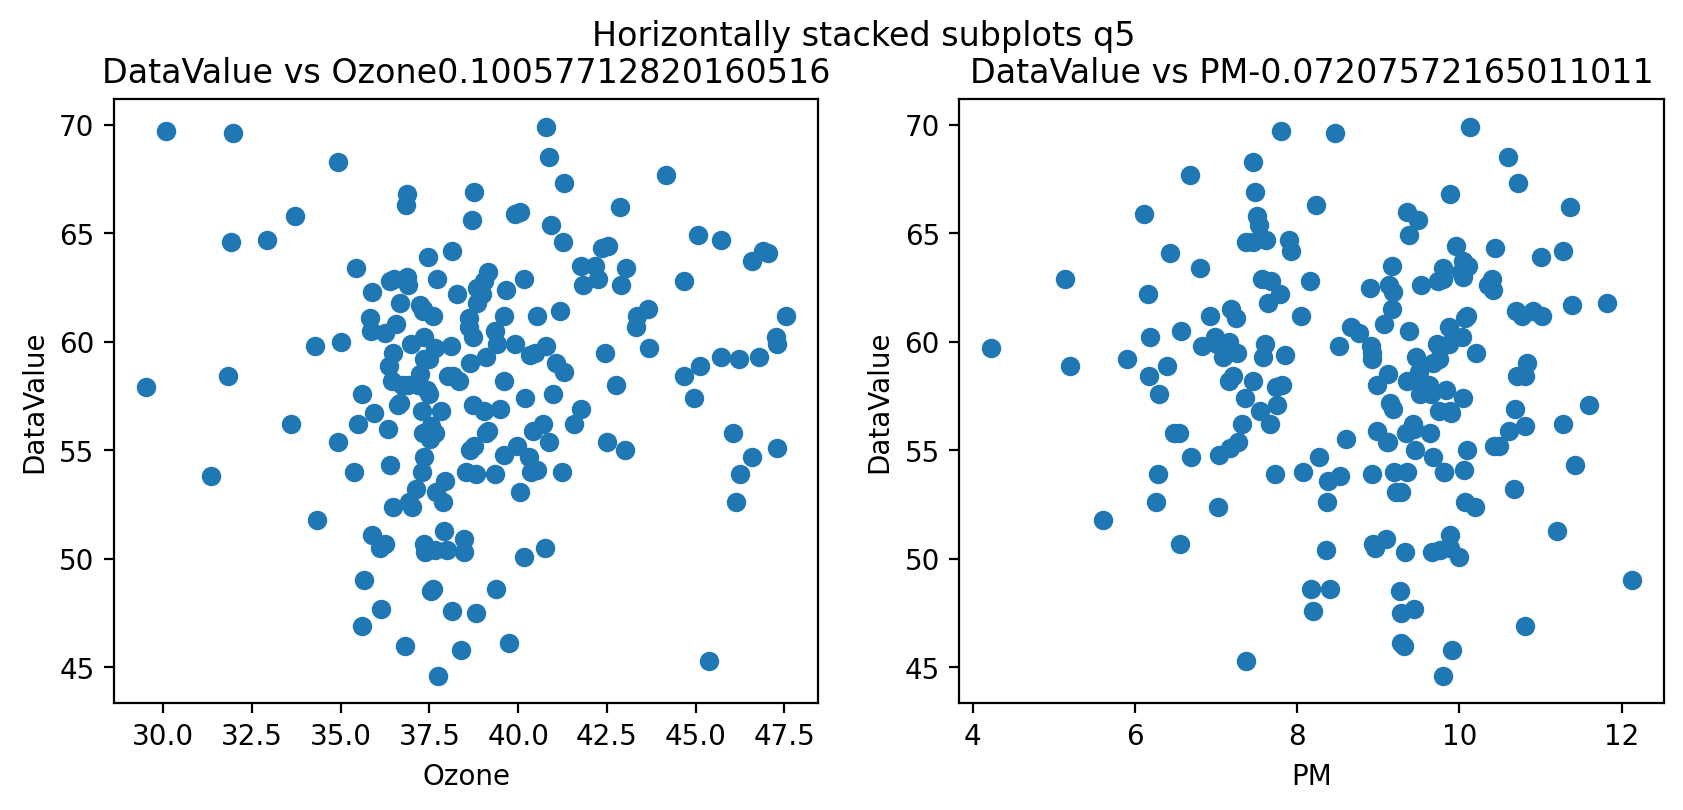

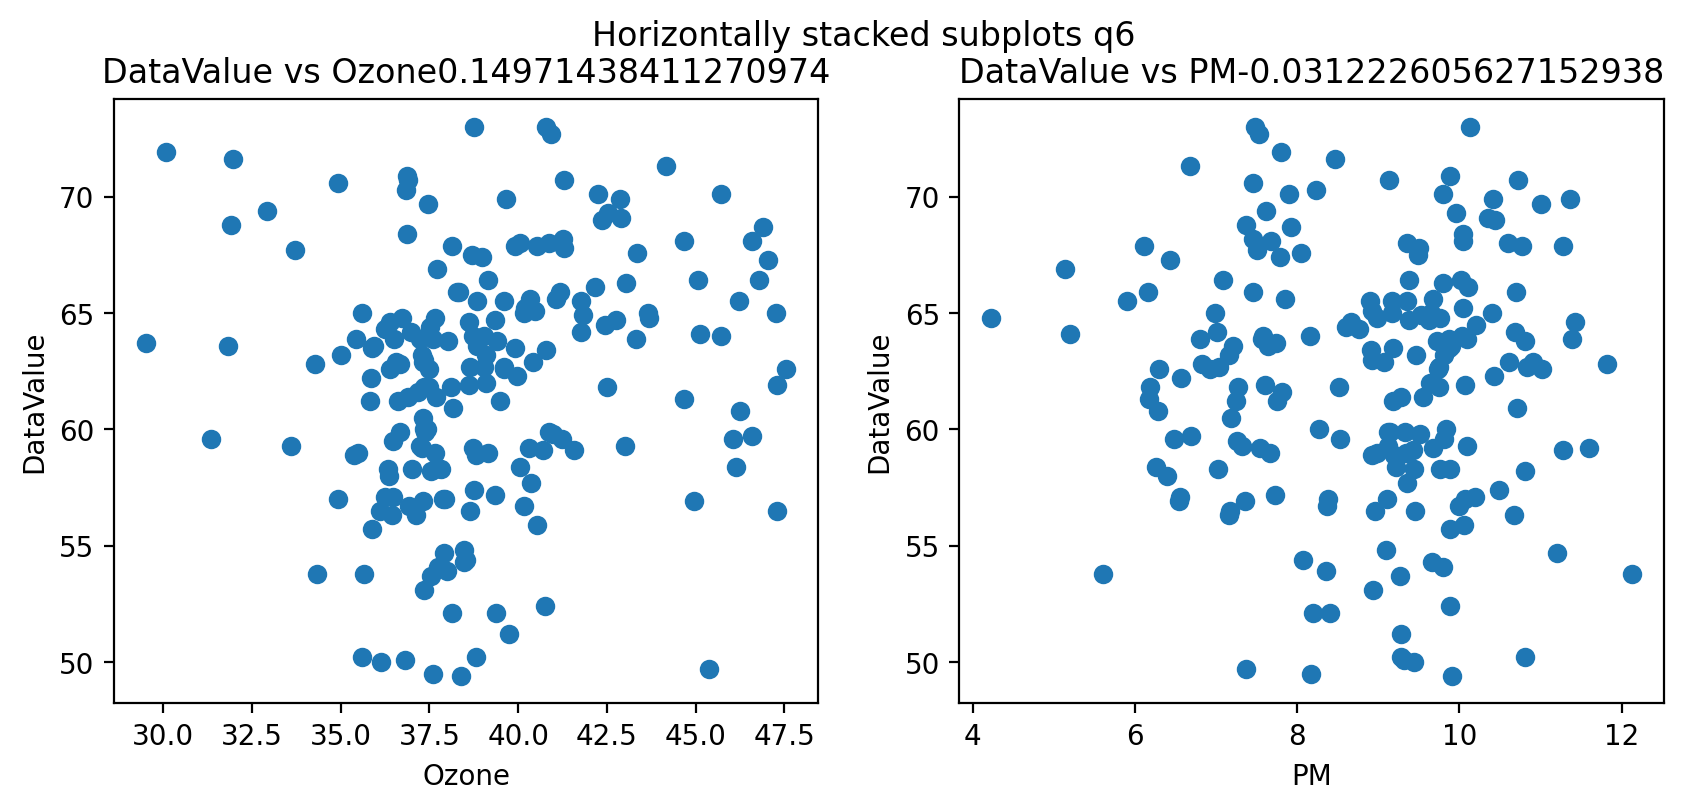

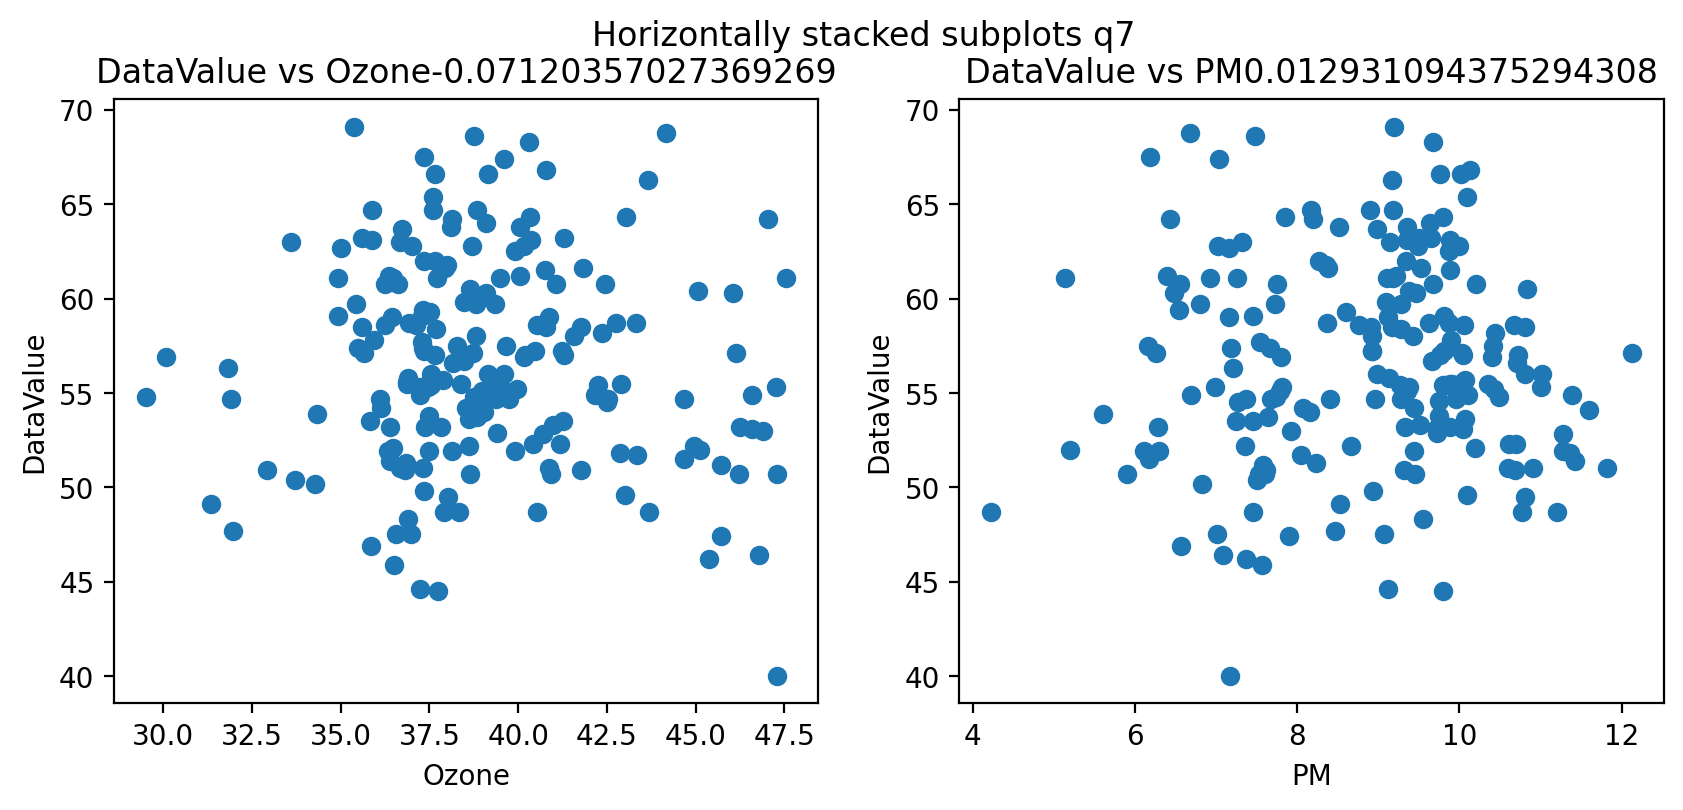

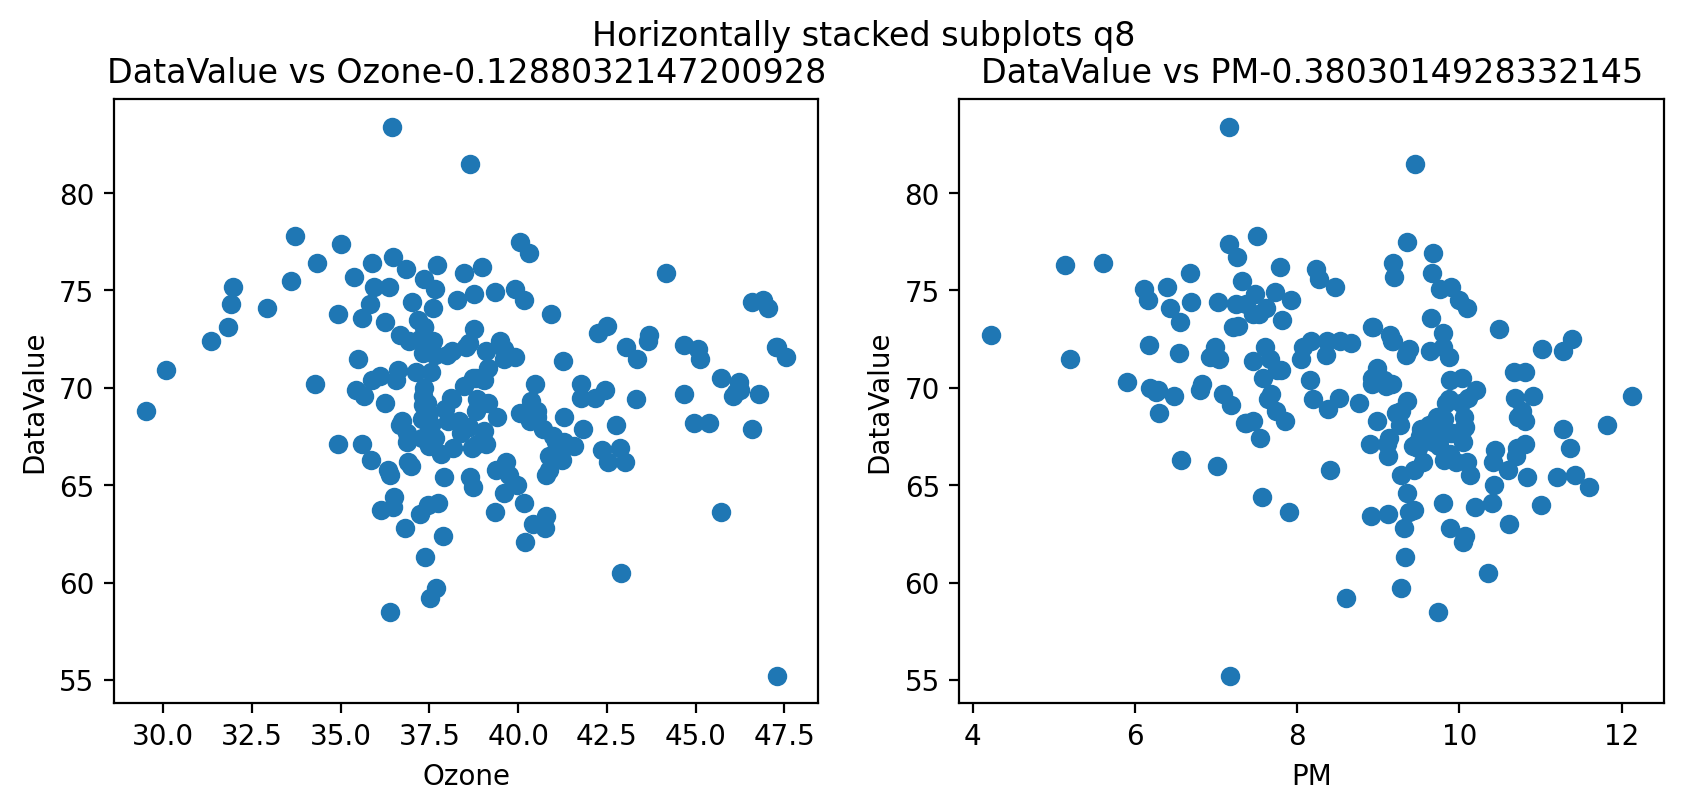

In [51]:
# plot the figures for yearly avg
for i in range(1,9):
    question_country_wise(i)

# 3) Research Question

## 3.1) Question 1: What is the causal impact of PM 2.5 and Ozone level on the crude prevalence of COPD?

### 3.1(a) Choosing the yearly climate statistics

Because the yearly average's visualization does not seem to give good correlation with prevalence. We switch to a new statistics for a state's yearly PM 2.5 and Ozone level. We take the average of the upper 30 percentile for a state's daily average as the new indicator for yearly Ozone and PM 2.5 level. Previous study has used maximum and 75% percentile as the yearly statistics. Our hypothesis is that COPD is caused from long term exposure to bad quality. By choosing the upper 30 percentile of the daily average PM 2.5 and Ozone, we focus on approximately the worst 110 days of the year. By taking an average, we want to synthesis the tail information about the upper 30 percentile distribution rather than taking a single percentile point that has no information about the tail.

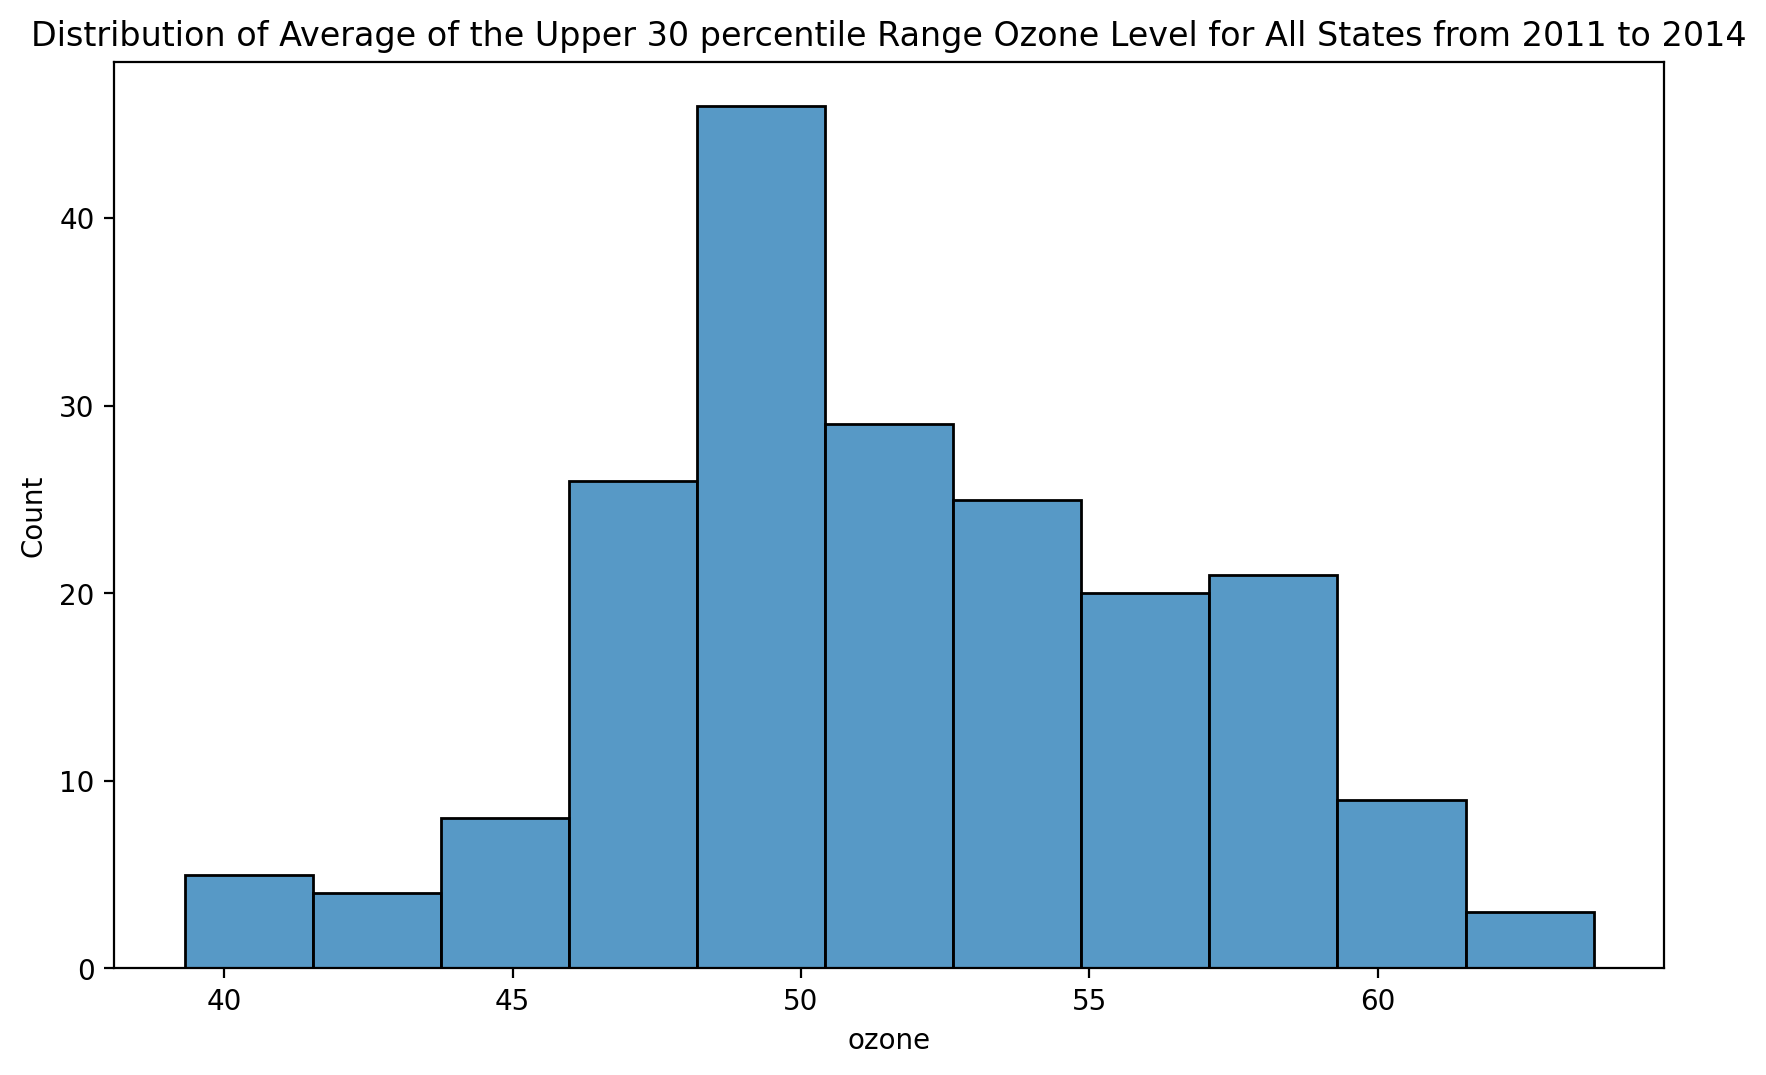

In [52]:
plt.figure(figsize=(10, 6), dpi=200)
sns.histplot(data = ozone_percentile_average, x = "ozone");
plt.title("Distribution of Average of the Upper 30 percentile Range Ozone Level for All States from 2011 to 2014");

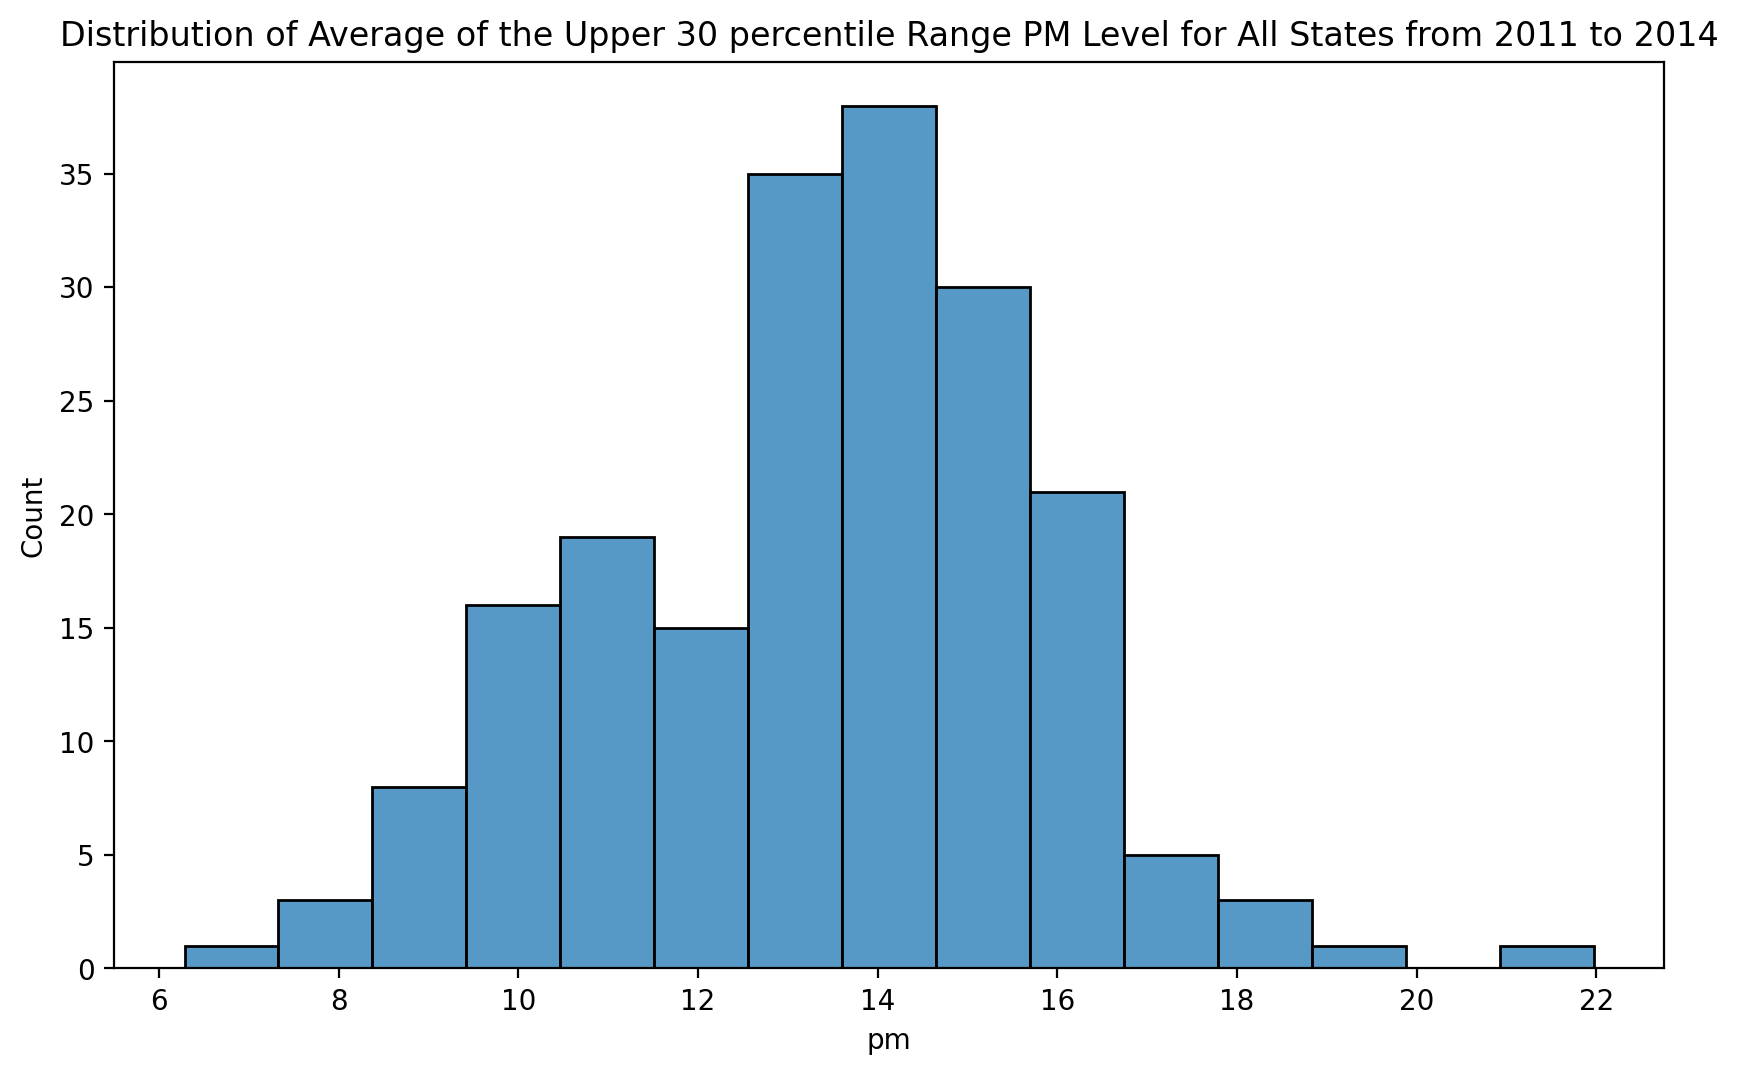

In [53]:
plt.figure(figsize=(10, 6), dpi=200)
sns.histplot(data = pm_percentile_average, x = "pm");
plt.title("Distribution of Average of the Upper 30 percentile Range PM Level for All States from 2011 to 2014");

Now both distributions has larger ranges, making us safer to classify the data into control and experiment group based on the PM 2.5 and Ozone level.

### 3.1(b) Classifying control and experiment group, Method Description

**Background Assumptions**: The data we have does not come from experiments but surveys. It is an observational study. So we make the assumption that this is a randomized experiment across the different states.

1. The treatment variable is the Ozone level and PM 2.5 level. It is a continuous variable, so we will manually classify the continuous data into binary control and experiment group.

2. Confounding factors exist, for example, the local industry structure of a state that comprises production that causes both high prevalence of COPD and high level of PM 2.5 and Ozone level. 

3. Since the confounding factors are hard to quantify, we continue to treat the study as a natural experiment. This is a limitation of our study as we did not take into account the possible confounders in our study.

4. There is another error contributor or randomness coming into the causal inference analysis since we have done manual classification of control and experimental group. The process is as follows:

   + Firstly, we filter the data based on years to comply with the Stable Unit Treatment Value Assumption as the prevalence for each state correlates strongly between years.

   + Secondly, we counted roughly the number of darker color states(experiment states) for each year.

   + Thirdly, we have one classifying worker looking at the pure ranked data based on Ozone and PM 2.5 level. Find the boundary states according to the number of experimental states(1) we decide earlier. Another classifying worker looking at the Geospatial graph with colormap agrees or disagrees upon the current assignments and makes adjustments accordingly. We record the classified numerical boundary and move to the next year. Then we repeat the same process and confirm the boundary is consistent with the previous year and make minor adjustments if plausible.

In [54]:
pm_2011 = pm_percentile_average[pm_percentile_average["year"] == 2011]
pm_2011["rank"] = pm_2011["pm"].rank(method='dense', ascending=False)
pm_2011["Quality"] = (pm_2011["rank"] <= 16).astype(int)
pm_2011 = pm_2011.merge(fips_states, on = "statefips")
pm_2011

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


year  statefips         pm  rank  Quality                 State StateAbbr
0   2011          1  15.639008  15.0        1               Alabama        AL
1   2011          4  10.617078  42.0        0               Arizona        AZ
2   2011          5  14.973890  23.0        0              Arkansas        AR
3   2011          6  15.421353  19.0        0            California        CA
4   2011          8   9.354350  47.0        0              Colorado        CO
5   2011          9  15.914905  12.0        1           Connecticut        CT
6   2011         10  15.636861  16.0        1              Delaware        DE
7   2011         11  16.551469   6.0        1  District of Columbia        DC
8   2011         12  10.590699  43.0        0               Florida        FL
9   2011         13  16.639120   5.0        1               Georgia        GA
10  2011         16  11.098824  40.0        0                 Idaho        ID
11  2011         17  18.005047   1.0        1              Illinois        IL
12  2011         18  17.718909   3.0        1               Indiana        IN
13  2011         19  15.183808  21.0        0                  Iowa        IA
14  2011         20  13.752115  31.0        0                Kansas        KS
15  2011         21  16.222395   8.0        1              Kentucky        KY
16  2011         22  13.371888  33.0        0             Louisiana        LA
17  2011         23  11.341198  39.0        0                 Maine        ME
18  2011         24  16.028345   9.0        1              Maryland        MD
19  2011         25  14.712104  25.0        0         Massachusetts        MA
20  2011         26  15.747519  14.0        1              Michigan        MI
21  2011         27  14.256234  29.0        0             Minnesota        MN
22  2011         28  13.635455  32.0        0           Mississippi        MS
23  2011         29  15.766706  13.0        1              Missouri        MO
24  2011         30   8.438878  48.0        0               Montana        MT
25  2011         31  12.516659  37.0        0              Nebraska        NE
26  2011         32  10.949212  41.0        0                Nevada        NV
27  2011         33  13.217948  34.0        0         New Hampshire        NH
28  2011         34  16.498461   7.0        1            New Jersey        NJ
29  2011         35  10.410036  44.0        0            New Mexico        NM
30  2011         36  15.923548  11.0        1              New York        NY
31  2011         37  14.741775  24.0        0        North Carolina        NC
32  2011         38   9.586095  46.0        0          North Dakota        ND
33  2011         39  17.883561   2.0        1                  Ohio        OH
34  2011         40  14.380850  28.0        0              Oklahoma        OK
35  2011         41  14.110021  30.0        0                Oregon        OR
36  2011         42  16.956931   4.0        1          Pennsylvania        PA
37  2011         44  14.383726  27.0        0          Rhode Island        RI
38  2011         45  15.496706  18.0        0        South Carolina        SC
39  2011         46  10.209028  45.0        0          South Dakota        SD
40  2011         47  15.054150  22.0        0             Tennessee        TN
41  2011         48  13.037194  36.0        0                 Texas        TX
42  2011         49  15.517952  17.0        0                  Utah        UT
43  2011         50  12.250390  38.0        0               Vermont        VT
44  2011         51  14.418663  26.0        0              Virginia        VA
45  2011         53  13.037695  35.0        0            Washington        WA
46  2011         54  15.413376  20.0        0         West Virginia        WV
47  2011         55  15.959014  10.0        1             Wisconsin        WI
48  2011         56   8.063774  49.0        0               Wyoming        WY

In [55]:
pm_2012 = pm_percentile_average[pm_percentile_average["year"] == 2012]
pm_2012["rank"] = pm_2012["pm"].rank(method='dense', ascending=False)
pm_2012["Quality"] = (pm_2012["rank"] <= 7).astype(int)
pm_2012 = pm_2012.merge(fips_states, on = "statefips")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [56]:
pm_2013 = pm_percentile_average[pm_percentile_average["year"] == 2013]
pm_2013["rank"] = pm_2013["pm"].rank(method='dense', ascending=False)
pm_2013["Quality"] = (pm_2013["rank"] <= 7).astype(int)
pm_2013 = pm_2013.merge(fips_states, on = "statefips")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [57]:
pm_2014 = pm_percentile_average[pm_percentile_average["year"] == 2014]
pm_2014["rank"] = pm_2014["pm"].rank(method='dense', ascending=False)
pm_2014["Quality"] = (pm_2014["rank"] <= 7).astype(int)
pm_2014 = pm_2014.merge(fips_states, on = "statefips")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [58]:
Ozone_2011 = ozone_percentile_average[ozone_percentile_average["year"] == 2011]
Ozone_2011["rank"] = Ozone_2011["ozone"].rank(method='dense', ascending=False)
Ozone_2011["Quality"] = (Ozone_2011["rank"] <= 18).astype(int)
Ozone_2011 = Ozone_2011.merge(fips_states, on = "statefips")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [59]:
Ozone_2012 = ozone_percentile_average[ozone_percentile_average["year"] == 2012]
Ozone_2012["rank"] = Ozone_2012["ozone"].rank(method='dense', ascending=False)
Ozone_2012["Quality"] = (Ozone_2012["rank"] <= 23).astype(int)
Ozone_2012 = Ozone_2012.merge(fips_states, on = "statefips")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [60]:
Ozone_2013 = ozone_percentile_average[ozone_percentile_average["year"] == 2013]
Ozone_2013["rank"] = Ozone_2013["ozone"].rank(method='dense', ascending=False)
Ozone_2013["Quality"] = (Ozone_2013["rank"] <= 22).astype(int)
Ozone_2013 = Ozone_2013.merge(fips_states, on = "statefips")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [61]:
Ozone_2014 = ozone_percentile_average[ozone_percentile_average["year"] == 2014]
Ozone_2014["rank"] = Ozone_2014["ozone"].rank(method='dense', ascending=False)
Ozone_2014["Quality"] = (Ozone_2014["rank"] <= 18).astype(int)
Ozone_2014 = Ozone_2014.merge(fips_states, on = "statefips")
Ozone_2014.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


year  statefips      ozone  rank  Quality       State StateAbbr
0  2014          1  48.257146  33.0        0     Alabama        AL
1  2014          4  57.287757   2.0        1     Arizona        AZ
2  2014          5  47.369993  37.0        0    Arkansas        AR
3  2014          6  52.409321   7.0        1  California        CA
4  2014          8  55.772018   3.0        1    Colorado        CO

### 3.1(c) Filter into outcome data

In [62]:
Q1_2011 = Q1[Q1["YearStart"] == 2011]
Q1_2011 = Q1_2011[["LocationAbbr", "DataValue"]]
Q1_2011["LocationAbbr"] = Q1_2011["LocationAbbr"].astype("string")
Q1_2011.head()

LocationAbbr  DataValue
69946           CT        6.1
69979           MA        5.8
70066           MD        5.9
70197           AR        8.0
70203           MI        8.0

In [63]:
Q1_2012 = Q1[Q1["YearStart"] == 2012]
Q1_2012 = Q1_2012[["LocationAbbr", "DataValue"]]
Q1_2012["LocationAbbr"] = Q1_2012["LocationAbbr"].astype("string")
Q1_2012.head()

LocationAbbr  DataValue
69935           KS        6.0
69948           MO        8.1
70181           CO        4.8
70232           CA        4.6
70344           AR        8.8

In [64]:
Q1_2013 = Q1[Q1["YearStart"] == 2013]
Q1_2013 = Q1_2013[["LocationAbbr", "DataValue"]]
Q1_2013["LocationAbbr"] = Q1_2013["LocationAbbr"].astype("string")
Q1_2013.head()

LocationAbbr  DataValue
69994           DC        5.8
70051           MD        5.4
70071           MA        5.7
70290           KY       10.9
70479           AR        9.0

In [65]:
Q1_2014 = Q1[Q1["YearStart"] == 2014]
Q1_2014 = Q1_2014[["LocationAbbr", "DataValue"]]
Q1_2014["LocationAbbr"] = Q1_2014["LocationAbbr"].astype("string")
Q1_2014.head()

LocationAbbr  DataValue
0               AZ        6.9
70018           KS        6.6
70142           CO        4.0
70259           CA        4.9
70640           DC        5.6

### 3.1(d) Prepare the outcome table

In [66]:
pm_2011 = pm_2011.sort_values("StateAbbr")
Q1_2011.columns = ["StateAbbr", "Outcome"]
Q1_2011 = Q1_2011.sort_values("StateAbbr")
Q1_2011.index = pm_2011.index

pm_outcome_table_2011 = pd.DataFrame()
pm_outcome_table_2011["StateAbbr"] = pm_2011["StateAbbr"]
pm_outcome_table_2011["Outcome"] = Q1_2011["Outcome"]
pm_outcome_table_2011["Treatment"] = pm_2011["Quality"]
pm_outcome_table_2011.head()

StateAbbr  Outcome  Treatment
0        AL      9.6          1
2        AR      8.0          0
1        AZ      5.3          0
3        CA      4.6          0
4        CO      4.6          0

In [67]:
pm_2012 = pm_2012.sort_values("StateAbbr")
Q1_2012.columns = ["StateAbbr", "Outcome"]
Q1_2012 = Q1_2012.sort_values("StateAbbr")
pm_outcome_table_2012 = pd.DataFrame()
pm_outcome_table_2012["StateAbbr"] = pm_2012["StateAbbr"]
pm_outcome_table_2012["Outcome"] = Q1_2012["Outcome"].to_list()
pm_outcome_table_2012["Treatment"] = pm_2012["Quality"]

In [68]:
pm_2013 = pm_2013.sort_values("StateAbbr")
Q1_2013.columns = ["StateAbbr", "Outcome"]
Q1_2013 = Q1_2013.sort_values("StateAbbr")
pm_outcome_table_2013 = pd.DataFrame()
pm_outcome_table_2013["StateAbbr"] = pm_2013["StateAbbr"]
pm_outcome_table_2013["Outcome"] = Q1_2013["Outcome"].to_list()
pm_outcome_table_2013["Treatment"] = pm_2013["Quality"]

In [69]:
pm_2014 = pm_2014.sort_values("StateAbbr")
Q1_2014.columns = ["StateAbbr", "Outcome"]
Q1_2014 = Q1_2014.sort_values("StateAbbr")
pm_outcome_table_2014 = pd.DataFrame()
pm_outcome_table_2014["StateAbbr"] = pm_2014["StateAbbr"]
pm_outcome_table_2014["Outcome"] = Q1_2014["Outcome"].to_list()
pm_outcome_table_2014["Treatment"] = pm_2014["Quality"]

In [70]:
oz_2011 = Ozone_2011.sort_values("StateAbbr")
oz_outcome_table_2011 = pd.DataFrame()
oz_outcome_table_2011["StateAbbr"] = oz_2011["StateAbbr"]
oz_outcome_table_2011["Outcome"] = Q1_2011["Outcome"].to_list()
oz_outcome_table_2011["Treatment"] = oz_2011["Quality"]

In [71]:
oz_2012 = Ozone_2012.sort_values("StateAbbr")
oz_outcome_table_2012 = pd.DataFrame()
oz_outcome_table_2012["StateAbbr"] = oz_2012["StateAbbr"]
oz_outcome_table_2012["Outcome"] = Q1_2012["Outcome"].to_list()
oz_outcome_table_2012["Treatment"] = oz_2012["Quality"]

In [72]:
oz_2013 = Ozone_2013.sort_values("StateAbbr")
oz_outcome_table_2013 = pd.DataFrame()
oz_outcome_table_2013["StateAbbr"] = oz_2013["StateAbbr"]
oz_outcome_table_2013["Outcome"] = Q1_2013["Outcome"].to_list()
oz_outcome_table_2013["Treatment"] = oz_2013["Quality"]

In [73]:
oz_2014 = Ozone_2014.sort_values("StateAbbr")
oz_outcome_table_2014 = pd.DataFrame()
oz_outcome_table_2014["StateAbbr"] = oz_2014["StateAbbr"]
oz_outcome_table_2014["Outcome"] = Q1_2014["Outcome"].to_list()
oz_outcome_table_2014["Treatment"] = oz_2014["Quality"]

### 3.1(e) Calculate ATE and Neyman Pearson CI

In [74]:
def cauculate_Neyman_ATE_CI(df):
    treatment_group = df[df.Treatment == 1]["Outcome"]
    control_group = df[df.Treatment == 0]["Outcome"]
    average_control_effect = np.mean(control_group)
    average_treatment_effect = np.mean(treatment_group)
    ATE = average_treatment_effect - average_control_effect
    variance_control = np.var(control_group, ddof=1)
    variance_treatment = np.var(treatment_group, ddof = 1)
    n_1 = len(treatment_group)
    n_0 = len(control_group)
    Neyman_var = variance_treatment/n_1 + variance_control/n_0
    upper_CI = ATE + 1.96 * Neyman_var ** 0.5
    lower_CI = ATE - 1.96 * Neyman_var ** 0.5
    return ATE, upper_CI, lower_CI

In [75]:
ATE1, upper_CI1, lower_CI1 = cauculate_Neyman_ATE_CI(pm_outcome_table_2011)
ATE2, upper_CI2, lower_CI2 = cauculate_Neyman_ATE_CI(pm_outcome_table_2012)
ATE3, upper_CI3, lower_CI3 = cauculate_Neyman_ATE_CI(pm_outcome_table_2013)
ATE4, upper_CI4, lower_CI4 = cauculate_Neyman_ATE_CI(pm_outcome_table_2014)

In [76]:
ATE_oz1, upper_CI_oz1, lower_CI_oz1 = cauculate_Neyman_ATE_CI(oz_outcome_table_2011)
ATE_oz2, upper_CI_oz2, lower_CI_oz2 = cauculate_Neyman_ATE_CI(oz_outcome_table_2012)
ATE_oz3, upper_CI_oz3, lower_CI_oz3 = cauculate_Neyman_ATE_CI(oz_outcome_table_2013)
ATE_oz4, upper_CI_oz4, lower_CI_oz4 = cauculate_Neyman_ATE_CI(oz_outcome_table_2014)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "rs" (-> marker='s'). The keyword argument will take precedence.
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "rs" (-> marker='s'). The keyword argument will take precedence.
  """


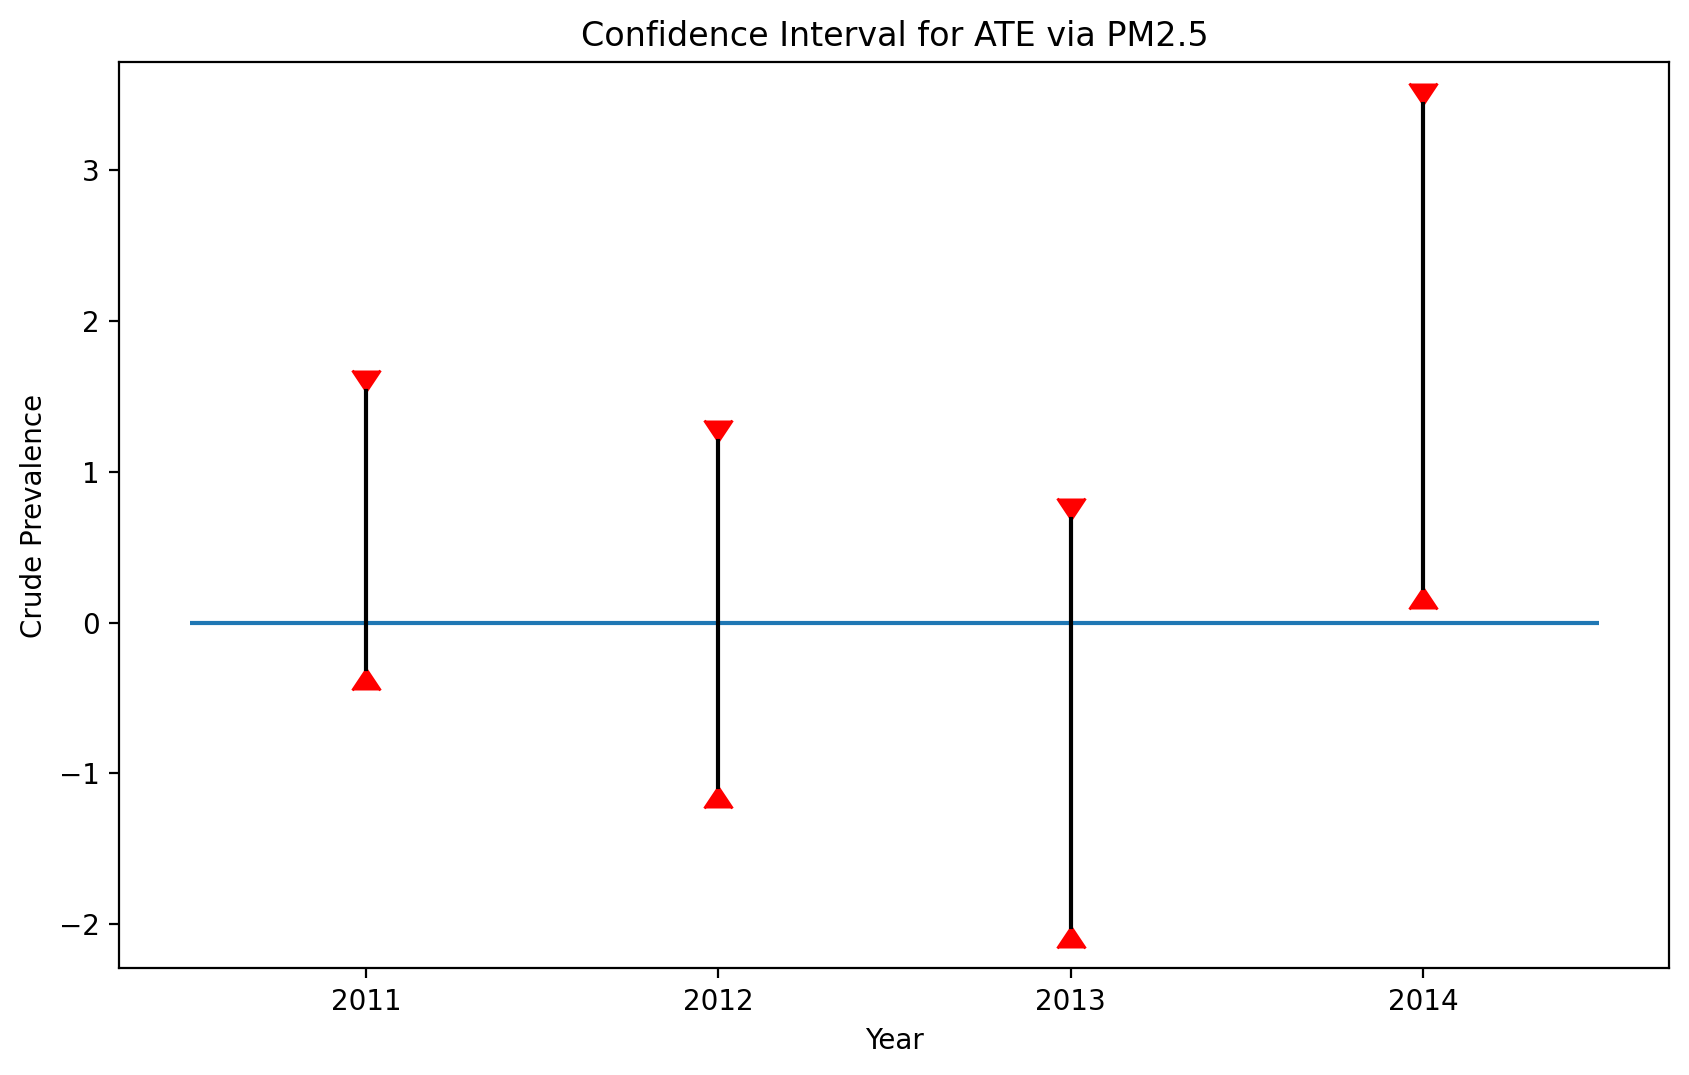

In [77]:
plt.figure(figsize=(10, 6), dpi=200)
xci = [2011, 2012, 2013, 2014]
yci = [(upper_CI1, lower_CI1), (upper_CI2, lower_CI2), (upper_CI3, lower_CI3), (upper_CI4, lower_CI4)]
plt.plot(xci,[i for (i,j) in yci], 'rs', marker = 7, markersize = 10)
plt.plot(xci,[j for (i,j) in yci], 'rs', marker = 6, markersize = 10)
plt.plot((xci,xci),([i for (i,j) in yci], [j for (i,j) in yci]),c='black')
plt.hlines(0, xmin=2010.5, xmax=2014.5)
plt.xticks((2011, 2012, 2013, 2014), ('2011', '2012', '2013', '2014'))
plt.title('Confidence Interval for ATE via PM2.5')
plt.xlabel('Year')
plt.ylabel('Crude Prevalence');

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "rs" (-> marker='s'). The keyword argument will take precedence.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "rs" (-> marker='s'). The keyword argument will take precedence.
  after removing the cwd from sys.path.


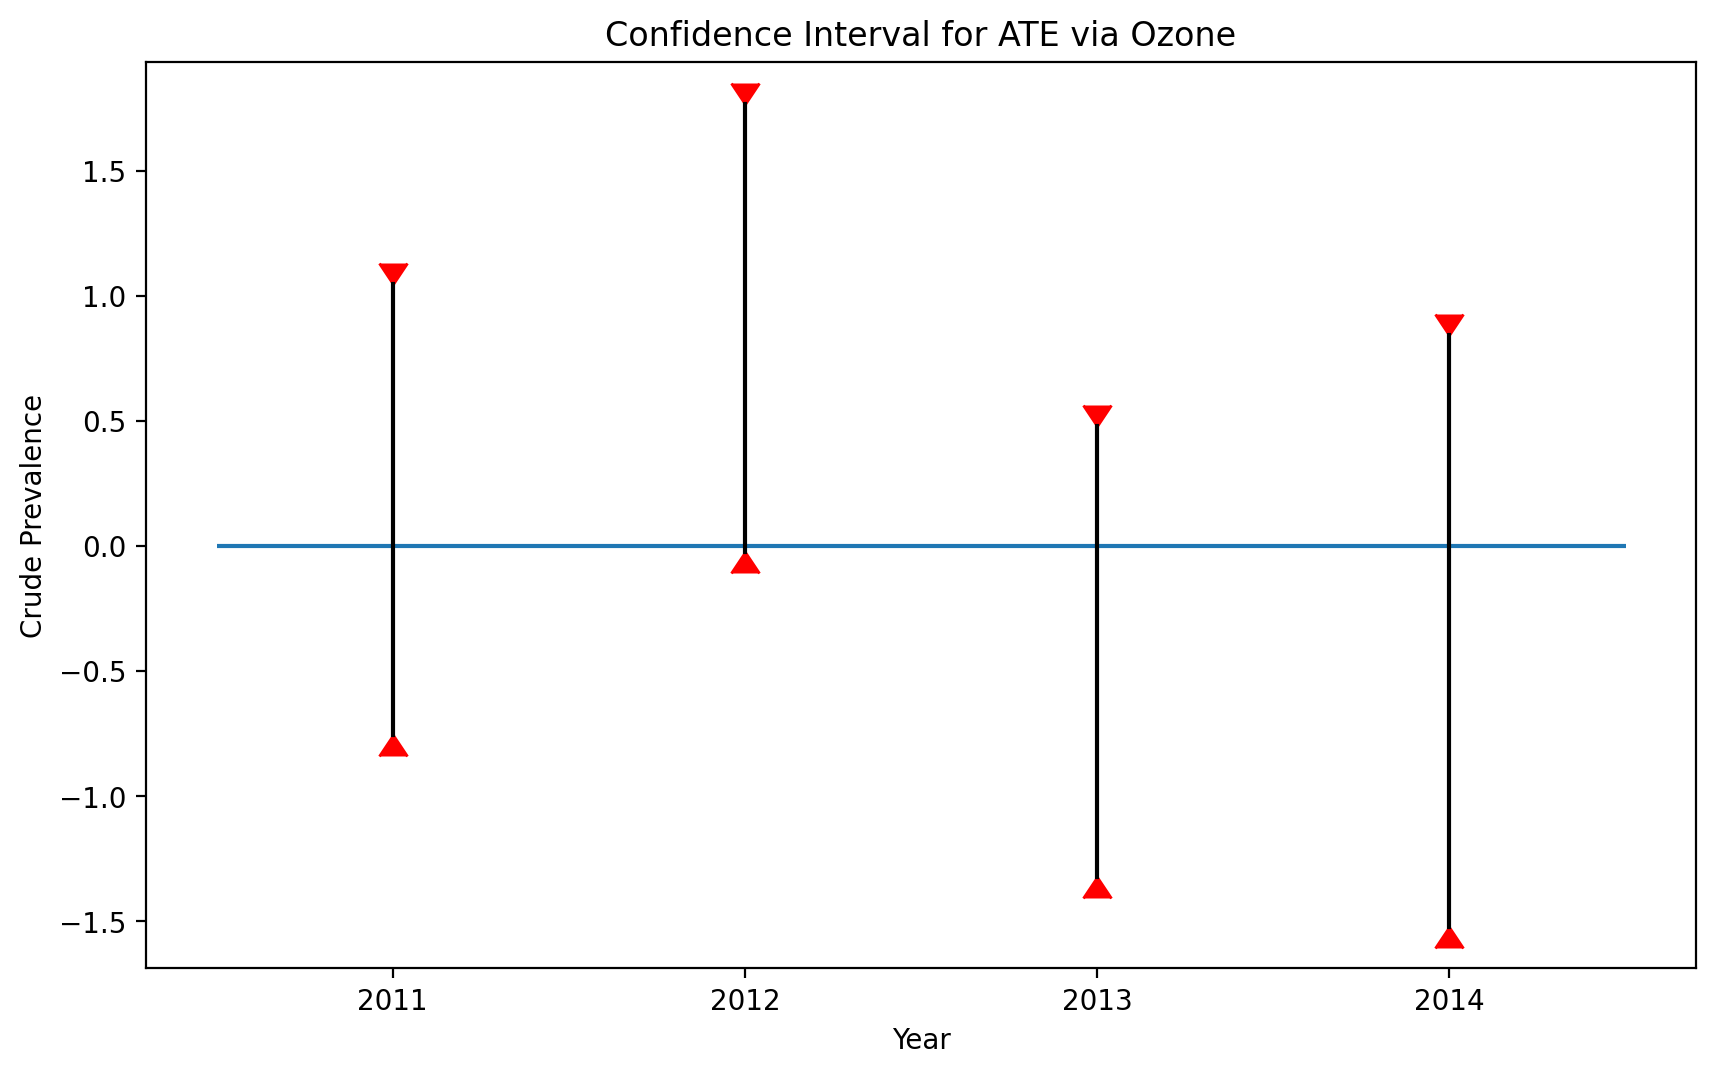

In [78]:
plt.figure(figsize=(10, 6), dpi=200)
y_oz_ci = [(upper_CI_oz1, lower_CI_oz1), (upper_CI_oz2, lower_CI_oz2), (upper_CI_oz3, lower_CI_oz3), (upper_CI_oz4, lower_CI_oz4)]
plt.plot(xci,[i for (i,j) in y_oz_ci], 'rs', marker = 7, markersize = 10)
plt.plot(xci,[j for (i,j) in y_oz_ci], 'rs', marker = 6, markersize = 10)
plt.plot((xci,xci),([i for (i,j) in y_oz_ci], [j for (i,j) in y_oz_ci]),c='black')
plt.hlines(0, xmin=2010.5, xmax=2014.5)
plt.xticks((2011, 2012, 2013, 2014), ('2011', '2012', '2013', '2014'))
plt.title('Confidence Interval for ATE via Ozone')
plt.xlabel('Year')
plt.ylabel('Crude Prevalence');

### 3.1(f) Summary & Discussion

The Neyman Weak Null Hypothesis contains the 0 ATE for all four years except fot PM 2.5 in 2014. So for both PM 2.5 and Ozone we fail to reject the null in the most cases. The null is that there is no causal relationship between COPD with PM 2.5 and Ozone. This result is under the assumption of randomized experiment and does not consider any confounding factors.

The uncertainty mainly comes from the manual assignment of control and experimental group of the states. Because the manual assignment may not have balanced out the unobserved confounders which is the key property of randomized experiment. For this reason, our Neyman Confidence Interval might not be accurate.

There is no categorical data in our variable, so we did not look into Simpson's paradox. The limitation is discussed above mainly on confounders and manual assignment of control and experimental group due to the nature of observational data. In the future, census data could be added to the state level so that propensity score weighting, instrumental variables and matching techniques could be applied to explore casual relationships. 

I am very confident there is a casual relationship, because I come from China where the PM 2.5 pollution was a big issue for our country. And we have indeed experienced the increase of COPD patients as a consequence. But for this data, the granularity of the PM 2.5 and Ozone data is forced to be on a yearly level to match the granularity of the COPD statistics. The data processing procedure adds additional confounder to the study which is the choice of yearly climate statistics. Finally, there is the delay effect of air quality's impact on people's health. To take that into account, future study can add on the delay effect: use the past year's air quality data as the treatment variable for current year's COPD prevalence outcome variable. 

## 3.2) Question2: Predict crude prevalence of COPD using PM 2.5 and Ozone level with GLM and Nonparametric method and compare the model.

In [79]:
pm_ozone_table = pd.merge(ozone_percentile_average,pm_percentile_average, on = ['year', 'statefips'])

In [80]:
merged_list = []
for df in q_df:
    aa = pd.merge(df, pm_ozone_table,  how='left', left_on=['YearStart','state#'], right_on = ['year','statefips'])
    bb = aa#[['year','pm','ozone','state#','DataValue','LocationAbbr','DataValueType']]
    merged_list.append(bb)

In [81]:
#K-NN regression on pm2.5, ozone and year

df_age = merged_list[0].loc[merged_list[0]['DataValueType'] == 'Crude Prevalence']
train, test = train_test_split(df_age, test_size = 0.2,random_state=3)
train, validation = train_test_split(train, test_size = 0.25,random_state=2)
x_train = train[['pm', 'ozone', 'year']]
y_train = train['DataValue']
x_test = test[['pm', 'ozone', 'year']]
y_test = test['DataValue']
x_val = validation[['pm', 'ozone', 'year']]
y_val = validation['DataValue']

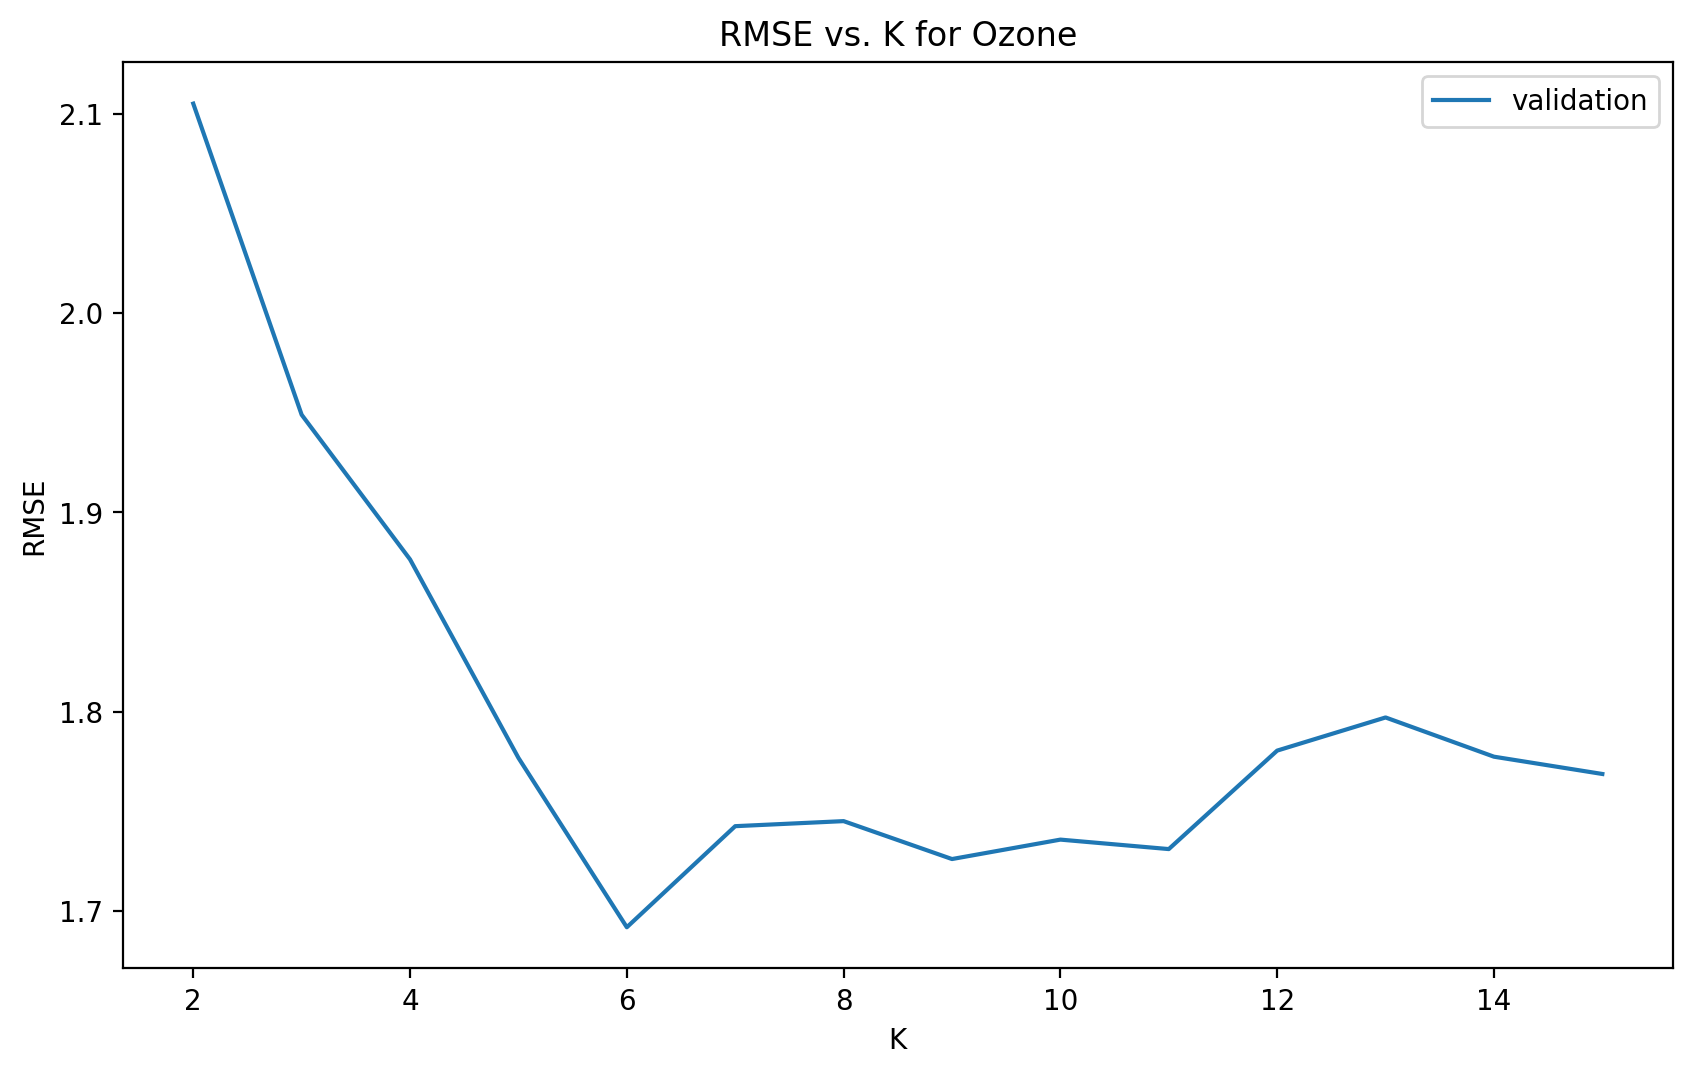

In [82]:
k_list = np.arange(2, 16)
x_train_ozone = np.array(train['ozone']).reshape(-1, 1)
x_val_ozone = np.array(validation['ozone']).reshape(-1, 1)
x_test_ozone = np.array(test['ozone']).reshape(-1, 1)

rmse_ozone = []
rmse_ozone_validation = []

for k in k_list:
    ozone_model = neighbors.KNeighborsRegressor(n_neighbors = k)
    ozone_model.fit(x_train_ozone, y_train)
    ozone_pred = ozone_model.predict(x_val_ozone)
    #ozone_pred_train = ozone_model.predict(x_train_ozone)
    #rmse_train = (mean_squared_error(y_train, ozone_pred_train))**(1/2)
    rmse = (mean_squared_error(y_val, ozone_pred))**(1/2)
    rmse_ozone_validation.append(rmse)
    #rmse_ozone_train.append(rmse_train)

#plt.plot(k_list,rmse_ozone,label = 'test' )
plt.figure(figsize=(10, 6), dpi=200)
plt.plot(k_list,rmse_ozone_validation, label = 'validation')

plt.title("RMSE vs. K for Ozone")
plt.xlabel("K")
plt.ylabel("RMSE")
plt.legend();

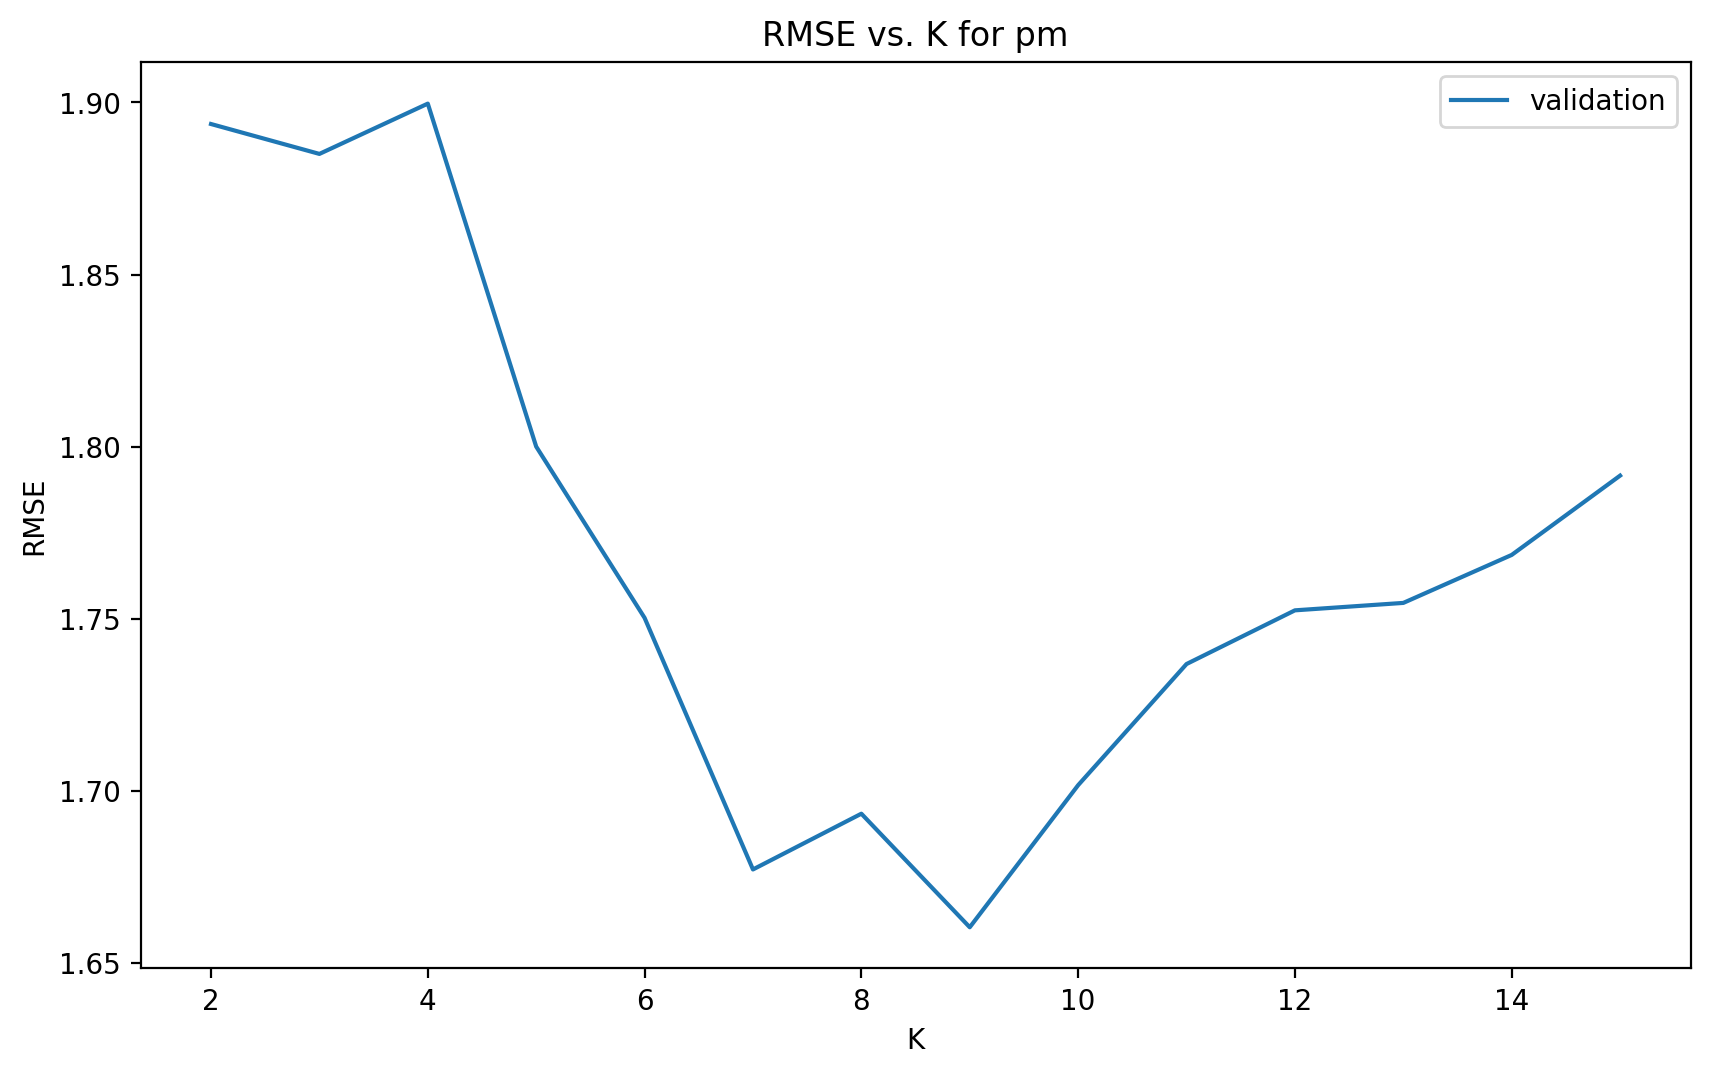

In [83]:
k_list = np.arange(2, 16)
x_train_pm = np.array(train['pm']).reshape(-1, 1)
x_val_pm = np.array(validation['pm']).reshape(-1, 1)
x_test_pm = np.array(test['pm']).reshape(-1, 1)

rmse_pm = []
rmse_pm_validation = []

for k in k_list:
    pm_model = neighbors.KNeighborsRegressor(n_neighbors = k)
    pm_model.fit(x_train_pm, y_train)
    pm_pred = pm_model.predict(x_val_pm)
    #pm_pred_train = pm_model.predict(x_train_pm)
    #rmse_train = (mean_squared_error(y_train, pm_pred_train))**(1/2)
    rmse = (mean_squared_error(y_val, pm_pred))**(1/2)
    rmse_pm_validation.append(rmse)
    #rmse_pm_train.append(rmse_train)

#plt.plot(k_list,rmse_pm,label = 'test' )
plt.figure(figsize=(10, 6), dpi=200)
plt.plot(k_list,rmse_pm_validation, label = 'validation')

plt.title("RMSE vs. K for pm")
plt.xlabel("K")
plt.ylabel("RMSE")
plt.legend();

In [84]:
x_train_pm = np.array(train['pm']).reshape(-1, 1)
x_test_pm = np.array(test['pm']).reshape(-1, 1)
rmse_pm_list = []
pm_model = neighbors.KNeighborsRegressor(n_neighbors = 9)
pm_model.fit(x_train_pm, y_train)
pm_pred = pm_model.predict(x_test_pm)
rmse_pm = (mean_squared_error(y_test, pm_pred))**(1/2)
#rmse_pm_list.append(rmse_pm)
#rmse_pm_list
rmse_pm 

1.4094379844813196

In [85]:
x_train_oz = np.array(train['ozone']).reshape(-1, 1)
x_test_oz = np.array(test['ozone']).reshape(-1, 1)
oz_model = neighbors.KNeighborsRegressor(n_neighbors = 6)
oz_model.fit(x_train_oz, y_train)
oz_pred = oz_model.predict(x_test_oz)
rmse_oz = (mean_squared_error(y_test, oz_pred))**(1/2)
rmse_oz

1.8025464241209184

In [86]:
#crude prevalence
#pm gaussian
import statsmodels.api as sm
gaussian_model = sm.GLM(
    df_age.DataValue, sm.add_constant(df_age.pm), 
    family=sm.families.Gaussian()
)
pm_results = gaussian_model.fit()
print(pm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              DataValue   No. Observations:                  196
Model:                            GLM   Df Residuals:                      194
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          2.7646
Method:                          IRLS   Log-Likelihood:                -376.76
Date:                Mon, 10 May 2021   Deviance:                       536.34
Time:                        15:01:01   Pearson chi2:                     536.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1285      0.662      7.749      0.0

In [87]:
#pm poisson
poisson_model = sm.GLM(
    df_age.DataValue, sm.add_constant(df_age.pm), 
    family=sm.families.Poisson()
)
po_results = poisson_model.fit()
print(po_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              DataValue   No. Observations:                  196
Model:                            GLM   Df Residuals:                      194
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -403.73
Date:                Mon, 10 May 2021   Deviance:                       77.120
Time:                        15:01:01   Pearson chi2:                     80.0
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6633      0.156     10.639      0.0

In [88]:
#ozone gaussian
gaussian_model = sm.GLM(
    df_age.DataValue, sm.add_constant(df_age.ozone), 
    family=sm.families.Gaussian()
)
ozone_results = gaussian_model.fit()
print(ozone_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              DataValue   No. Observations:                  196
Model:                            GLM   Df Residuals:                      194
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          2.8348
Method:                          IRLS   Log-Likelihood:                -379.22
Date:                Mon, 10 May 2021   Deviance:                       549.95
Time:                        15:01:01   Pearson chi2:                     550.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8212      1.302      4.469      0.0

In [89]:
#ozone poisson
poisson_model = sm.GLM(
    df_age.DataValue, sm.add_constant(df_age.ozone), 
    family=sm.families.Poisson()
)
ozone_results2 = poisson_model.fit()
print(ozone_results2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              DataValue   No. Observations:                  196
Model:                            GLM   Df Residuals:                      194
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -404.76
Date:                Mon, 10 May 2021   Deviance:                       79.179
Time:                        15:01:01   Pearson chi2:                     82.9
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7696      0.301      5.886      0.0

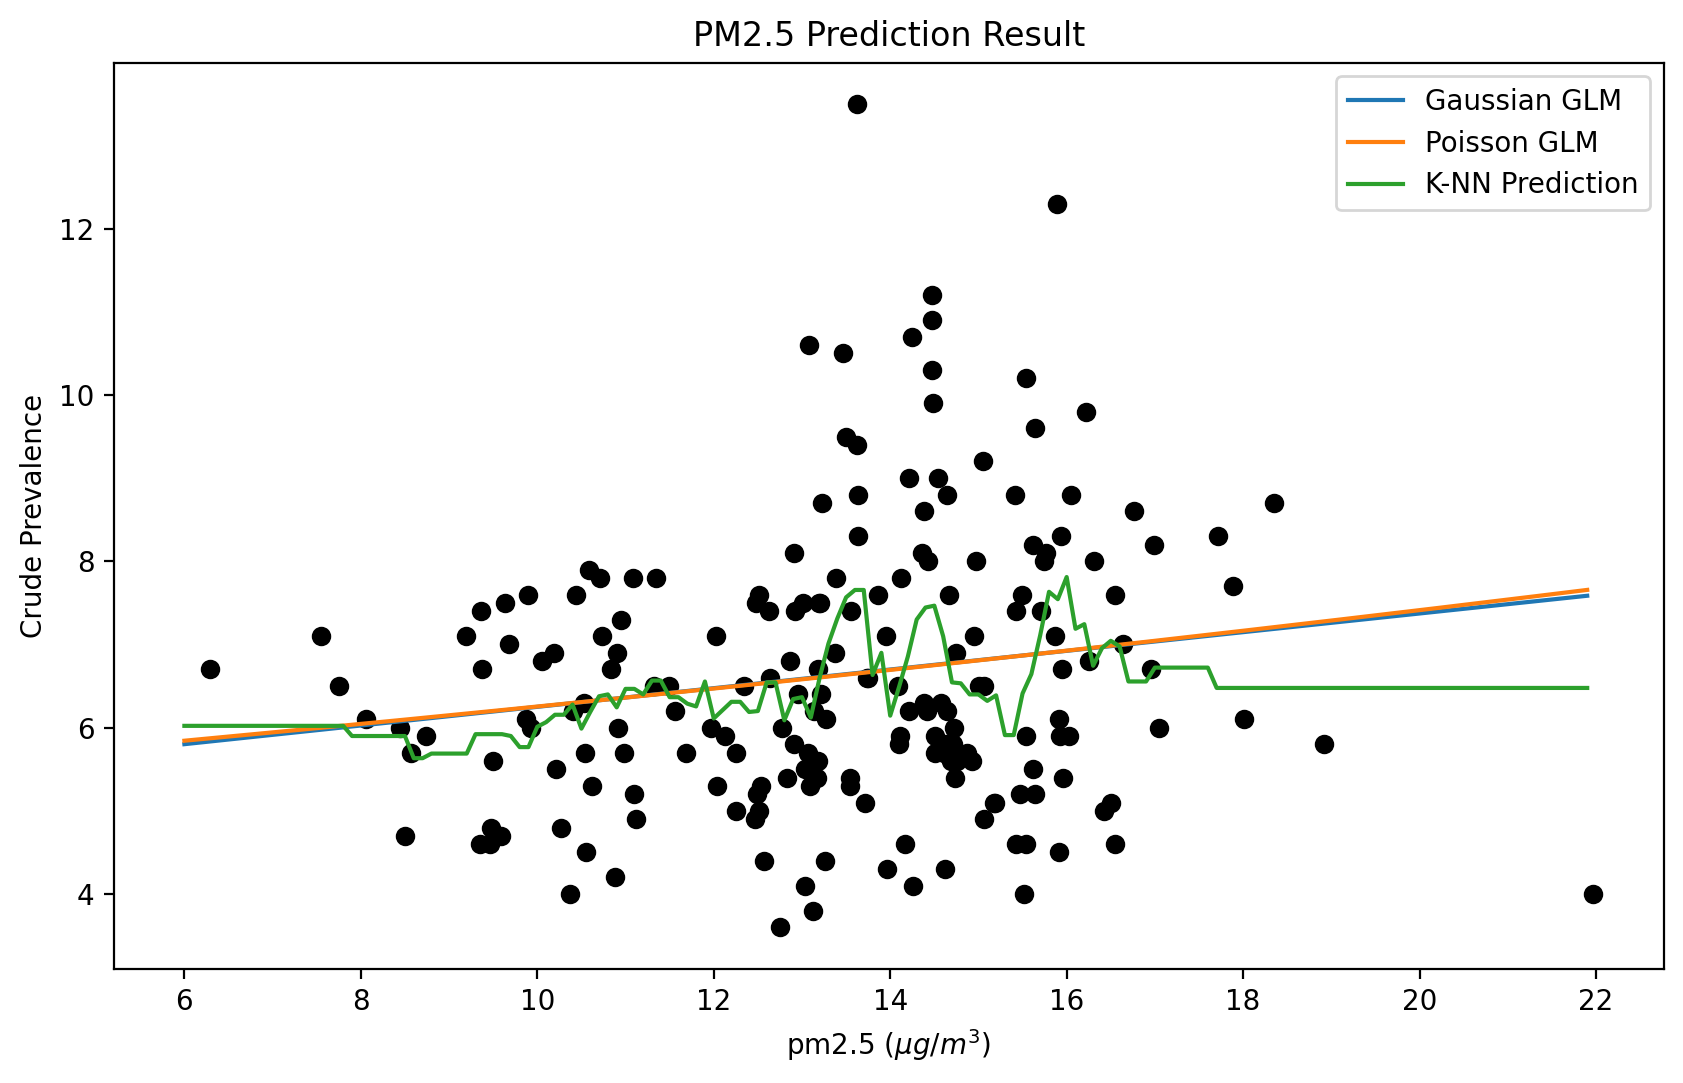

In [90]:
plt.figure(figsize=(10, 6), dpi=200)
pm_sim = np.arange(6, 22, 0.1) #simulate the x from 6 to 22, scale 0.1
plt.scatter(df_age["pm"], df_age["DataValue"], c = "k")
plt.plot(pm_sim, pm_results.predict(sm.add_constant(pm_sim)), label = "Gaussian GLM")
plt.plot(pm_sim, po_results.predict(sm.add_constant(pm_sim)), label = "Poisson GLM")
plt.plot(pm_sim, pm_model.predict(np.array(pm_sim).reshape(-1, 1)), label = "K-NN Prediction")
plt.legend()
plt.xlabel("pm2.5 ($\mu g/m^3$)")
plt.ylabel("Crude Prevalence")
plt.title("PM2.5 Prediction Result");


In [91]:
pm_results.predict(sm.add_constant(pm_sim))
pm_sim

array([ 6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,  6.7,  6.8,  6.9,  7. ,
        7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,  7.8,  7.9,  8. ,  8.1,
        8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,  8.9,  9. ,  9.1,  9.2,
        9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9, 10. , 10.1, 10.2, 10.3,
       10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11. , 11.1, 11.2, 11.3, 11.4,
       11.5, 11.6, 11.7, 11.8, 11.9, 12. , 12.1, 12.2, 12.3, 12.4, 12.5,
       12.6, 12.7, 12.8, 12.9, 13. , 13.1, 13.2, 13.3, 13.4, 13.5, 13.6,
       13.7, 13.8, 13.9, 14. , 14.1, 14.2, 14.3, 14.4, 14.5, 14.6, 14.7,
       14.8, 14.9, 15. , 15.1, 15.2, 15.3, 15.4, 15.5, 15.6, 15.7, 15.8,
       15.9, 16. , 16.1, 16.2, 16.3, 16.4, 16.5, 16.6, 16.7, 16.8, 16.9,
       17. , 17.1, 17.2, 17.3, 17.4, 17.5, 17.6, 17.7, 17.8, 17.9, 18. ,
       18.1, 18.2, 18.3, 18.4, 18.5, 18.6, 18.7, 18.8, 18.9, 19. , 19.1,
       19.2, 19.3, 19.4, 19.5, 19.6, 19.7, 19.8, 19.9, 20. , 20.1, 20.2,
       20.3, 20.4, 20.5, 20.6, 20.7, 20.8, 20.9, 21

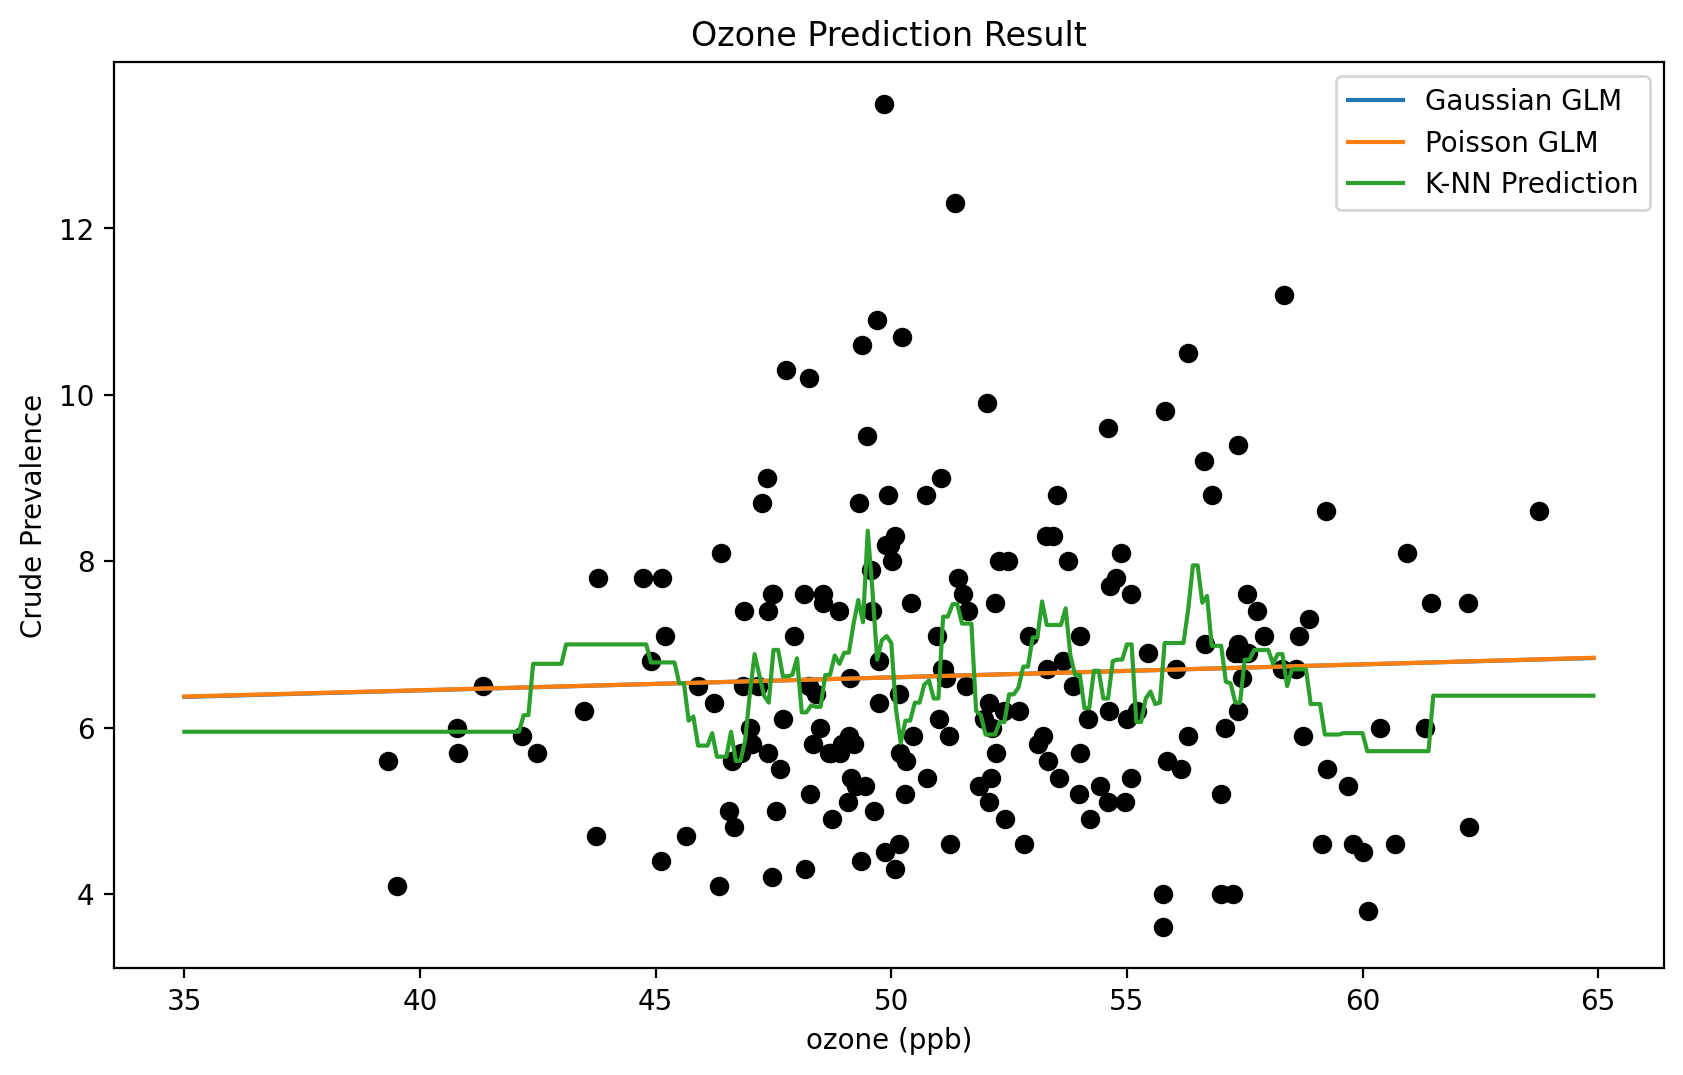

In [92]:
plt.figure(figsize = (10,6), dpi =200)
ozone_sim = np.arange(35, 65, 0.1)
plt.scatter(df_age["ozone"], df_age["DataValue"], c = "k")
plt.plot(ozone_sim, ozone_results.predict(sm.add_constant(ozone_sim)), label = "Gaussian GLM")
plt.plot(ozone_sim, ozone_results2.predict(sm.add_constant(ozone_sim)), label = "Poisson GLM")
plt.plot(ozone_sim, oz_model.predict(np.array(ozone_sim).reshape(-1, 1)), label = "K-NN Prediction")
plt.legend()
plt.xlabel("ozone (ppb)")
plt.ylabel("Crude Prevalence")
plt.title("Ozone Prediction Result");


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=baa466b1-4877-4162-955b-608c474b1ddc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>